In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
    library(EnhancedVolcano)
    library(rlist)
    library(purrr)
}))
options(timeout=100000)
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

Loading required package: limma


Attaching package: 'limma'


The following object is masked from 'package:BiocGenerics':

    plotMA




# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

In [4]:
if(!exists("papermill_run")) {
    prj_name = "Screen1"
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"
    de_testing = "NEIGHBORHOOD"
    filter_low_cas9 = "NO"
}

In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

Mark cells that are positive for given guides as vector_positive, all others as target_negative

In [6]:
# mark_guide_pos_neg <- function(seurat_obj, perturbed_cells_by_guide, guides, print_counts = T) {
#     all_cells = Cells(seurat_obj)
#     perturbed_cells = c()
#     dummy_perturbed = c()
    
#     for(guide in guides) {
#         dummy_perturbed = unlist(perturbed_cells_by_guide[[guide]])
#         perturbed_cells = union(perturbed_cells, dummy_perturbed)
#         #cat(guide," ", length(perturbed_cells), "\n")
#     }

#     unperturbed_cells = unlist(setdiff(all_cells, perturbed_cells))
#     Idents(seurat_obj) <- "target_negative"
#     seurat_obj <- SetIdent(seurat_obj, cells = perturbed_cells, value = "vector_positive") 

#     if(print_counts) {
#         n_gplus   = length(perturbed_cells)
#         n_gminus = length(unperturbed_cells)    
#         cat(blue("Guide+ =",n_gplus, "; Guide- =", n_gminus, "\n"))
#     }
    
#     seurat_obj
# }

### Load guide df

In [7]:
if(prj_name == "Screen1") {
    df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
    integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
    neighbors_list = list.load("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/neighbors_list.rds")
} else if(prj_name == "Screen2") {
    df_guide = read.table("/home/vsevim/prj/1012-ckd/S2/scripts/library_csv/101_CRISPRa_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
    integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
    neighbors_list = list.load("/home/vsevim/prj/1012-ckd/S2/scripts/library_csv/neighbors_list.rds")
}

sample_n(df_guide, 6)

gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
rs7707989,DE4-2a,DE4-2b,DE4,ckd_de,targeting,rs7707989,CKD DE
rs2823139,DE1-2a,DE1-2b,DE1,ckd_de,targeting,rs2823139,CKD DE
rs881858,DE9-1a,DE9-1b,DE9,ckd_de,targeting,rs881858,CKD DE
rs6839100,DE12-2a,DE12-2b,DE12,ckd_de,targeting,rs6839100,CKD DE
rs4720089,DE14-1a,DE14-1b,DE14,ckd_de,targeting,rs4720089,CKD DE
Enh37-10-PLIN3,PLIN3-1a,PLIN3-1b,PLIN3,de_control,targeting,PLIN3,Control DE


### Load Seurat file

In [8]:
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = F)
#seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file



Warning message:
"Adding a command log without an assay associated with it"


In [9]:
table(seurat_combined@meta.data$n_guides)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
6381 1786 6121 1705 3264 1317 1697  854  873  599  480  332  291  221  195  141 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
 102   79   81   75   64   49   47   39   38   31   28   18   15   15   22   12 
  32   33   34   35   36   37   38   39   40   41   42   43   45   46   47   48 
  21   17    8   12   11   14    5    4    4   10    6    6    2    5    5    1 
  49   50   51   52   53   54   55   56   57   58   59   60   62   64   65   69 
   2    6    4    4    1    4    1    3    2    2    1    2    3    1    1    1 
  77 
   1 

In [10]:
if(filter_low_cas9 == "YES") {
    seurat_combined$sct_cas9 = seurat_combined[['SCT']]@data['dCas9',]
    seurat_combined = subset(seurat_combined, subset=sct_cas9 > 2)
}


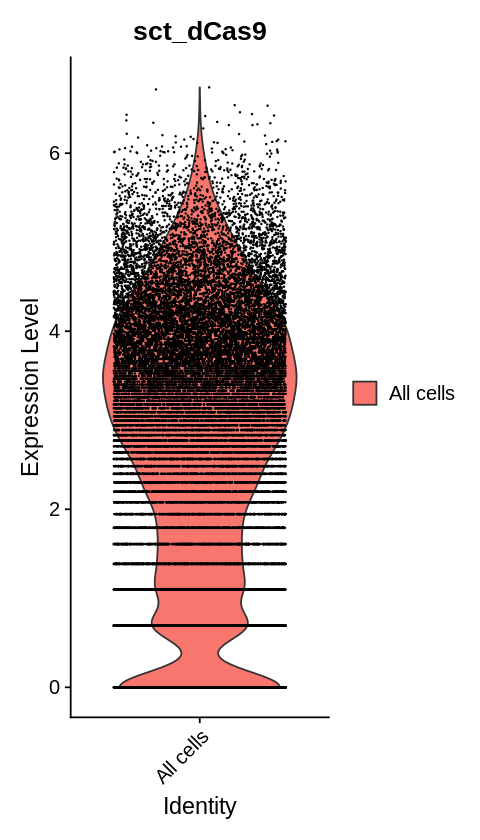

In [11]:
options(repr.plot.width = 4, repr.plot.height = 7)
Idents(seurat_combined) <- "All cells"
VlnPlot(seurat_combined, assay = 'SCT', features = "sct_dCas9")

Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [12]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [13]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

## Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [14]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [15]:
THRESHOLD_MULTIPLIER = 1
cat(red("Using ", THRESHOLD_MULTIPLIER, "x threshold"))

perturbed_cells_by_guide = list()

for(i in 1:nrow(df_thresholds)){  
    perturbed_cells_in_all_libs = list()
    guide = df_thresholds$guide[i]
    # Loop over libraries
    for(lib in libraries){        
        seurat_lib = seurat_libs[[lib]]
        threshold = THRESHOLD_MULTIPLIER * df_thresholds[i, lib]        
        #cat(blue(guide, lib, threshold, "\n"))
        cells_in_lib = Cells(seurat_lib)        
        sgrna_counts = seurat_lib[['sgRNA']]@counts
        select_perturbed = sgrna_counts[guide, cells_in_lib] >= threshold
        perturbed_cells_in_library = cells_in_lib[select_perturbed]
        #cat(length(cells_in_lib), "in", lib, guide, length(perturbed_cells_in_library), "cells >", threshold, "\n")        
        if(!is.na(threshold)) {
            perturbed_cells_in_all_libs = append(perturbed_cells_in_all_libs, perturbed_cells_in_library)
        }
    }
    perturbed_cells_by_guide[[i]] = perturbed_cells_in_all_libs
}
names(perturbed_cells_by_guide) <- df_thresholds$guide

Using  1 x threshold

In [16]:
length(perturbed_cells_by_guide[[3]])

[1] 796

In [17]:
df_thresholds$guide[grepl("NT" , df_thresholds$guide)]

[1] "NTCE1-1a" "NTCE1-1b" "NTCE2-1a" "NTCE2-1b" "NTCE3-1a" "NTCE3-1b" "NTCE4-1a"
[8] "NTCE4-1b"

In [18]:
head(seurat_rna)

,nCount_RNA,nFeature_RNA,nCount_sgRNA,nFeature_sgRNA,nCount_SCT,nFeature_SCT,orig.ident,library,percent.mt,status,donor,dCas9,SCT_snn_res.0.5,seurat_clusters,guide_calls,plasmid_calls,n_guides,n_plasmids
,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>
AAACCCAAGAGCAGCT-1_1,25185,5887,3237,19,24864,5840,Screen1_66guides,Lib_1,6.7,singlet,3,20,1,1,FUBP1-1a|DE6-2a|DE8-1a|DE8-1b|DE15-2b,FUBP1-1|DE6-2|DE8-1|DE15-2,5,4
AAACCCAAGCTTAAGA-1_1,43958,7411,2844,31,25774,6580,Screen1_66guides,Lib_1,9.0,singlet,0,55,2,2,CD13-1a|CD13-1b|DE3-2a|DE3-2b,CD13-1|DE3-2,4,2
AAACCCAAGGCTGTAG-1_1,73018,9094,1908,22,24680,5745,Screen1_66guides,Lib_1,14.0,singlet,0,181,2,2,TKT-1a|TKT-1b,TKT-1,2,1
AAACCCAAGGTTTACC-1_1,63652,8614,2088,20,25085,5994,Screen1_66guides,Lib_1,6.2,singlet,2,58,0,0,DE9-1a|DE9-1b|DE11-1a,DE9-1|DE11-1,3,2
AAACCCAAGTGATCGG-1_1,34135,6635,7,7,25531,6506,Screen1_66guides,Lib_1,15.5,singlet,2,1,6,6,NA,NA,0,0
AAACGAACAATTGCTG-1_1,39723,7312,1343,17,25647,6815,Screen1_66guides,Lib_1,5.5,singlet,1,100,2,2,CD55-1a|CD55-1b|TKT-2a|TKT-2b,CD55-1|TKT-2,4,2
AAACGAACAGGTGAGT-1_1,41606,7788,15272,77,25724,7144,Screen1_66guides,Lib_1,5.2,singlet,1,275,4,4,CD13-1a|CD13-1b|CD55-1a|FUBP1-1a|FUBP1-1b|MAFF-1a|MAFF-1b|TKT-1b|CSTB-1a|CSTB-1b|CTSB-2a|DE8-1a|DE11-1a|DE17-2b|NTCE3-1a|CCCE2-1a|CCCE2-1b,CD13-1|CD55-1|FUBP1-1|MAFF-1|TKT-1|CSTB-1|CTSB-2|DE8-1|DE11-1|DE17-2|NTCE3-1|CCCE2-1,17,12
AAACGAACATGGCTGC-1_1,34297,7322,1328,14,25795,7184,Screen1_66guides,Lib_1,3.6,singlet,1,4,5,5,DE7-1a|DE7-1b,DE7-1,2,1
AAACGAAGTAAGACCG-1_1,85992,10086,6496,35,25234,6617,Screen1_66guides,Lib_1,7.6,singlet,2,37,5,5,FUBP1-1a|FUBP1-1b|CSTB-2a|CSTB-2b|DE12-1a|DE12-1b,FUBP1-1|CSTB-2|DE12-1,6,3


# Check DE for genes near SNPs

In [19]:
select_distal  = df_guide$subclass == 'ckd_de'
df_snps = unique(df_guide[select_distal, c('gene','alias')])

* * * * *
I skip DE 20 because it doesn't have a rsID. Use it's coords instead 
* * * * *

## Load neighbors list

# Run diffex on pseudobulked samples using EdgeR

This version ran DE testing on all genes. If you want to include only the neighbors, use: markers <- qlf$table[neighbors, ] %>% arrange(PValue)

In [20]:
library(edgeR)

In [21]:
sample_n(df_guide, 5)

gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
rs4669722,DE10-1a,DE10-1b,DE10,ckd_de,targeting,rs4669722,CKD DE
CD13,CD13-1a,CD13-1b,ANPEP,tss,targeting,ANPEP,Control TSS
rs34861762,DE7-2a,DE7-2b,DE7,ckd_de,targeting,rs34861762,CKD DE
GDOC3,GDOC3-1a,GDOC3-1b,GDOC3,gdoc,nt_ctrl,GDOC3,gdoc
rs7642977,DE2-1a,DE2-1b,DE2,ckd_de,targeting,rs7642977,CKD DE


### This is the loop before refactoring

In [22]:
# source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')
# df_targets = unique(filter(df_guide, subclass=='ckd_de'))
# df_targets = unique(filter(df_guide, class=='targeting'))
# #df_targets = unique(filter(df_guide, alias=='PLIN3'))

# df_neighbor_de = NULL
# df_cell_counts = NULL
# test_use = "LR" #"MAST"  #"wilcox" "LR"
# guides_to_skip = c()  #c("DE6", "DE15")  
# logfc_threshold = 0.01

# for(i in 1:nrow(df_targets)) {
#     is_de = FALSE
#     target          = df_targets[i,'alias']
#     target_subclass = df_targets[i, 'subclass']
#     label           = df_targets[i, 'label']
#     vector_id       = gsub("a", "", df_targets[i, 'guide1'])
#     snp_id_or_gene_name = df_targets[i,'gene']
    
#     if(!str_detect(target, regex("^DE\\d+$"))) {
#         is_de = FALSE
#         neighbors = neighbors_list[[target]]
#     } else {
#         is_de = TRUE
#         neighbors = neighbors_list[[snp_id_or_gene_name]]
#     }

#     if((target %in% guides_to_skip) | length(neighbors) == 0 ){
#         cat(red("Skipping", target, snp_id_or_gene_name, length(neighbors), "\n"))
#         next
#     }
#     guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
#     guides_on_plasmid = unlist(as.list(t(df_targets[i, c('guide1', 'guide2')])))
#     cat(blue(target,":"), paste(guides_on_plasmid, collapse=","),"\n")

#     seurat_dummy <- mark_vector_pos_target_neg(
#         seurat_rna,        
#         perturbed_cells_by_guide, 
#         guides_on_plasmid,
#         guides_4_target,
#         print_counts = T,
#         pos_label = "vector_positive",
#         neg_label = "target_negative"
#     )    
#     if("vector_positive" %in% levels((Idents(seurat_dummy)))) {
#         seurat_dummy$perturbation_status = Idents(seurat_dummy)
#         #seurat_dummy$psbulk_replicate_id = paste0(seurat_dummy$donor, "_", seurat_dummy$perturbation_status)
#         #Idents(seurat_dummy) = seurat_dummy$psbulk_replicate_id
#         seurat_dummy$donor = paste0("donor", seurat_dummy$donor)
#         print(table(filter(seurat_dummy@meta.data, perturbation_status == 'vector_positive')$donor) )


#         # Use each donor as a replicate
#         cluster_list = as.character(seurat_dummy$perturbation_status)
#         cluster_list[cluster_list == "target_negative"] = 1
#         cluster_list[cluster_list == "vector_positive"] = 0
#         seurat_dummy$cluster = as.factor(cluster_list)
#         y = Seurat2PB(seurat_dummy, sample = "donor", cluster = 'cluster')

#         # Add target+/- counts to df_cell_counts
#         if(!is_de) {
#             df_dummy = as.data.frame(y$counts[target,])
#             colnames(df_dummy) = "count"
#             df_dummy$target <- target
#             df_dummy$label = rownames(df_dummy)
#             df_dummy$vector = vector_id
#             df_samples = y$samples
#             df_dummy = merge(df_dummy, df_samples, by = 0)
#             df_cell_counts = rbind(df_cell_counts, df_dummy)
#         }

#         # Filter out small samples, lowly expressed genes.
#         keep.samples <- y$samples$lib.size > 5e4
#         table(keep.samples)
#         y <- y[, keep.samples]
#         keep.genes <- filterByExpr(y, group=y$samples$cluster, min.count=10, min.total.count=20)
#         table(keep.genes)
#         y <- normLibSizes(y)

#         # Create design matrix
#         donor <- factor(y$samples$sample)
#         cluster <- as.factor(y$samples$cluster)
#         design <- model.matrix(~ cluster + donor)
#         colnames(design) <- gsub("donor", "", colnames(design))
#         colnames(design)[1] <- "Int"

#         ncls <- nlevels(cluster)
#         contr <- rbind( matrix(1/(1-ncls), ncls, ncls), matrix(0, ncol(design)-ncls, ncls) )
#         diag(contr) <- 1
#         contr[1,] <- 0
#         rownames(contr) <- colnames(design)
#         colnames(contr) <- paste0("cluster", levels(cluster))
        
#         # Estimate dispersion
#         y <- estimateDisp(y, design, robust=TRUE)
#         y$common.dispersion

#         # Fit
#         fit <- glmQLFit(y, design, robust=TRUE)
#         qlf <- glmQLFTest(fit, contrast=contr[,1])
        
#         if(de_testing == "NEIGHBORHOOD") {
#             markers <- qlf$table[neighbors, ] %>% arrange(PValue)
#         } else { 
#             # Test all genes
#             markers <- qlf$table %>% arrange(PValue)
#         }

#         if(nrow(markers) == 0) {
#             cat(red("No DE genes", target,  "\n"))
#             next
#         } 
      
#         markers$de_gene = rownames(markers)
#         markers$target = target
#         markers$subclass = target_subclass
#         markers$label = label
#         markers$plasmid = vector_id #gsub("a", "", guides_on_plasmid[[1]])
#         rownames(markers) <- NULL
#         df_neighbor_de = rbind(df_neighbor_de, markers)
#         print(head(markers))
#         cat("-------------------------------------------------------\n\n")
#     } else {
#         cat(red("No cells found:"), paste(guides_on_plasmid, collapse=","),"\n")
#     }
# }


### After refactoring

In [23]:
# Helper function to prepare design matrix and contrast matrix
prepare_design_and_contrast <- function(y) {
    donor <- factor(y$samples$sample)
    cluster <- as.factor(y$samples$cluster)  # Convert cluster to a factor (if not already)
    
    design <- model.matrix(~ cluster + donor)
    colnames(design) <- gsub("donor", "", colnames(design))
    colnames(design)[1] <- "Int"

    ncls <- nlevels(cluster)
    contr <- rbind(matrix(1 / (1 - ncls), ncls, ncls), matrix(0, ncol(design) - ncls, ncls))
    diag(contr) <- 1
    contr[1, ] <- 0
    rownames(contr) <- colnames(design)
    colnames(contr) <- paste0("cluster", levels(cluster))

    return(list(design = design, contrast = contr))
}

# Helper function to perform differential expression analysis
perform_de_analysis <- function(y, design, contrast, neighbors, target, de_testing) {
    y <- estimateDisp(y, design, robust = TRUE)
    print(y$common.dispersion)

    fit <- glmQLFit(y, design, robust = TRUE)
    qlf <- glmQLFTest(fit, contrast = contrast[, 1])
    plotQLDisp(fit)

    if (de_testing == "NEIGHBORHOOD") {
        markers <- qlf$table[neighbors, ] %>% arrange(PValue)
    } else {
        # Test all genes
        markers <- qlf$table %>% arrange(PValue)
    }

    return(markers)
}

# Helper function to process cells with the given target and perturbation status
process_target_cells <- function(
    seurat_dummy, target, vector_id, is_de, neighbors,
    perturbed_cells_by_guide, guides_on_plasmid, guides_4_target, 
    df_cell_counts, df_neighbor_de, pos_label, neg_label, target_subclass
) {
    # Filter out the vector_neg_target_pos cells, bc they mess up the design matrix
    seurat_dummy = subset(seurat_dummy, ident=c(pos_label, neg_label))
    seurat_dummy$perturbation_status = Idents(seurat_dummy)
    seurat_dummy$donor = paste0("donor", seurat_dummy$donor)
    print(table(filter(seurat_dummy@meta.data, perturbation_status == 'vector_positive')$donor))

    cluster_list <- as.character(seurat_dummy$perturbation_status)
    cluster_list[cluster_list == "target_negative"] <- 1
    cluster_list[cluster_list == "vector_positive"] <- 0
    seurat_dummy$cluster <- as.factor(cluster_list)
    y <- Seurat2PB(seurat_dummy, sample = "donor", cluster = 'cluster')

    # Add target+/- counts to df_cell_counts
    if (!is_de) {
        df_dummy <- as.data.frame(y$counts[target, ])
        colnames(df_dummy) <- "count"
        df_dummy$target <- target
        df_dummy$label = rownames(df_dummy)
        df_dummy$vector = vector_id
        df_dummy$subclass = target_subclass
        df_samples = y$samples
        df_dummy = merge(df_dummy, df_samples, by = 0)
        df_cell_counts <- rbind(df_cell_counts, df_dummy)
    }

    # Filter out small samples, lowly expressed genes.
    keep.samples <- y$samples$lib.size > 5e4
    y <- y[, keep.samples]
    keep.genes <- filterByExpr(y, group = y$samples$cluster, min.count = 10, min.total.count = 20)
    y <- normLibSizes(y)

    design_and_contrast <- prepare_design_and_contrast(y)
    markers <- perform_de_analysis(
        y, 
        design_and_contrast$design, 
        design_and_contrast$contrast, 
        neighbors, 
        target, 
        de_testing
    )

    if (nrow(markers) == 0) {
        cat(red("No DE genes", target, "\n"))
    } else {
        markers$de_gene <- rownames(markers)
        markers$target <- target
        markers$subclass <- target_subclass
        markers$label <- label
        markers$plasmid <- vector_id
        rownames(markers) <- NULL
        df_neighbor_de <- rbind(df_neighbor_de, markers)
        print(head(markers))
        cat("-------------------------------------------------------\n\n")
    }

    if(de_testing == "NEIGHBORHOOD") {
        n_tests_performed = length(neighbors)
    } else {
        n_tests_performed = nrow(y)
    }

    return(list(df_cell_counts = df_cell_counts, df_neighbor_de = df_neighbor_de, n_tests_performed = n_tests_performed))
}

ANPEP : CD13-1a,CD13-1b 
CD13-1a   867 
CD13-1b   889 
[1] "CD13-1a" "CD13-1b"
[1] "CD13-1a" "CD13-1b"
Vector+ = 1161 ; Target- = 25981 ; All = 27142 

donor0 donor1 donor2 donor3 
   270    233    385    273 
[1] 0.0014
  logFC logCPM    F   PValue de_gene target subclass       label plasmid
1 -1.32    6.9 1122 2.6e-207   ANPEP  ANPEP      tss Control TSS  CD13-1
2 -0.33    6.7   76  2.5e-18    IDH2  ANPEP      tss Control TSS  CD13-1
3 -0.20    6.7   27  1.8e-07  SEMA4B  ANPEP      tss Control TSS  CD13-1
4  0.23    5.4   23  1.5e-06   AP3S2  ANPEP      tss Control TSS  CD13-1
5  0.21    5.4   19  1.5e-05   MFGE8  ANPEP      tss Control TSS  CD13-1
6 -0.36    3.5   15  1.2e-04   FANCI  ANPEP      tss Control TSS  CD13-1
-------------------------------------------------------

CD55 : CD55-1a,CD55-1b 
CD55-1a   796 
CD55-1b   848 
[1] "CD55-1a" "CD55-1b"
[1] "CD55-1a" "CD55-1b"
Vector+ = 1081 ; Target- = 26061 ; All = 27142 

donor0 donor1 donor2 donor3 
   253    220    319    289 
[1

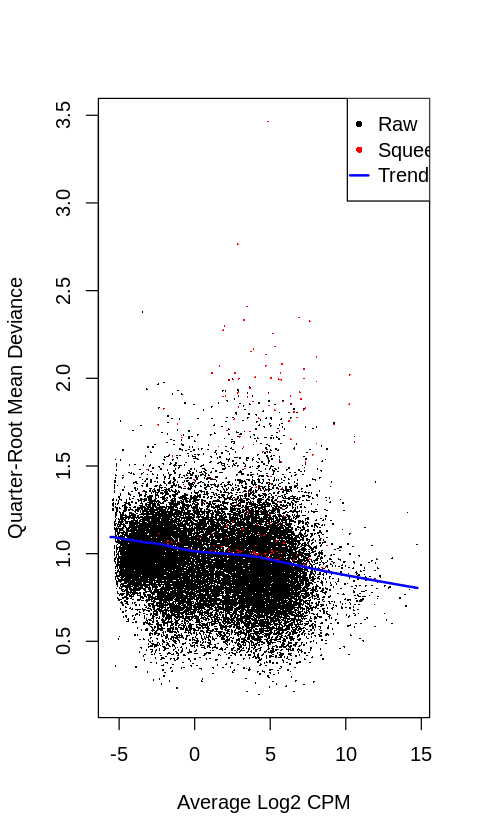

  logFC logCPM     F  PValue  de_gene target subclass       label plasmid
1 -2.20    4.1 432.1 8.8e-96     CD55   CD55      tss Control TSS  CD55-1
2 -0.32    2.6   6.2 1.3e-02 C1orf116   CD55      tss Control TSS  CD55-1
3 -0.28    2.9   5.9 1.5e-02    IKBKE   CD55      tss Control TSS  CD55-1
4 -0.18    4.0   5.3 2.1e-02    EIF2D   CD55      tss Control TSS  CD55-1
5  1.86   -3.9   3.7 5.4e-02      CR2   CD55      tss Control TSS  CD55-1
6  0.18    3.1   3.3 6.9e-02    DYRK3   CD55      tss Control TSS  CD55-1
-------------------------------------------------------

NT5E : CD73-1a,CD73-1b 
CD73-1a   757 
CD73-1b   769 
[1] "CD73-1a" "CD73-1b"
[1] "CD73-1a" "CD73-1b"
Vector+ = 1020 ; Target- = 26122 ; All = 27142 

donor0 donor1 donor2 donor3 
   231    215    337    237 
[1] 0.002


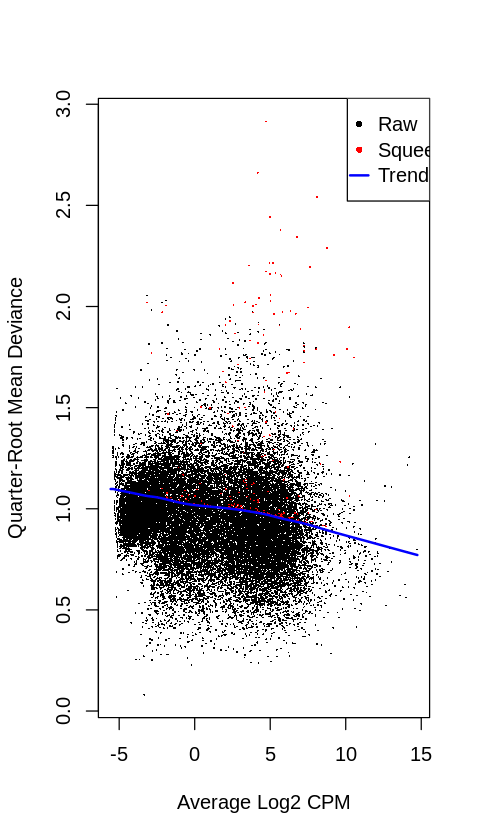

   logFC logCPM       F   PValue   de_gene target subclass       label plasmid
1 -1.848    6.4 1290.77 6.0e-165      NT5E   NT5E      tss Control TSS  CD73-1
2  0.081    6.1    3.25  7.2e-02 LINC01611   NT5E      tss Control TSS  CD73-1
3 -0.371    0.5    1.70  1.9e-01 LINC02535   NT5E      tss Control TSS  CD73-1
4  0.032    8.4    0.97  3.3e-01     SNHG5   NT5E      tss Control TSS  CD73-1
5  0.076    2.1    0.25  6.2e-01     TBX18   NT5E      tss Control TSS  CD73-1
6 -0.016    6.2    0.13  7.2e-01     SNX14   NT5E      tss Control TSS  CD73-1
-------------------------------------------------------

FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   708 
FUBP1-1b   702 
[1] "FUBP1-1a" "FUBP1-1b"
[1] "FUBP1-1a" "FUBP1-1b"
Vector+ = 925 ; Target- = 26217 ; All = 27142 

donor0 donor1 donor2 donor3 
   229    166    282    248 
[1] 0.0016


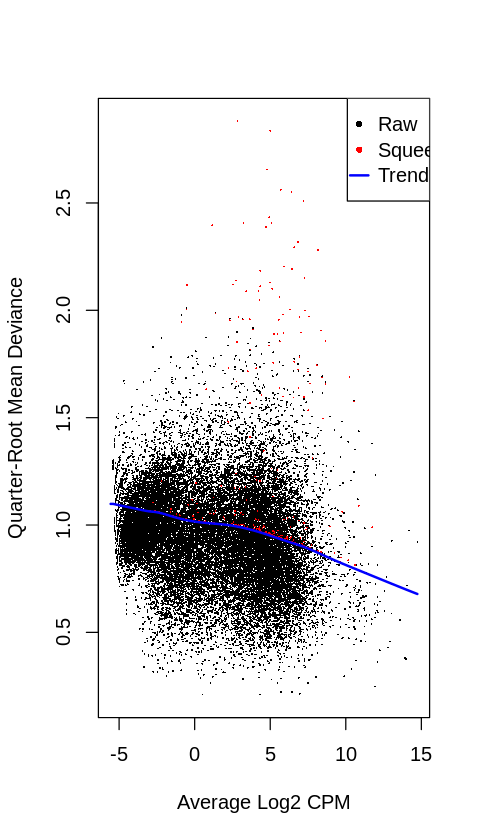

  logFC logCPM     F  PValue de_gene target subclass       label plasmid
1 -0.86    5.6 246.5 5.1e-55   FUBP1  FUBP1      tss Control TSS FUBP1-1
2 -0.18    7.4  25.2 5.1e-07     AK5  FUBP1      tss Control TSS FUBP1-1
3 -0.56    2.5  14.6 1.3e-04   PTGFR  FUBP1      tss Control TSS FUBP1-1
4 -0.21    4.6   9.1 2.5e-03  ADGRL4  FUBP1      tss Control TSS FUBP1-1
5  0.31    3.0   8.5 3.6e-03  DNAJB4  FUBP1      tss Control TSS FUBP1-1
6 -0.13    6.0   7.8 5.1e-03   USP33  FUBP1      tss Control TSS FUBP1-1
-------------------------------------------------------

C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   822 
C15orf40-1b   819 
[1] "C15orf40-1a" "C15orf40-1b"
[1] "C15orf40-1a" "C15orf40-1b"
Vector+ = 1076 ; Target- = 26066 ; All = 27142 

donor0 donor1 donor2 donor3 
   274    210    323    269 
[1] 0.0018


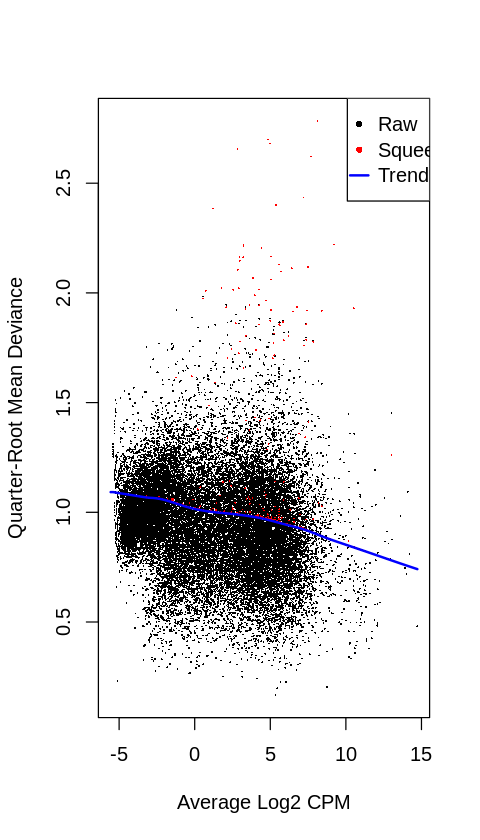

   logFC logCPM     F   PValue  de_gene   target subclass       label
1 -2.135    4.9 790.1 3.1e-173 C15orf40 C15orf40      tss Control TSS
2 -0.416    3.0  13.2  2.8e-04 ADAMTSL3 C15orf40      tss Control TSS
3  0.427    1.6   6.8  9.2e-03    CPEB1 C15orf40      tss Control TSS
4 -0.425    1.8   6.0  1.5e-02   SNHG21 C15orf40      tss Control TSS
5 -0.121    4.6   3.5  6.3e-02   HDGFL3 C15orf40      tss Control TSS
6  0.035   10.7   2.1  1.4e-01    RPS17 C15orf40      tss Control TSS
     plasmid
1 C15orf40-1
2 C15orf40-1
3 C15orf40-1
4 C15orf40-1
5 C15orf40-1
6 C15orf40-1
-------------------------------------------------------

MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   664 
MAFF-1b   653 
[1] "MAFF-1a" "MAFF-1b"
[1] "MAFF-1a" "MAFF-1b"
Vector+ = 869 ; Target- = 26273 ; All = 27142 

donor0 donor1 donor2 donor3 
   219    185    256    209 
[1] 0.0021


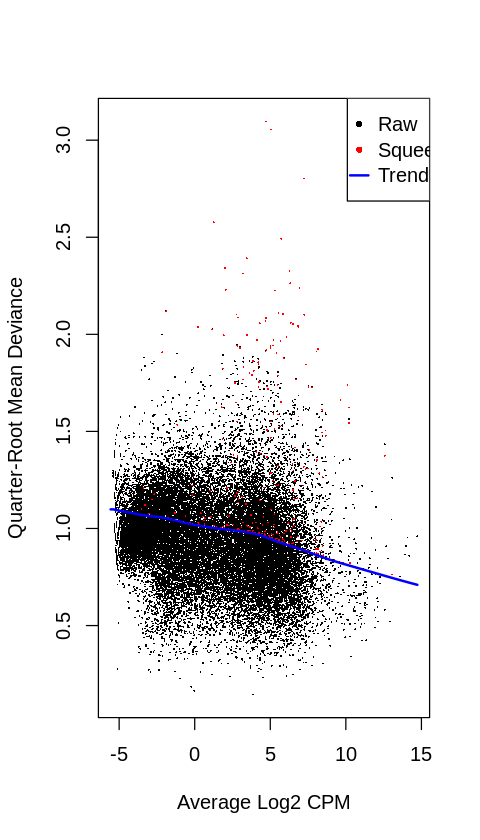

  logFC logCPM   F  PValue de_gene target subclass       label plasmid
1 -1.82   3.37 167 3.5e-38    MAFF   MAFF      tss Control TSS  MAFF-1
2 -0.19  10.47  58 2.7e-14  LGALS1   MAFF      tss Control TSS  MAFF-1
3 -1.33   1.15  21 3.8e-06  LGALS2   MAFF      tss Control TSS  MAFF-1
4 -0.46   3.67  20 6.1e-06    GCAT   MAFF      tss Control TSS  MAFF-1
5 -0.18   6.22  14 1.5e-04   EIF3L   MAFF      tss Control TSS  MAFF-1
6 -1.50   0.22  13 2.6e-04    DMC1   MAFF      tss Control TSS  MAFF-1
-------------------------------------------------------

FTH1 : FTH1-1a,FTH1-1b 
FTH1-1a   625 
FTH1-1b   598 
[1] "FTH1-1a" "FTH1-1b"
[1] "FTH1-1a" "FTH1-2a" "FTH1-1b" "FTH1-2b"
Vector+ = 841 ; Target- = 23640 ; All = 27142 

donor0 donor1 donor2 donor3 
   182    188    255    216 
[1] 0.002


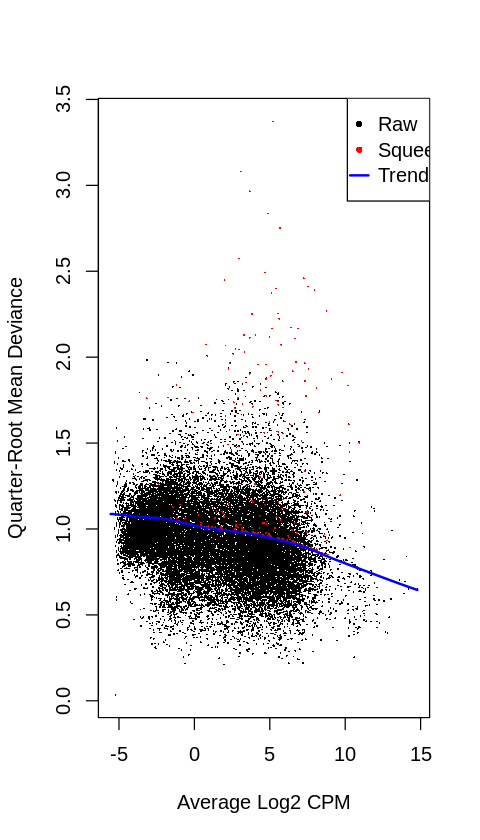

  logFC logCPM    F  PValue de_gene target   subclass      label plasmid
1 -1.67   13.6 4162 0.0e+00    FTH1   FTH1 de_control Control DE  FTH1-1
2 -1.31    3.5  109 2.1e-25   BEST1   FTH1 de_control Control DE  FTH1-1
3 -0.44    5.2   47 5.8e-12   FADS3   FTH1 de_control Control DE  FTH1-1
4 -0.46    4.8   40 2.6e-10   FADS2   FTH1 de_control Control DE  FTH1-1
5 -0.21    8.3   35 3.2e-09   AHNAK   FTH1 de_control Control DE  FTH1-1
6 -0.30    6.0   35 3.6e-09  ASRGL1   FTH1 de_control Control DE  FTH1-1
-------------------------------------------------------

FTH1 : FTH1-2a,FTH1-2b 
FTH1-2a   2836 
FTH1-2b   0 
[1] "FTH1-2a" "FTH1-2b"
[1] "FTH1-1a" "FTH1-2a" "FTH1-1b" "FTH1-2b"
Vector+ = 2836 ; Target- = 23640 ; All = 27142 

donor0 donor1 donor2 donor3 
   694    643    837    662 
[1] 0.00081


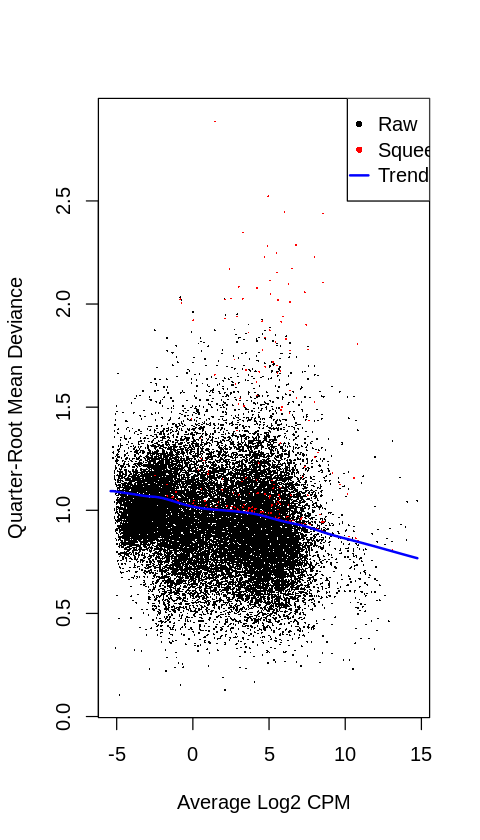

  logFC logCPM  F  PValue de_gene target   subclass      label plasmid
1 -0.42    4.7 98 3.8e-23   FADS2   FTH1 de_control Control DE  FTH1-2
2 -0.22    8.3 93 4.3e-22   AHNAK   FTH1 de_control Control DE  FTH1-2
3  0.24    6.5 76 3.3e-18  SLC3A2   FTH1 de_control Control DE  FTH1-2
4 -0.26    6.0 73 1.5e-17  ASRGL1   FTH1 de_control Control DE  FTH1-2
5 -0.20    5.9 42 7.7e-11   FADS1   FTH1 de_control Control DE  FTH1-2
6 -0.38    3.5 39 3.6e-10   BEST1   FTH1 de_control Control DE  FTH1-2
-------------------------------------------------------

PLIN3 : PLIN3-1a,PLIN3-1b 
PLIN3-1a   863 
PLIN3-1b   850 
[1] "PLIN3-1a" "PLIN3-1b"
[1] "PLIN3-1a" "PLIN3-2a" "PLIN3-1b" "PLIN3-2b"
Vector+ = 1114 ; Target- = 25086 ; All = 27142 

donor0 donor1 donor2 donor3 
   246    244    338    286 
[1] 0.0013


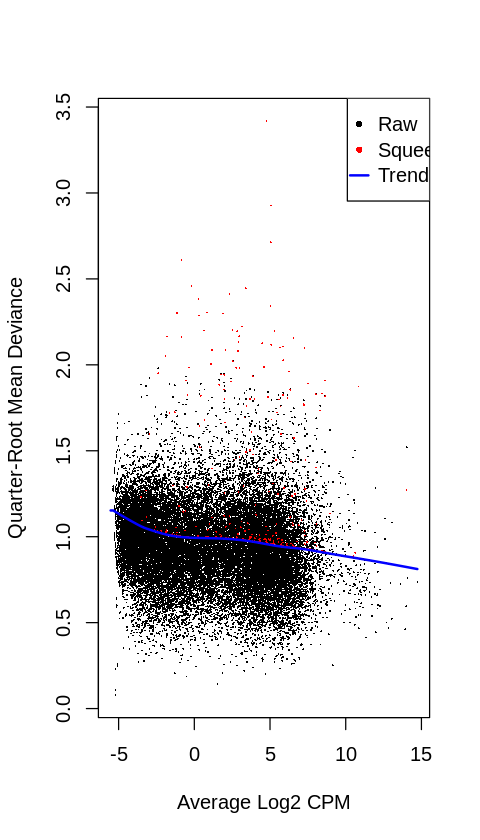

  logFC logCPM   F   PValue de_gene target   subclass      label plasmid
1 -0.96    6.3 528 1.2e-116   PLIN3  PLIN3 de_control Control DE PLIN3-1
2 -0.88    2.3  33  1.0e-08   UHRF1  PLIN3 de_control Control DE PLIN3-1
3  0.13   11.2  31  2.9e-08   RPL36  PLIN3 de_control Control DE PLIN3-1
4 -0.40    3.4  17  3.4e-05  CHAF1A  PLIN3 de_control Control DE PLIN3-1
5  0.21    4.6  12  4.5e-04    DPP9  PLIN3 de_control Control DE PLIN3-1
6  0.63    0.7   9  2.6e-03 ANKRD24  PLIN3 de_control Control DE PLIN3-1
-------------------------------------------------------

PLIN3 : PLIN3-2a,PLIN3-2b 
PLIN3-2a   781 
PLIN3-2b   797 
[1] "PLIN3-2a" "PLIN3-2b"
[1] "PLIN3-1a" "PLIN3-2a" "PLIN3-1b" "PLIN3-2b"
Vector+ = 1049 ; Target- = 25086 ; All = 27142 

donor0 donor1 donor2 donor3 
   251    209    345    244 
[1] 0.0018


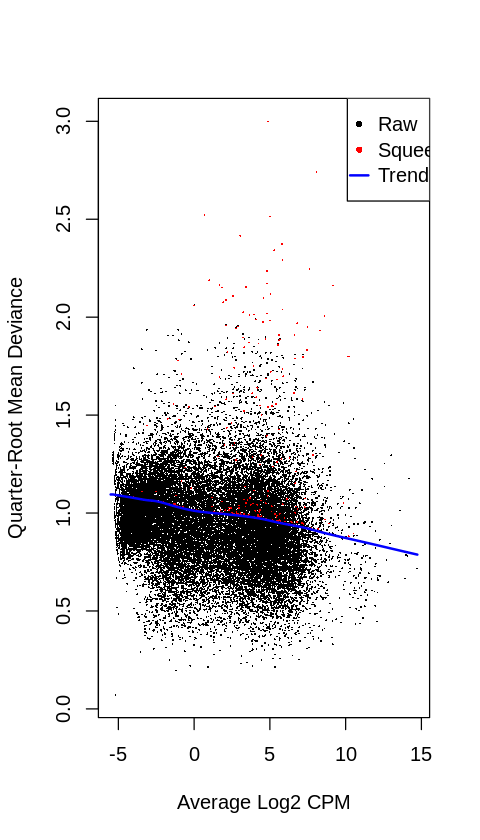

  logFC logCPM   F  PValue   de_gene target   subclass      label plasmid
1 -0.98    6.3 427 1.3e-94     PLIN3  PLIN3 de_control Control DE PLIN3-2
2 -1.43    2.0  52 5.4e-13 TNFAIP8L1  PLIN3 de_control Control DE PLIN3-2
3  0.15   11.2  29 6.2e-08     RPL36  PLIN3 de_control Control DE PLIN3-2
4 -0.82    2.3  26 3.1e-07     UHRF1  PLIN3 de_control Control DE PLIN3-2
5 -0.23    4.8  12 4.4e-04    HDGFL2  PLIN3 de_control Control DE PLIN3-2
6  0.39    2.7  11 8.1e-04     FEM1A  PLIN3 de_control Control DE PLIN3-2
-------------------------------------------------------

TKT : TKT-1a,TKT-1b 
TKT-1a   674 
TKT-1b   683 
[1] "TKT-1a" "TKT-1b"
[1] "TKT-1a" "TKT-2a" "TKT-1b" "TKT-2b"
Vector+ = 901 ; Target- = 25166 ; All = 27142 

donor0 donor1 donor2 donor3 
   224    193    277    207 
[1] 0.0015


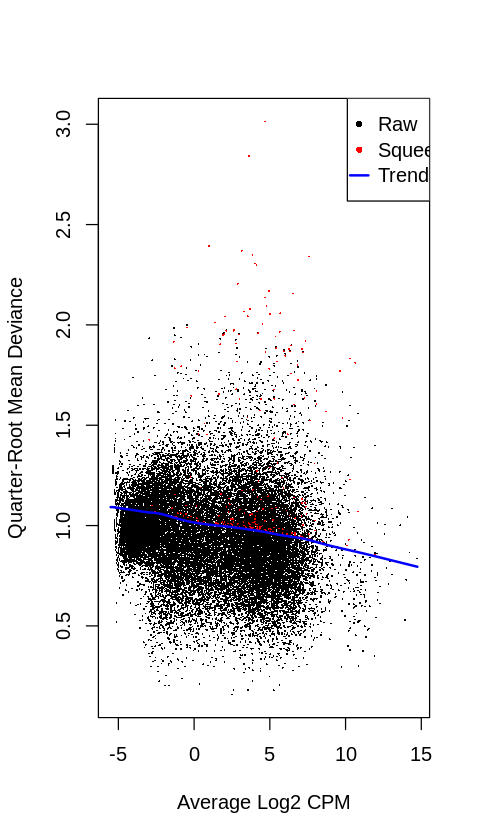

  logFC logCPM     F  PValue de_gene target   subclass      label plasmid
1 -0.69   8.19 358.6 7.5e-80     TKT    TKT de_control Control DE   TKT-1
2 -0.21   4.32   7.9 4.9e-03  NT5DC2    TKT de_control Control DE   TKT-1
3 -0.24   3.82   6.8 9.0e-03 CACNA1D    TKT de_control Control DE   TKT-1
4 -0.69   0.38   4.5 3.3e-02  IL17RB    TKT de_control Control DE   TKT-1
5  3.14  -5.25   2.0 1.6e-01  SEMA3G    TKT de_control Control DE   TKT-1
6  0.12   3.43   1.5 2.3e-01    BAP1    TKT de_control Control DE   TKT-1
-------------------------------------------------------

TKT : TKT-2a,TKT-2b 
TKT-2a   872 
TKT-2b   911 
[1] "TKT-2a" "TKT-2b"
[1] "TKT-1a" "TKT-2a" "TKT-1b" "TKT-2b"
Vector+ = 1167 ; Target- = 25166 ; All = 27142 

donor0 donor1 donor2 donor3 
   271    251    363    282 
[1] 0.0015


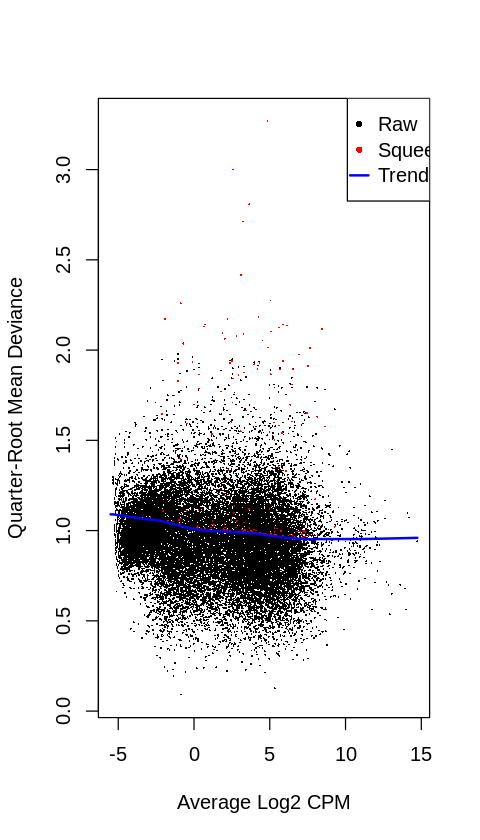

  logFC logCPM     F   PValue de_gene target   subclass      label plasmid
1 -0.75    8.2 469.2 7.8e-104     TKT    TKT de_control Control DE   TKT-2
2 -0.36    3.8  19.0  1.3e-05 CACNA1D    TKT de_control Control DE   TKT-2
3 -0.17    4.8   8.3  4.0e-03  GLT8D1    TKT de_control Control DE   TKT-2
4  0.95   -1.0   7.1  7.7e-03   ITIH4    TKT de_control Control DE   TKT-2
5 -0.17    4.3   6.6  1.0e-02  NT5DC2    TKT de_control Control DE   TKT-2
6 -0.13    5.0   6.0  1.4e-02   DCP1A    TKT de_control Control DE   TKT-2
-------------------------------------------------------

LGALS3 : LGALS3-1a,LGALS3-1b 
LGALS3-1a   912 
LGALS3-1b   864 
[1] "LGALS3-1a" "LGALS3-1b"
[1] "LGALS3-1a" "LGALS3-2a" "LGALS3-1b" "LGALS3-2b"
Vector+ = 1166 ; Target- = 25026 ; All = 27142 

donor0 donor1 donor2 donor3 
   297    214    356    299 
[1] 0.0013


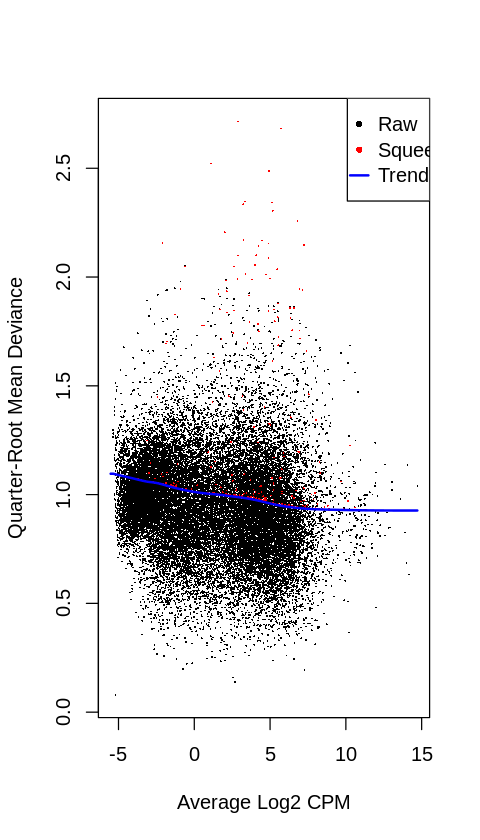

  logFC logCPM      F  PValue   de_gene target   subclass      label  plasmid
1 -1.35    7.9 1709.5 0.0e+00    LGALS3 LGALS3 de_control Control DE LGALS3-1
2 -1.09    3.7  131.8 2.8e-30    DLGAP5 LGALS3 de_control Control DE LGALS3-1
3 -0.94    4.2  134.6 3.4e-25     CDKN3 LGALS3 de_control Control DE LGALS3-1
4 -0.42    3.5   20.4 6.2e-06     WDHD1 LGALS3 de_control Control DE LGALS3-1
5  0.22    3.9    8.9 2.8e-03    CGRRF1 LGALS3 de_control Control DE LGALS3-1
6 -0.11    5.9    7.3 6.9e-03 MAPK1IP1L LGALS3 de_control Control DE LGALS3-1
-------------------------------------------------------

LGALS3 : LGALS3-2a,LGALS3-2b 
LGALS3-2a   811 
LGALS3-2b   783 
[1] "LGALS3-2a" "LGALS3-2b"
[1] "LGALS3-1a" "LGALS3-2a" "LGALS3-1b" "LGALS3-2b"
Vector+ = 1072 ; Target- = 25026 ; All = 27142 

donor0 donor1 donor2 donor3 
   267    214    327    264 
[1] 0.0018


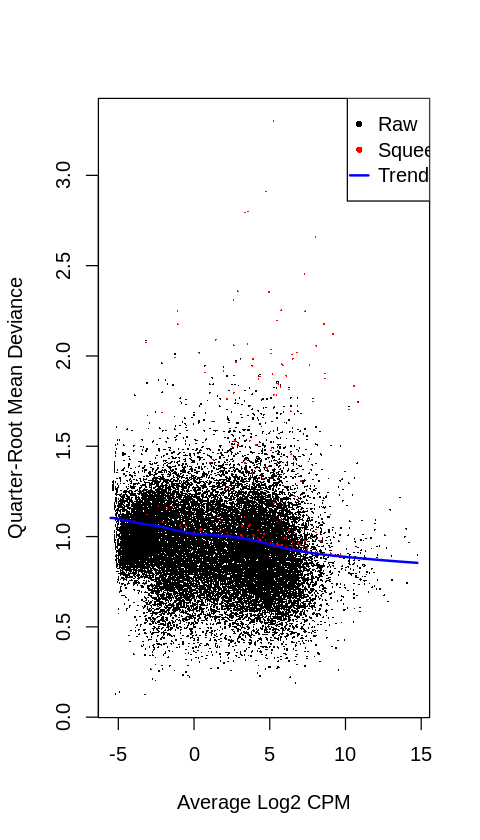

   logFC logCPM      F   PValue   de_gene target   subclass      label  plasmid
1 -1.276    7.9 1319.2 9.0e-285    LGALS3 LGALS3 de_control Control DE LGALS3-2
2 -0.691    4.2   76.2  2.7e-18     CDKN3 LGALS3 de_control Control DE LGALS3-2
3 -0.807    3.7   73.2  1.2e-17    DLGAP5 LGALS3 de_control Control DE LGALS3-2
4  1.135   -1.5    6.5  1.1e-02 LINC00520 LGALS3 de_control Control DE LGALS3-2
5 -0.221    3.5    5.7  1.7e-02     WDHD1 LGALS3 de_control Control DE LGALS3-2
6  0.086    6.6    4.8  2.8e-02    SAMD4A LGALS3 de_control Control DE LGALS3-2
-------------------------------------------------------

CSTB : CSTB-1a,CSTB-1b 
CSTB-1a   968 
CSTB-1b   946 
[1] "CSTB-1a" "CSTB-1b"
[1] "CSTB-1a" "CSTB-2a" "CSTB-1b" "CSTB-2b"
Vector+ = 1254 ; Target- = 24805 ; All = 27142 

donor0 donor1 donor2 donor3 
   288    271    385    310 
[1] 0.0015


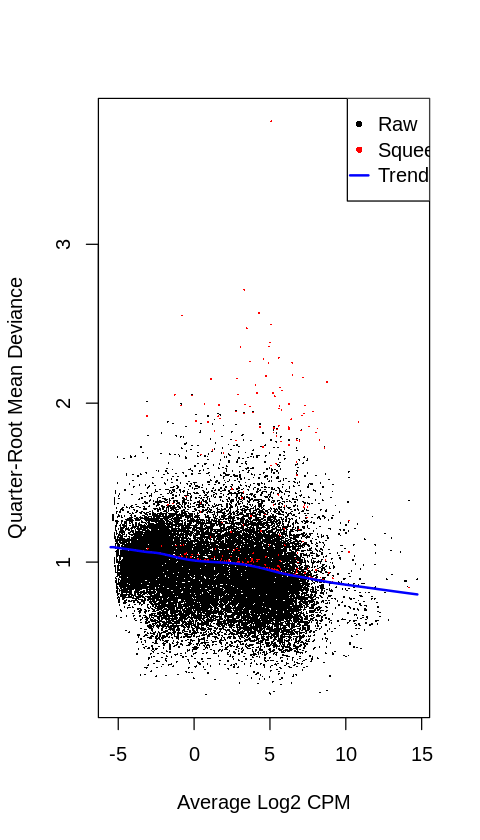

  logFC logCPM     F  PValue   de_gene target   subclass      label plasmid
1 -0.44    8.3 209.7 1.8e-47      CSTB   CSTB de_control Control DE  CSTB-1
2 -0.24    6.6  42.2 8.3e-11      PDXK   CSTB de_control Control DE  CSTB-1
3 -5.89   -3.4   4.4 3.5e-02  ERVH48-1   CSTB de_control Control DE  CSTB-1
4  3.61   -5.2   4.2 4.0e-02 LINC01679   CSTB de_control Control DE  CSTB-1
5  4.21   -5.4   3.8 5.3e-02 LINC00322   CSTB de_control Control DE  CSTB-1
6 -5.06   -3.9   2.4 1.2e-01     AATBC   CSTB de_control Control DE  CSTB-1
-------------------------------------------------------

CSTB : CSTB-2a,CSTB-2b 
CSTB-2a   931 
CSTB-2b   904 
[1] "CSTB-2a" "CSTB-2b"
[1] "CSTB-1a" "CSTB-2a" "CSTB-1b" "CSTB-2b"
Vector+ = 1216 ; Target- = 24805 ; All = 27142 

donor0 donor1 donor2 donor3 
   273    250    380    313 
[1] 0.0017


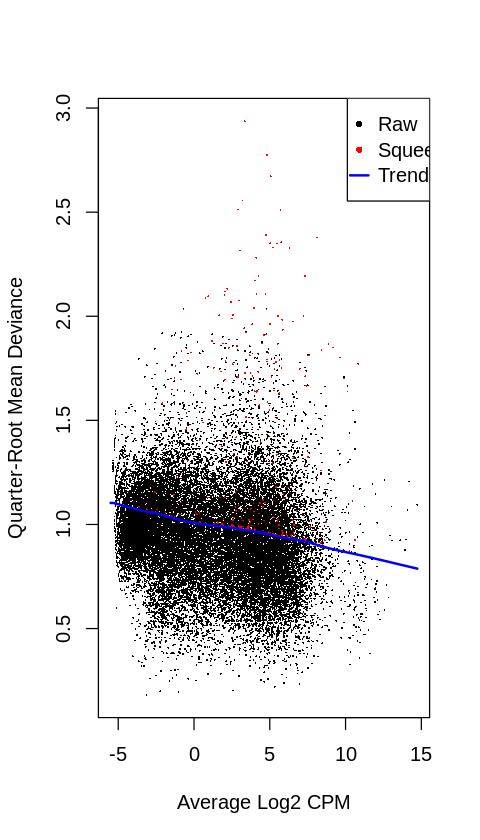

  logFC logCPM     F  PValue   de_gene target   subclass      label plasmid
1 -0.39    8.3 163.1 2.6e-37      CSTB   CSTB de_control Control DE  CSTB-2
2 -0.23    6.6  37.0 1.2e-09      PDXK   CSTB de_control Control DE  CSTB-2
3 -0.19    5.0  11.6 6.7e-04      PFKL   CSTB de_control Control DE  CSTB-2
4  4.23   -5.4   3.7 5.3e-02 LINC01678   CSTB de_control Control DE  CSTB-2
5 -5.07   -3.9   2.4 1.2e-01     AATBC   CSTB de_control Control DE  CSTB-2
6  3.27   -5.3   2.1 1.5e-01 LINC00319   CSTB de_control Control DE  CSTB-2
-------------------------------------------------------

CTSB : CTSB-1a,CTSB-1b 
CTSB-1a   998 
CTSB-1b   925 
[1] "CTSB-1a" "CTSB-1b"
[1] "CTSB-1a" "CTSB-2a" "CTSB-1b" "CTSB-2b"
Vector+ = 1249 ; Target- = 24920 ; All = 27142 

donor0 donor1 donor2 donor3 
   285    266    385    313 
[1] 0.0014


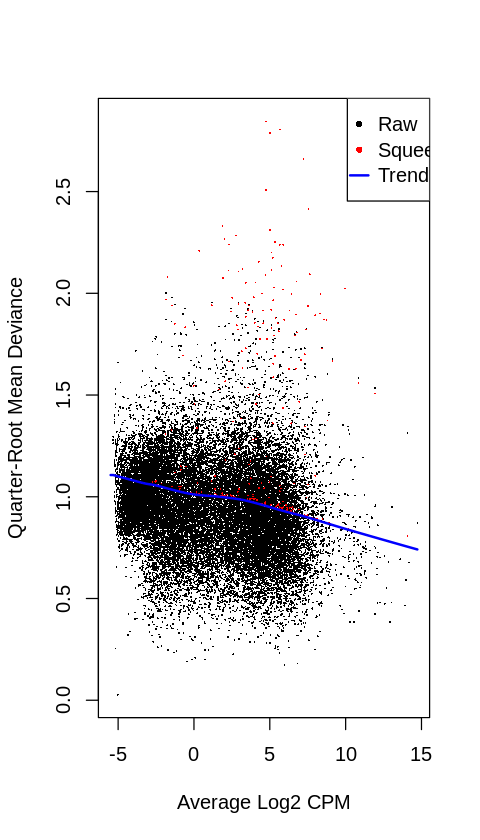

  logFC logCPM     F   PValue de_gene target   subclass      label plasmid
1 -0.94    8.7 949.3 1.9e-200    CTSB   CTSB de_control Control DE  CTSB-1
2 -0.33    6.3  63.8  1.4e-15   FDFT1   CTSB de_control Control DE  CTSB-1
3  0.31    1.8   4.8  2.9e-02  FAM66D   CTSB de_control Control DE  CTSB-1
4 -1.12   -2.0   2.2  1.3e-01 FAM86B2   CTSB de_control Control DE  CTSB-1
5  3.28   -5.3   2.1  1.5e-01 DEFB135   CTSB de_control Control DE  CTSB-1
6  1.36   -3.7   2.1  1.5e-01   GATA4   CTSB de_control Control DE  CTSB-1
-------------------------------------------------------

CTSB : CTSB-2a,CTSB-2b 
CTSB-2a   879 
CTSB-2b   793 
[1] "CTSB-2a" "CTSB-2b"
[1] "CTSB-1a" "CTSB-2a" "CTSB-1b" "CTSB-2b"
Vector+ = 1097 ; Target- = 24920 ; All = 27142 

donor0 donor1 donor2 donor3 
   274    214    322    287 
[1] 0.0017


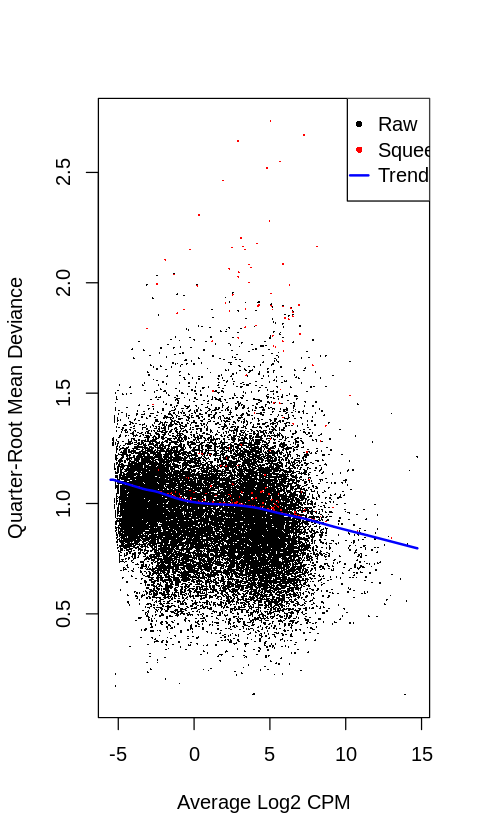

  logFC logCPM     F   PValue     de_gene target   subclass      label plasmid
1 -0.87    8.7 968.6 5.2e-210        CTSB   CTSB de_control Control DE  CTSB-2
2 -0.31    6.3  56.2  6.6e-14       FDFT1   CTSB de_control Control DE  CTSB-2
3  0.33    1.8   4.3  3.9e-02      FAM66D   CTSB de_control Control DE  CTSB-2
4 -5.99   -3.2   4.3  3.9e-02 FAM167A-AS1   CTSB de_control Control DE  CTSB-2
5 -5.20   -3.9   2.4  1.2e-01       GATA4   CTSB de_control Control DE  CTSB-2
6 -5.04   -3.9   2.1  1.4e-01         BLK   CTSB de_control Control DE  CTSB-2
-------------------------------------------------------

KLF6 : KLF6-1a,KLF6-1b 
KLF6-1a   879 
KLF6-1b   877 
[1] "KLF6-1a" "KLF6-1b"
[1] "KLF6-1a" "KLF6-2a" "KLF6-1b" "KLF6-2b"
Vector+ = 1148 ; Target- = 24949 ; All = 27142 

donor0 donor1 donor2 donor3 
   275    242    347    284 
[1] 0.0012


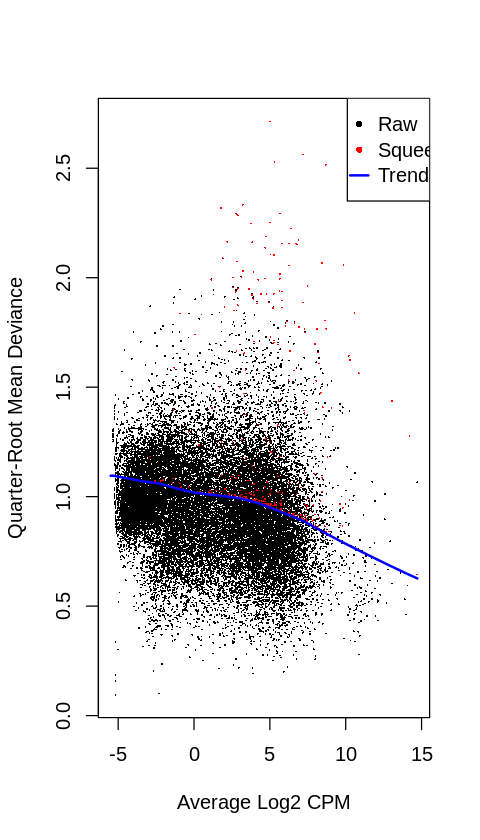

   logFC logCPM     F  PValue    de_gene target   subclass      label plasmid
1 -0.334    7.8 120.4 1.2e-22       KLF6   KLF6 de_control Control DE  KLF6-1
2 -0.173    6.9  26.8 2.3e-07       PFKP   KLF6 de_control Control DE  KLF6-1
3 -0.304    1.1   2.0 1.5e-01 PITRM1-AS1   KLF6 de_control Control DE  KLF6-1
4 -0.093    4.3   2.0 1.6e-01     PITRM1   KLF6 de_control Control DE  KLF6-1
5  0.258    1.1   1.7 1.9e-01      MANCR   KLF6 de_control Control DE  KLF6-1
6 -4.499   -4.3   1.5 2.3e-01  LINC02668   KLF6 de_control Control DE  KLF6-1
-------------------------------------------------------

KLF6 : KLF6-2a,KLF6-2b 
KLF6-2a   926 
KLF6-2b   901 
[1] "KLF6-2a" "KLF6-2b"
[1] "KLF6-1a" "KLF6-2a" "KLF6-1b" "KLF6-2b"
Vector+ = 1168 ; Target- = 24949 ; All = 27142 

donor0 donor1 donor2 donor3 
   279    245    359    285 
[1] 0.0015


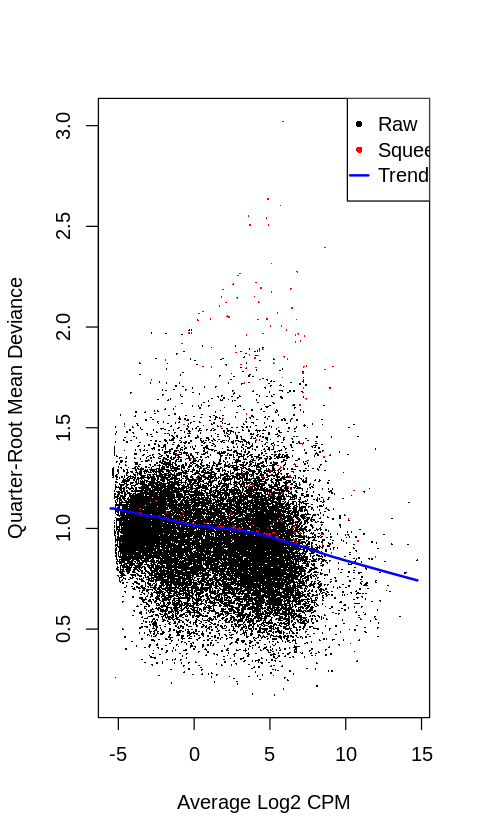

  logFC logCPM     F  PValue   de_gene target   subclass      label plasmid
1 -0.37    7.8 114.4 1.1e-26      KLF6   KLF6 de_control Control DE  KLF6-2
2 -0.24    6.9  39.8 2.9e-10      PFKP   KLF6 de_control Control DE  KLF6-2
3 -2.75   -2.2   5.7 1.7e-02 LINC00705   KLF6 de_control Control DE  KLF6-2
4  0.32    1.1   2.6 1.1e-01     MANCR   KLF6 de_control Control DE  KLF6-2
5 -4.47   -4.3   1.4 2.3e-01 LINC02668   KLF6 de_control Control DE  KLF6-2
6 -0.64   -1.3   1.4 2.4e-01 LINC02669   KLF6 de_control Control DE  KLF6-2
-------------------------------------------------------

DE1 : DE1-1a,DE1-1b 
DE1-1a   862 
DE1-1b   809 
[1] "DE1-1a" "DE1-1b"
[1] "DE1-1a" "DE1-2a" "DE1-1b" "DE1-2b"
Vector+ = 1114 ; Target- = 24904 ; All = 27142 

donor0 donor1 donor2 donor3 
   248    246    334    286 
[1] 0.0017


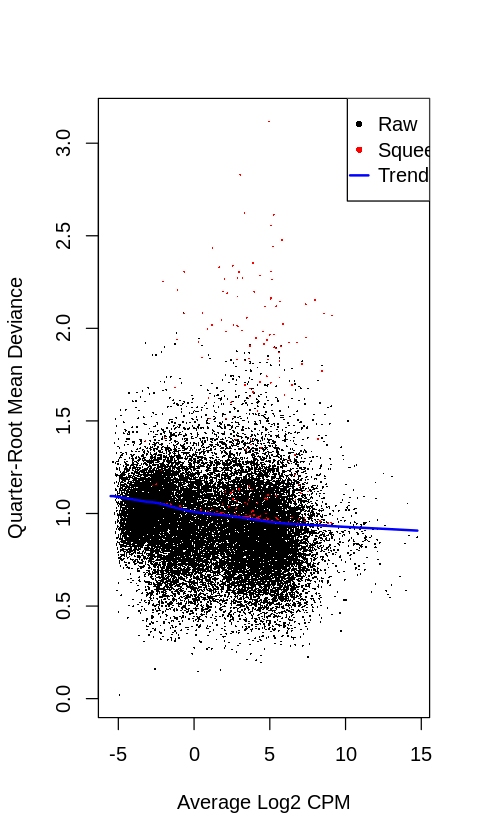

  logFC logCPM     F  PValue    de_gene target subclass  label plasmid
1  0.14    7.7 15.27 9.3e-05      NRIP1    DE1   ckd_de CKD DE   DE1-1
2  0.23    3.4  7.00 8.2e-03     HSPA13    DE1   ckd_de CKD DE   DE1-1
3 -0.13    5.2  6.22 1.3e-02   MIR99AHG    DE1   ckd_de CKD DE   DE1-1
4  0.22    3.3  5.78 1.6e-02  LINC02246    DE1   ckd_de CKD DE   DE1-1
5  0.62   -1.4  1.81 1.8e-01      RBM11    DE1   ckd_de CKD DE   DE1-1
6  1.43   -4.9  0.53 4.7e-01 SAMSN1-AS1    DE1   ckd_de CKD DE   DE1-1
-------------------------------------------------------

DE1 : DE1-2a,DE1-2b 
DE1-2a   939 
DE1-2b   956 
[1] "DE1-2a" "DE1-2b"
[1] "DE1-1a" "DE1-2a" "DE1-1b" "DE1-2b"
Vector+ = 1238 ; Target- = 24904 ; All = 27142 

donor0 donor1 donor2 donor3 
   266    267    393    312 
[1] 0.0016


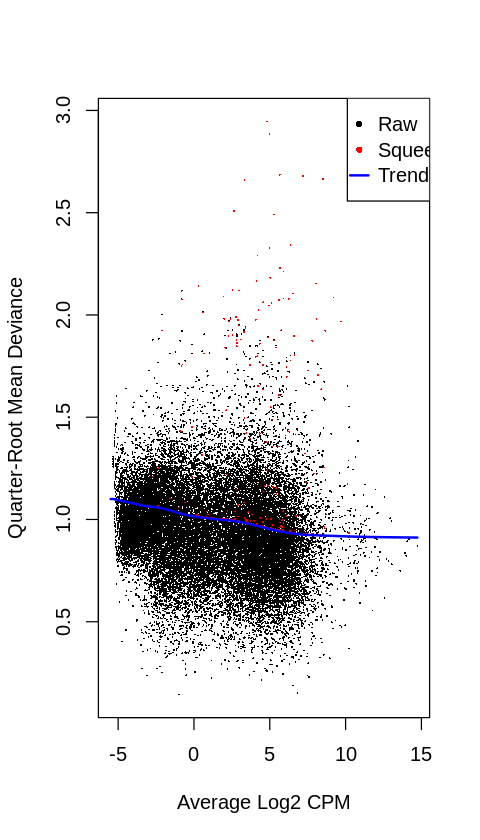

   logFC logCPM     F  PValue   de_gene target subclass  label plasmid
1  0.123    7.7 15.98 6.4e-05     NRIP1    DE1   ckd_de CKD DE   DE1-2
2 -0.197    5.2 15.02 1.1e-04  MIR99AHG    DE1   ckd_de CKD DE   DE1-2
3  0.234    3.4  7.47 6.3e-03    HSPA13    DE1   ckd_de CKD DE   DE1-2
4  0.170    3.3  3.59 5.8e-02 LINC02246    DE1   ckd_de CKD DE   DE1-2
5  0.056    6.4  2.24 1.3e-01     USP25    DE1   ckd_de CKD DE   DE1-2
6 -0.425   -1.5  0.64 4.3e-01    SAMSN1    DE1   ckd_de CKD DE   DE1-2
-------------------------------------------------------

DE2 : DE2-1a,DE2-1b 
DE2-1a   0 
DE2-1b   0 
[1] "DE2-1a" "DE2-1b"
[1] "DE2-1a" "DE2-2a" "DE2-1b" "DE2-2b"
Vector+ = 0 ; Target- = 25910 ; All = 27142 
No cells found: DE2-1a,DE2-1b 
DE2 : DE2-2a,DE2-2b 
DE2-2a   938 
DE2-2b   917 
[1] "DE2-2a" "DE2-2b"
[1] "DE2-1a" "DE2-2a" "DE2-1b" "DE2-2b"
Vector+ = 1232 ; Target- = 25910 ; All = 27142 

donor0 donor1 donor2 donor3 
   294    243    385    310 
[1] 0.0014


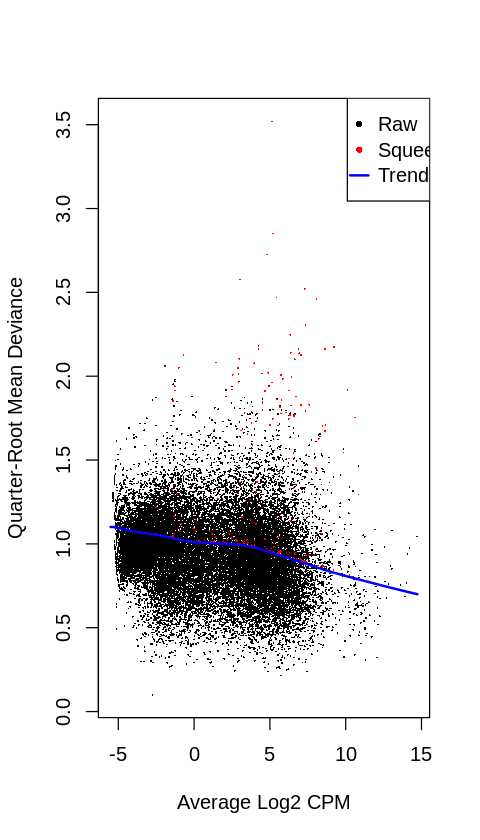

  logFC logCPM    F  PValue   de_gene target subclass  label plasmid
1  1.61  -1.97 12.8 0.00035 LINC02028    DE2   ckd_de CKD DE   DE2-2
2 -0.12   6.52 11.5 0.00071   ATP13A3    DE2   ckd_de CKD DE   DE2-2
3 -0.13   5.85  9.7 0.00181      HES1    DE2   ckd_de CKD DE   DE2-2
4  0.62   0.70  9.5 0.00204    PLAAT1    DE2   ckd_de CKD DE   DE2-2
5 -0.57   0.95  6.3 0.01241 LINC00887    DE2   ckd_de CKD DE   DE2-2
6 -0.21   3.43  5.5 0.01905    TMEM44    DE2   ckd_de CKD DE   DE2-2
-------------------------------------------------------

DE3 : DE3-1a,DE3-1b 
DE3-1a   959 
DE3-1b   969 
[1] "DE3-1a" "DE3-1b"
[1] "DE3-1a" "DE3-2a" "DE3-1b" "DE3-2b"
Vector+ = 1255 ; Target- = 24748 ; All = 27142 

donor0 donor1 donor2 donor3 
   280    284    402    289 
[1] 0.002


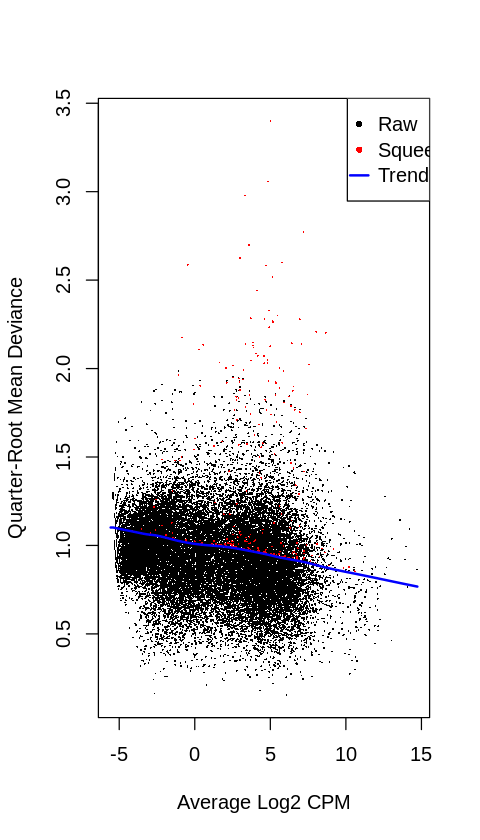

   logFC logCPM    F PValue    de_gene target subclass  label plasmid
1  0.171    3.4 3.75  0.053     HSPA13    DE3   ckd_de CKD DE   DE3-1
2  0.474   -1.4 1.15  0.283      RBM11    DE3   ckd_de CKD DE   DE3-1
3 -0.036    7.6 0.68  0.411      NRIP1    DE3   ckd_de CKD DE   DE3-1
4 -3.091   -5.0 0.54  0.463 SAMSN1-AS1    DE3   ckd_de CKD DE   DE3-1
5  0.026    6.4 0.34  0.560      USP25    DE3   ckd_de CKD DE   DE3-1
6  0.031    3.3 0.11  0.743  LINC02246    DE3   ckd_de CKD DE   DE3-1
-------------------------------------------------------

DE3 : DE3-2a,DE3-2b 
DE3-2a   949 
DE3-2b   976 
[1] "DE3-2a" "DE3-2b"
[1] "DE3-1a" "DE3-2a" "DE3-1b" "DE3-2b"
Vector+ = 1271 ; Target- = 24748 ; All = 27142 

donor0 donor1 donor2 donor3 
   280    256    431    304 
[1] 0.0012


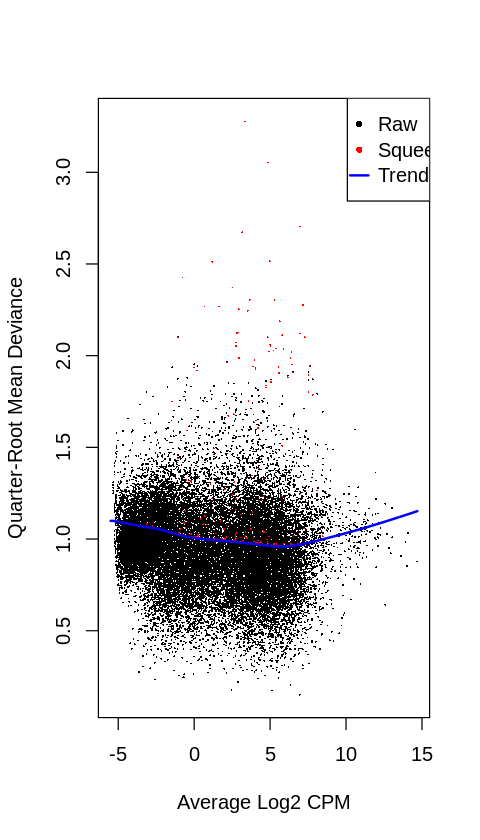

   logFC logCPM    F PValue   de_gene target subclass  label plasmid
1  0.239    3.4 8.15 0.0043    HSPA13    DE3   ckd_de CKD DE   DE3-2
2  0.239    3.3 7.64 0.0057 LINC02246    DE3   ckd_de CKD DE   DE3-2
3 -1.740   -2.4 3.25 0.0713      LIPI    DE3   ckd_de CKD DE   DE3-2
4 -0.052    7.6 2.64 0.1042     NRIP1    DE3   ckd_de CKD DE   DE3-2
5  0.055    6.4 2.17 0.1407     USP25    DE3   ckd_de CKD DE   DE3-2
6 -0.350   -1.5 0.47 0.4948    SAMSN1    DE3   ckd_de CKD DE   DE3-2
-------------------------------------------------------

DE4 : DE4-1a,DE4-1b 
DE4-1a   1623 
DE4-1b   261 
[1] "DE4-1a" "DE4-1b"
[1] "DE4-1a" "DE4-2a" "DE4-1b" "DE4-2b"
Vector+ = 1703 ; Target- = 24595 ; All = 27142 

donor0 donor1 donor2 donor3 
   414    351    518    420 
[1] 0.0011


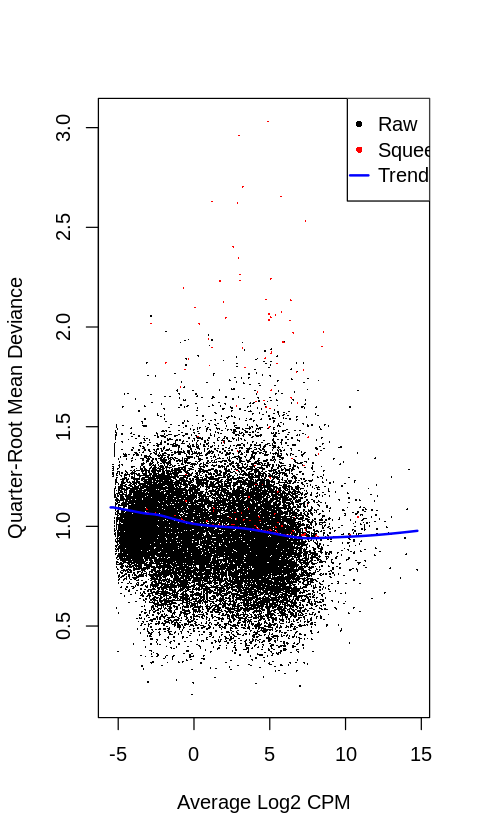

   logFC logCPM     F  PValue   de_gene target subclass  label plasmid
1 -0.847    4.8 211.0 1.2e-29     CCNB1    DE4   ckd_de CKD DE   DE4-1
2  0.139    4.7   7.9 5.0e-03     RAD17    DE4   ckd_de CKD DE   DE4-1
3 -0.085    6.3   6.5 1.1e-02    MRPS36    DE4   ckd_de CKD DE   DE4-1
4 -0.180    3.2   4.6 3.2e-02     CENPH    DE4   ckd_de CKD DE   DE4-1
5 -0.069    5.4   2.9 9.0e-02      TAF9    DE4   ckd_de CKD DE   DE4-1
6  0.969   -3.1   2.1 1.5e-01 LINC02242    DE4   ckd_de CKD DE   DE4-1
-------------------------------------------------------

DE4 : DE4-2a,DE4-2b 
DE4-2a   774 
DE4-2b   697 
[1] "DE4-2a" "DE4-2b"
[1] "DE4-1a" "DE4-2a" "DE4-1b" "DE4-2b"
Vector+ = 985 ; Target- = 24595 ; All = 27142 

donor0 donor1 donor2 donor3 
   218    232    300    235 
[1] 0.002


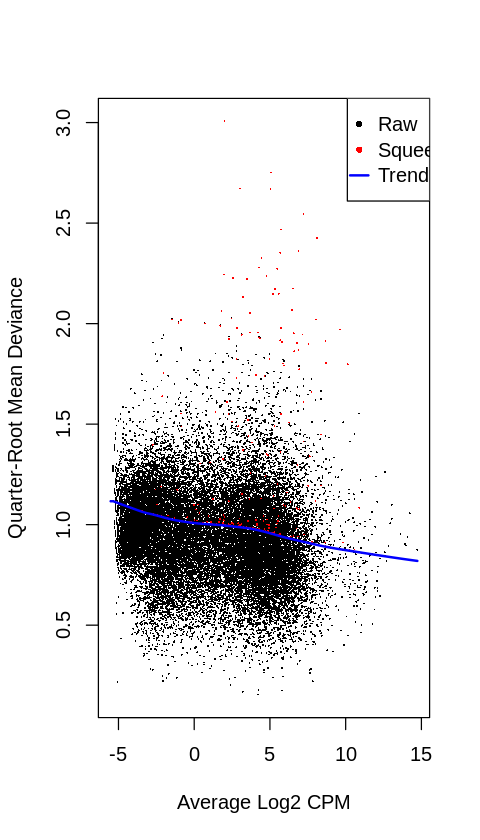

   logFC logCPM     F  PValue de_gene target subclass  label plasmid
1 -0.872    4.8 154.7 1.7e-35   CCNB1    DE4   ckd_de CKD DE   DE4-2
2 -0.351    3.2   9.8 1.7e-03   CENPH    DE4   ckd_de CKD DE   DE4-2
3 -0.211    4.4   8.4 3.8e-03    CDK7    DE4   ckd_de CKD DE   DE4-2
4 -0.136    5.5   6.5 1.1e-02     AK6    DE4   ckd_de CKD DE   DE4-2
5 -0.108    6.1   5.3 2.2e-02  PIK3R1    DE4   ckd_de CKD DE   DE4-2
6 -0.097    6.3   4.6 3.3e-02  MRPS36    DE4   ckd_de CKD DE   DE4-2
-------------------------------------------------------

DE5 : DE5-1a,DE5-1b 
DE5-1a   1003 
DE5-1b   1006 
[1] "DE5-1a" "DE5-1b"
[1] "DE5-1a" "DE5-2a" "DE5-1b" "DE5-2b"
Vector+ = 1299 ; Target- = 24667 ; All = 27142 

donor0 donor1 donor2 donor3 
   303    282    394    320 
[1] 0.0014


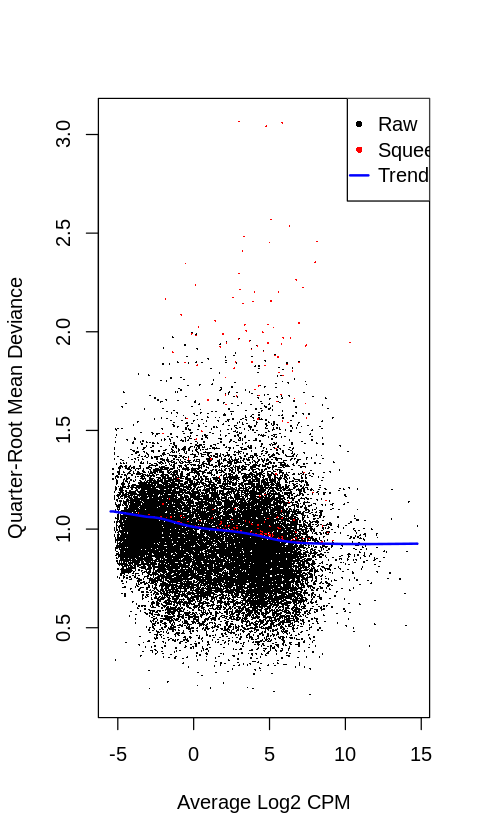

   logFC logCPM     F  PValue   de_gene target subclass  label plasmid
1 -0.463    3.7 30.83 2.8e-08     CHST9    DE5   ckd_de CKD DE   DE5-1
2 -0.262    1.4  2.18 1.4e-01  AQP4-AS1    DE5   ckd_de CKD DE   DE5-1
3  1.252   -3.7  1.84 1.7e-01     PSMA8    DE5   ckd_de CKD DE   DE5-1
4 -1.122   -3.7  0.59 4.4e-01 LINC01543    DE5   ckd_de CKD DE   DE5-1
5  1.363   -5.0  0.47 4.9e-01    PCAT18    DE5   ckd_de CKD DE   DE5-1
6  0.049    3.6  0.37 5.4e-01     TAF4B    DE5   ckd_de CKD DE   DE5-1
-------------------------------------------------------

DE5 : DE5-2a,DE5-2b 
DE5-2a   1053 
DE5-2b   1016 
[1] "DE5-2a" "DE5-2b"
[1] "DE5-1a" "DE5-2a" "DE5-1b" "DE5-2b"
Vector+ = 1332 ; Target- = 24667 ; All = 27142 

donor0 donor1 donor2 donor3 
   302    293    430    307 
[1] 0.0013


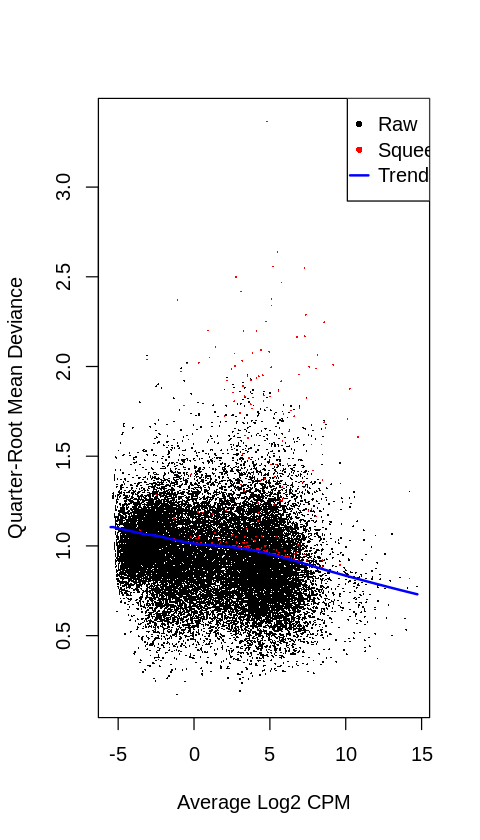

   logFC logCPM     F  PValue   de_gene target subclass  label plasmid
1 -0.487    3.7 32.94 1.6e-08     CHST9    DE5   ckd_de CKD DE   DE5-2
2  0.197    3.6  6.21 1.3e-02     TAF4B    DE5   ckd_de CKD DE   DE5-2
3  2.932   -4.8  4.40 3.6e-02    PCAT18    DE5   ckd_de CKD DE   DE5-2
4  0.066    5.4  2.09 1.5e-01      SS18    DE5   ckd_de CKD DE   DE5-2
5  0.023    5.2  0.23 6.3e-01     KCTD1    DE5   ckd_de CKD DE   DE5-2
6 -1.614   -5.3  0.15 7.0e-01 LINC01908    DE5   ckd_de CKD DE   DE5-2
-------------------------------------------------------

DE6 : DE6-1a,DE6-1b 
DE6-1a   896 
DE6-1b   905 
[1] "DE6-1a" "DE6-1b"
[1] "DE6-1a" "DE6-2a" "DE6-1b" "DE6-2b"
Vector+ = 1189 ; Target- = 24303 ; All = 27142 

donor0 donor1 donor2 donor3 
   286    242    356    305 
[1] 0.0015


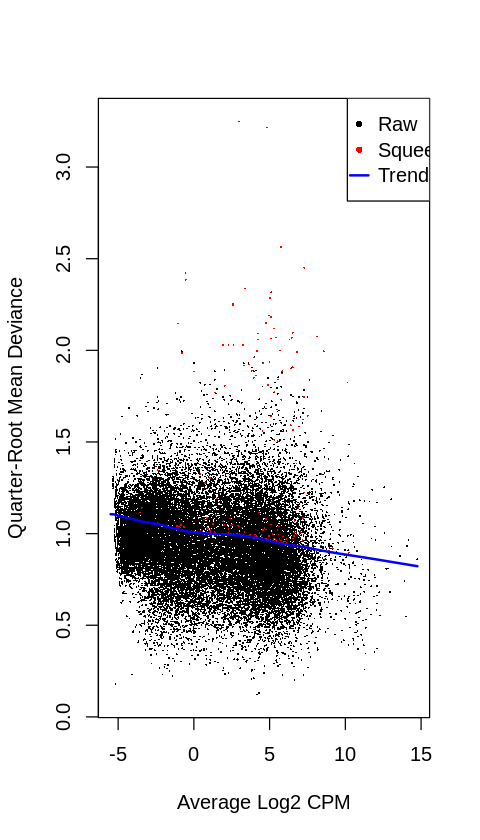

   logFC logCPM      F  PValue de_gene target subclass  label plasmid
1 -1.153  6.019 603.04 3.0e-89   NDRG1    DE6   ckd_de CKD DE   DE6-1
2  0.063  6.145   2.45 1.2e-01 PHF20L1    DE6   ckd_de CKD DE   DE6-1
3  0.858 -2.144   2.44 1.2e-01   HPYR1    DE6   ckd_de CKD DE   DE6-1
4  0.109  2.520   0.84 3.6e-01      TG    DE6   ckd_de CKD DE   DE6-1
5  0.055  4.453   0.77 3.8e-01   KCNQ3    DE6   ckd_de CKD DE   DE6-1
6 -0.218 -0.055   0.49 4.8e-01    CCN4    DE6   ckd_de CKD DE   DE6-1
-------------------------------------------------------

DE6 : DE6-2a,DE6-2b 
DE6-2a   1814 
DE6-2b   32 
[1] "DE6-2a" "DE6-2b"
[1] "DE6-1a" "DE6-2a" "DE6-1b" "DE6-2b"
Vector+ = 1825 ; Target- = 24303 ; All = 27142 

donor0 donor1 donor2 donor3 
   447    384    532    462 
[1] 0.0013


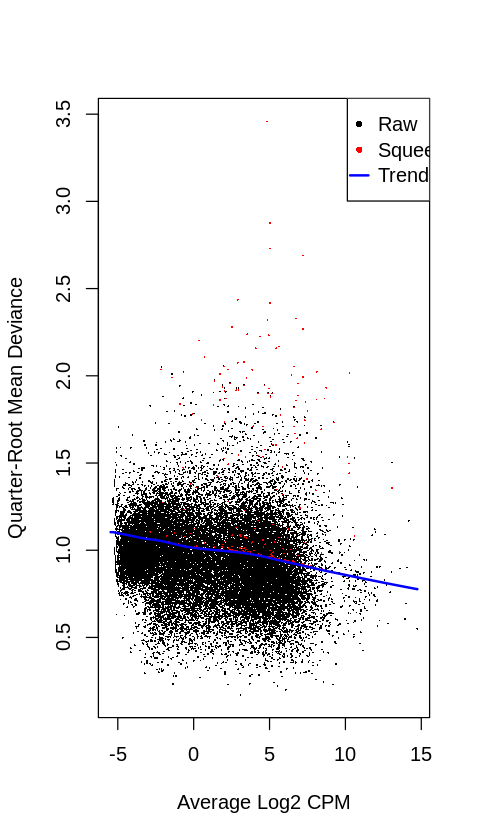

   logFC logCPM     F   PValue de_gene target subclass  label plasmid
1 -0.954  6.034 608.9 6.4e-134   NDRG1    DE6   ckd_de CKD DE   DE6-2
2  0.466 -0.624   2.8  9.3e-02  TMEM71    DE6   ckd_de CKD DE   DE6-2
3  0.143  2.529   2.1  1.5e-01      TG    DE6   ckd_de CKD DE   DE6-2
4  0.045  6.142   1.6  2.0e-01 PHF20L1    DE6   ckd_de CKD DE   DE6-2
5  0.035  6.776   1.2  2.7e-01 ST3GAL1    DE6   ckd_de CKD DE   DE6-2
6  0.227 -0.098   0.9  3.4e-01     SLA    DE6   ckd_de CKD DE   DE6-2
-------------------------------------------------------

DE7 : DE7-1a,DE7-1b 
DE7-1a   1010 
DE7-1b   965 
[1] "DE7-1a" "DE7-1b"
[1] "DE7-1a" "DE7-2a" "DE7-1b" "DE7-2b"
Vector+ = 1296 ; Target- = 24868 ; All = 27142 

donor0 donor1 donor2 donor3 
   298    281    422    295 
[1] 0.0013


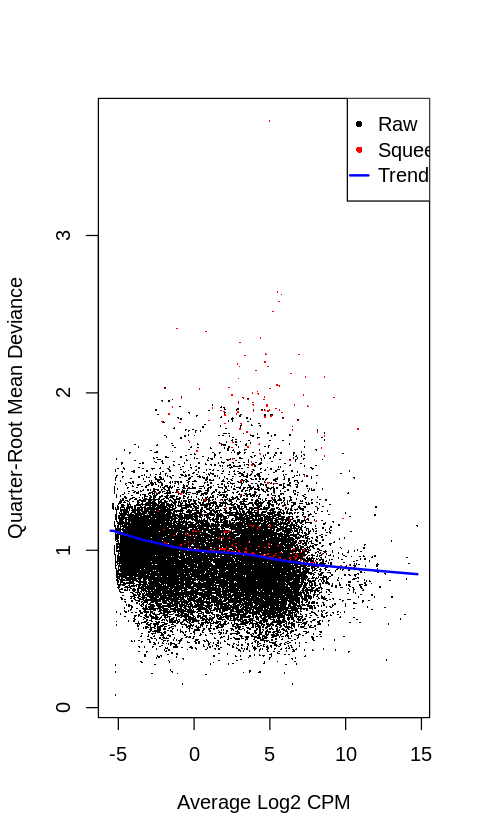

   logFC logCPM     F  PValue   de_gene target subclass  label plasmid
1 -0.722    4.9 156.6 7.5e-36      STC1    DE7   ckd_de CKD DE   DE7-1
2 -0.367    5.6  64.1 1.3e-15     LOXL2    DE7   ckd_de CKD DE   DE7-1
3 -0.582    2.9  27.4 1.6e-07    ADAM28    DE7   ckd_de CKD DE   DE7-1
4  0.155    6.6  19.6 9.8e-06 TNFRSF10B    DE7   ckd_de CKD DE   DE7-1
5  0.213    4.3  11.7 6.2e-04 TNFRSF10A    DE7   ckd_de CKD DE   DE7-1
6  0.084    6.5   5.6 1.8e-02  SLC25A37    DE7   ckd_de CKD DE   DE7-1
-------------------------------------------------------

DE7 : DE7-2a,DE7-2b 
DE7-2a   832 
DE7-2b   774 
[1] "DE7-2a" "DE7-2b"
[1] "DE7-1a" "DE7-2a" "DE7-1b" "DE7-2b"
Vector+ = 1076 ; Target- = 24868 ; All = 27142 

donor0 donor1 donor2 donor3 
   232    220    328    296 
[1] 0.0015


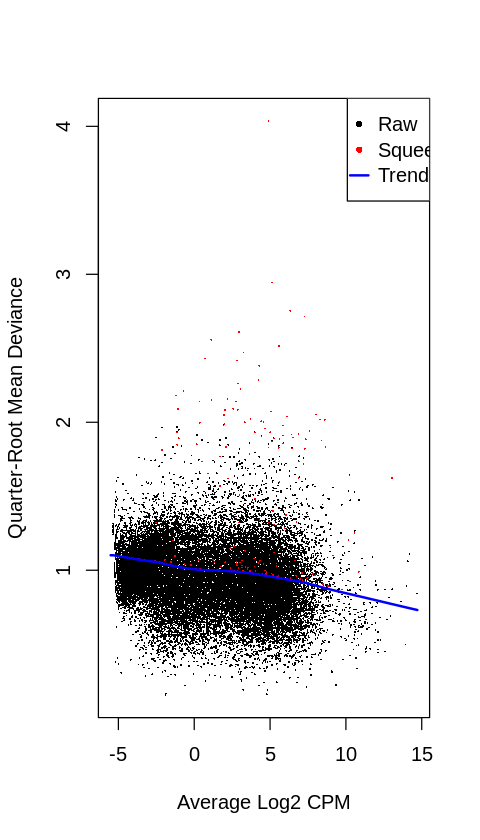

  logFC logCPM    F  PValue   de_gene target subclass  label plasmid
1 -0.39    5.6 60.5 7.6e-15     LOXL2    DE7   ckd_de CKD DE   DE7-2
2 -0.46    5.0 58.1 2.6e-14      STC1    DE7   ckd_de CKD DE   DE7-2
3  0.22    6.6 31.7 1.8e-08 TNFRSF10B    DE7   ckd_de CKD DE   DE7-2
4 -0.70    2.9 31.2 2.4e-08    ADAM28    DE7   ckd_de CKD DE   DE7-2
5 -0.14    5.6  8.3 3.9e-03 TNFRSF10D    DE7   ckd_de CKD DE   DE7-2
6  0.08    6.5  4.1 4.2e-02  SLC25A37    DE7   ckd_de CKD DE   DE7-2
-------------------------------------------------------

DE8 : DE8-1a,DE8-1b 
DE8-1a   974 
DE8-1b   1056 
[1] "DE8-1a" "DE8-1b"
[1] "DE8-1a" "DE8-2a" "DE8-1b" "DE8-2b"
Vector+ = 1340 ; Target- = 24522 ; All = 27142 

donor0 donor1 donor2 donor3 
   301    301    411    327 
[1] 0.0014


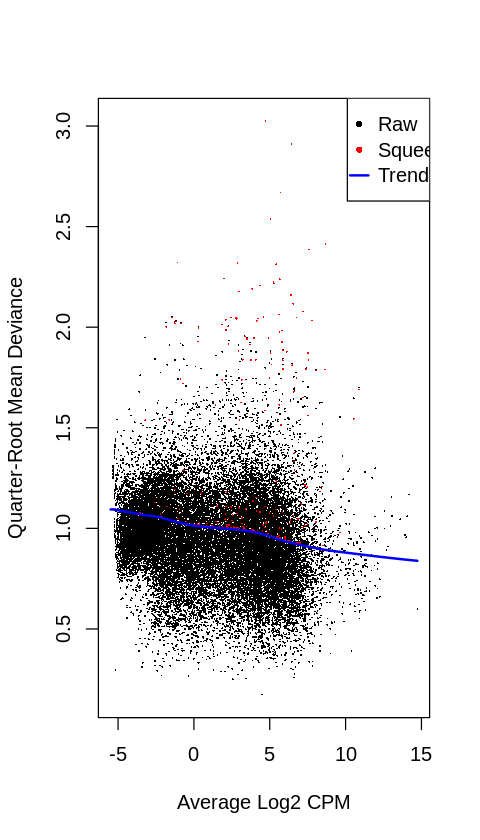

   logFC logCPM     F  PValue   de_gene target subclass  label plasmid
1 -0.253   5.69 34.22 4.9e-09  PPARGC1A    DE8   ckd_de CKD DE   DE8-1
2 -0.094   5.72  4.93 2.6e-02     DHX15    DE8   ckd_de CKD DE   DE8-1
3 -5.175  -3.87  2.81 9.4e-02 LINC02473    DE8   ckd_de CKD DE   DE8-1
4 -0.288  -0.52  0.69 4.1e-01    ERVH-1    DE8   ckd_de CKD DE   DE8-1
-------------------------------------------------------

DE8 : DE8-2a,DE8-2b 
DE8-2a   1124 
DE8-2b   1104 
[1] "DE8-2a" "DE8-2b"
[1] "DE8-1a" "DE8-2a" "DE8-1b" "DE8-2b"
Vector+ = 1473 ; Target- = 24522 ; All = 27142 

donor0 donor1 donor2 donor3 
   358    313    445    357 
[1] 0.0011


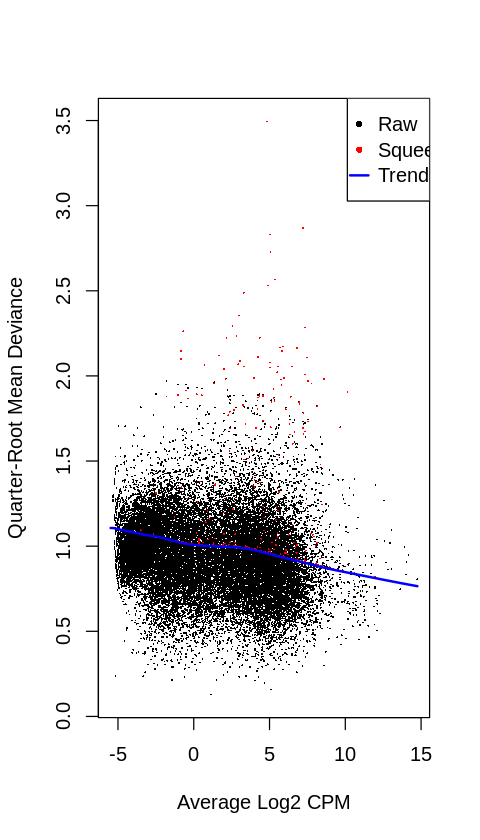

   logFC logCPM      F  PValue   de_gene target subclass  label plasmid
1 -0.169   5.71 17.481 2.9e-05  PPARGC1A    DE8   ckd_de CKD DE   DE8-2
2 -0.140   5.70 11.962 5.4e-04     DHX15    DE8   ckd_de CKD DE   DE8-2
3 -0.097  -0.52  0.091 7.6e-01    ERVH-1    DE8   ckd_de CKD DE   DE8-2
4 -0.142  -3.83  0.014 9.1e-01 LINC02473    DE8   ckd_de CKD DE   DE8-2
-------------------------------------------------------

DE9 : DE9-1a,DE9-1b 
DE9-1a   933 
DE9-1b   1012 
[1] "DE9-1a" "DE9-1b"
[1] "DE9-1a" "DE9-2a" "DE9-1b" "DE9-2b"
Vector+ = 1296 ; Target- = 25846 ; All = 27142 

donor0 donor1 donor2 donor3 
   264    288    412    332 
[1] 0.0013


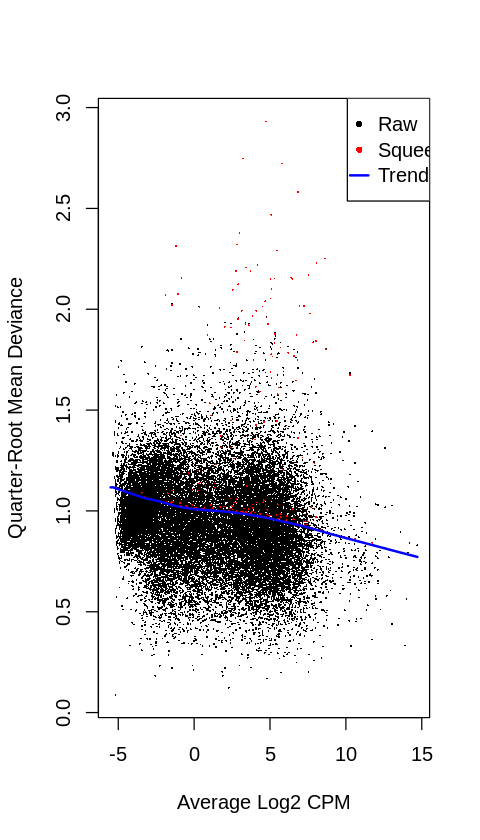

  logFC logCPM    F  PValue de_gene target subclass  label plasmid
1 -0.14    6.3 12.1 0.00051  SUPT3H    DE9   ckd_de CKD DE   DE9-1
2 -0.12    6.9 11.8 0.00060  MRPL14    DE9   ckd_de CKD DE   DE9-1
3 -0.10    6.7  7.3 0.00696   DNPH1    DE9   ckd_de CKD DE   DE9-1
4  0.11    6.0  7.0 0.00836   VEGFA    DE9   ckd_de CKD DE   DE9-1
5  0.21    3.5  6.8 0.00920  GTPBP2    DE9   ckd_de CKD DE   DE9-1
6  0.16    4.3  6.8 0.00928    POLH    DE9   ckd_de CKD DE   DE9-1
-------------------------------------------------------

DE9 : DE9-2a,DE9-2b 
DE9-2a   0 
DE9-2b   0 
[1] "DE9-2a" "DE9-2b"
[1] "DE9-1a" "DE9-2a" "DE9-1b" "DE9-2b"
Vector+ = 0 ; Target- = 25846 ; All = 27142 
No cells found: DE9-2a,DE9-2b 
DE10 : DE10-1a,DE10-1b 
DE10-1a   735 
DE10-1b   682 
[1] "DE10-1a" "DE10-1b"
[1] "DE10-1a" "DE10-2a" "DE10-1b" "DE10-2b"
Vector+ = 953 ; Target- = 25213 ; All = 27142 

donor0 donor1 donor2 donor3 
   224    208    284    237 
[1] 0.0017


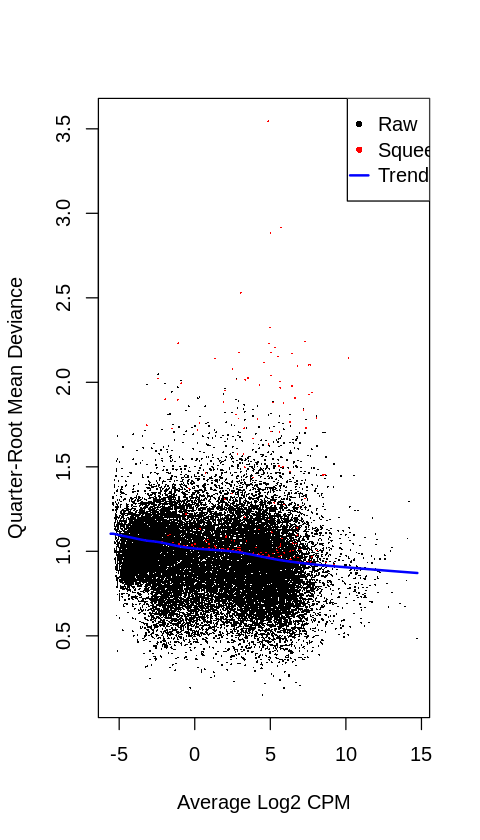

   logFC logCPM    F  PValue de_gene target subclass  label plasmid
1 -0.228    7.9 44.2 3.0e-11   PDIA6   DE10   ckd_de CKD DE  DE10-1
2 -0.194    5.8 16.2 5.7e-05  HPCAL1   DE10   ckd_de CKD DE  DE10-1
3 -0.090    6.8  5.1 2.4e-02    ODC1   DE10   ckd_de CKD DE  DE10-1
4  1.676   -3.9  2.5 1.1e-01 C2orf50   DE10   ckd_de CKD DE  DE10-1
5  0.055    6.3  1.6 2.0e-01   ROCK2   DE10   ckd_de CKD DE  DE10-1
6 -0.066    4.9  1.2 2.8e-01   LPIN1   DE10   ckd_de CKD DE  DE10-1
-------------------------------------------------------

DE10 : DE10-2a,DE10-2b 
DE10-2a   797 
DE10-2b   805 
[1] "DE10-2a" "DE10-2b"
[1] "DE10-1a" "DE10-2a" "DE10-1b" "DE10-2b"
Vector+ = 1059 ; Target- = 25213 ; All = 27142 

donor0 donor1 donor2 donor3 
   245    225    332    257 
[1] 0.002


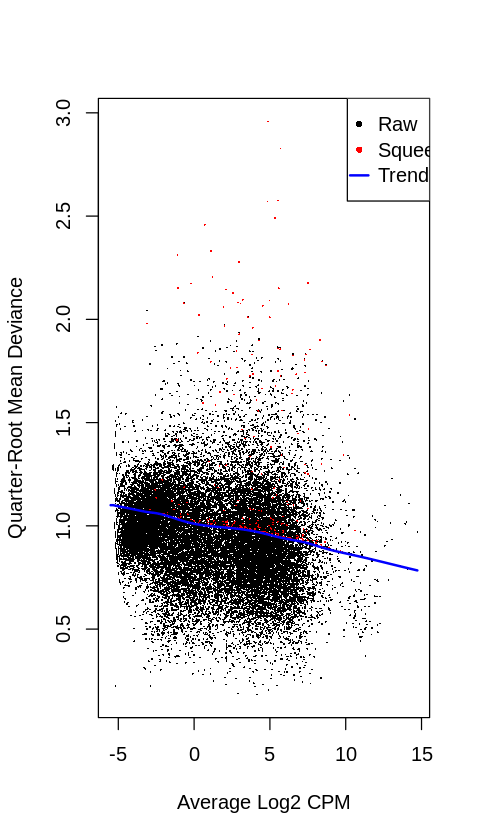

   logFC logCPM    F  PValue de_gene target subclass  label plasmid
1 -0.159    7.9 20.9 4.9e-06   PDIA6   DE10   ckd_de CKD DE  DE10-2
2 -0.093    5.8  3.8 5.0e-02  HPCAL1   DE10   ckd_de CKD DE  DE10-2
3  0.892   -1.6  3.5 6.3e-02   GREB1   DE10   ckd_de CKD DE  DE10-2
4  0.124    3.7  2.2 1.4e-01 SLC66A3   DE10   ckd_de CKD DE  DE10-2
5 -0.085    4.9  2.0 1.6e-01   LPIN1   DE10   ckd_de CKD DE  DE10-2
6  0.061    6.3  2.0 1.6e-01   ROCK2   DE10   ckd_de CKD DE  DE10-2
-------------------------------------------------------

DE11 : DE11-1a,DE11-1b 
DE11-1a   978 
DE11-1b   785 
[1] "DE11-1a" "DE11-1b"
[1] "DE11-1a" "DE11-2a" "DE11-1b" "DE11-2b"
Vector+ = 1220 ; Target- = 24924 ; All = 27142 

donor0 donor1 donor2 donor3 
   314    263    355    288 
[1] 0.0015


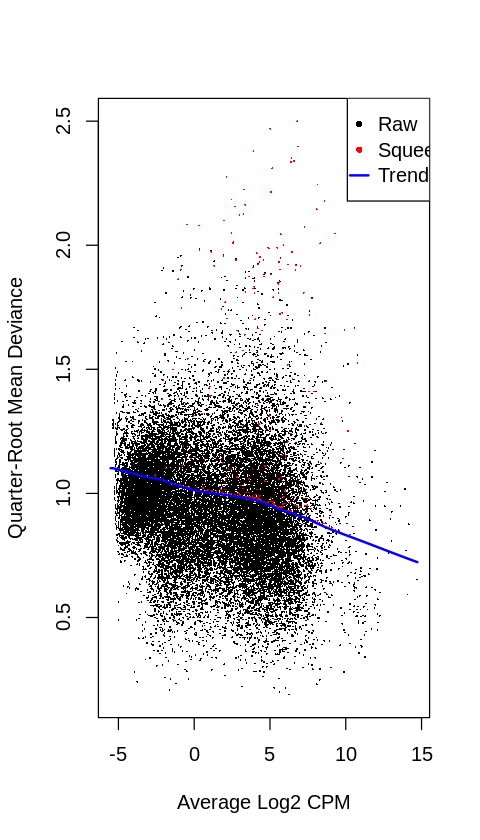

   logFC logCPM    F  PValue de_gene target subclass  label plasmid
1 -0.167    6.5 18.6 1.7e-05 GALNT11   DE11   ckd_de CKD DE  DE11-1
2 -0.648    1.3 10.2 1.4e-03   XRCC2   DE11   ckd_de CKD DE  DE11-1
3  0.859   -0.5  8.2 4.2e-03   WDR86   DE11   ckd_de CKD DE  DE11-1
4  0.202    3.5  5.9 1.5e-02   CHPF2   DE11   ckd_de CKD DE  DE11-1
5  0.152    4.1  4.8 2.8e-02    CDK5   DE11   ckd_de CKD DE  DE11-1
6  0.068    7.0  3.6 5.8e-02   KMT2C   DE11   ckd_de CKD DE  DE11-1
-------------------------------------------------------

DE11 : DE11-2a,DE11-2b 
DE11-2a   858 
DE11-2b   815 
[1] "DE11-2a" "DE11-2b"
[1] "DE11-1a" "DE11-2a" "DE11-1b" "DE11-2b"
Vector+ = 1106 ; Target- = 24924 ; All = 27142 

donor0 donor1 donor2 donor3 
   267    234    327    278 
[1] 0.0015


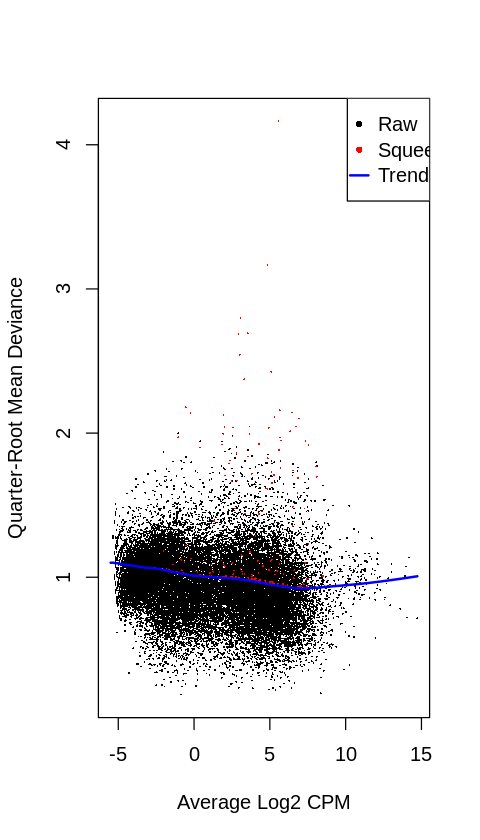

   logFC logCPM    F  PValue de_gene target subclass  label plasmid
1 -0.151   6.49 14.1 0.00018 GALNT11   DE11   ckd_de CKD DE  DE11-2
2 -0.683   1.33 10.0 0.00155   XRCC2   DE11   ckd_de CKD DE  DE11-2
3 -1.018  -0.61  4.9 0.02630   WDR86   DE11   ckd_de CKD DE  DE11-2
4  0.140   3.50  2.5 0.11448   CHPF2   DE11   ckd_de CKD DE  DE11-2
5  0.103   4.40  2.4 0.11825  SLC4A2   DE11   ckd_de CKD DE  DE11-2
6  0.093   4.78  2.4 0.11880   TMUB1   DE11   ckd_de CKD DE  DE11-2
-------------------------------------------------------

DE12 : DE12-1a,DE12-1b 
DE12-1a   868 
DE12-1b   862 
[1] "DE12-1a" "DE12-1b"
[1] "DE12-1a" "DE12-2a" "DE12-1b" "DE12-2b"
Vector+ = 1119 ; Target- = 25036 ; All = 27142 

donor0 donor1 donor2 donor3 
   274    234    329    282 
[1] 0.002


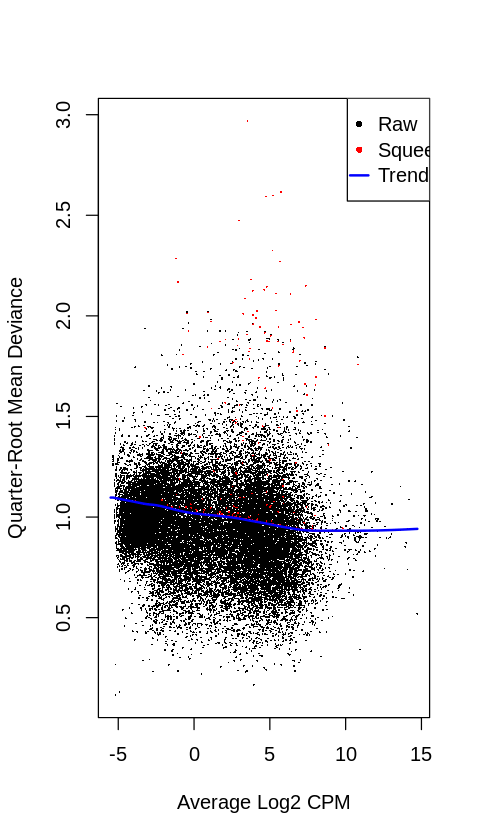

  logFC logCPM    F  PValue de_gene target subclass  label plasmid
1 -0.38   5.18 43.1 5.3e-11 SHROOM3   DE12   ckd_de CKD DE  DE12-1
2 -3.60  -0.48 27.6 1.5e-07  CXCL10   DE12   ckd_de CKD DE  DE12-1
3 -0.37   4.13 22.5 2.1e-06   CCNG2   DE12   ckd_de CKD DE  DE12-1
4  0.22   4.06  8.9 2.8e-03   THAP6   DE12   ckd_de CKD DE  DE12-1
5 -1.62  -1.41  5.4 2.0e-02  CXCL11   DE12   ckd_de CKD DE  DE12-1
6 -0.10   5.97  4.8 2.8e-02    USO1   DE12   ckd_de CKD DE  DE12-1
-------------------------------------------------------

DE12 : DE12-2a,DE12-2b 
DE12-2a   795 
DE12-2b   806 
[1] "DE12-2a" "DE12-2b"
[1] "DE12-1a" "DE12-2a" "DE12-1b" "DE12-2b"
Vector+ = 1075 ; Target- = 25036 ; All = 27142 

donor0 donor1 donor2 donor3 
   232    233    344    266 
[1] 0.0017


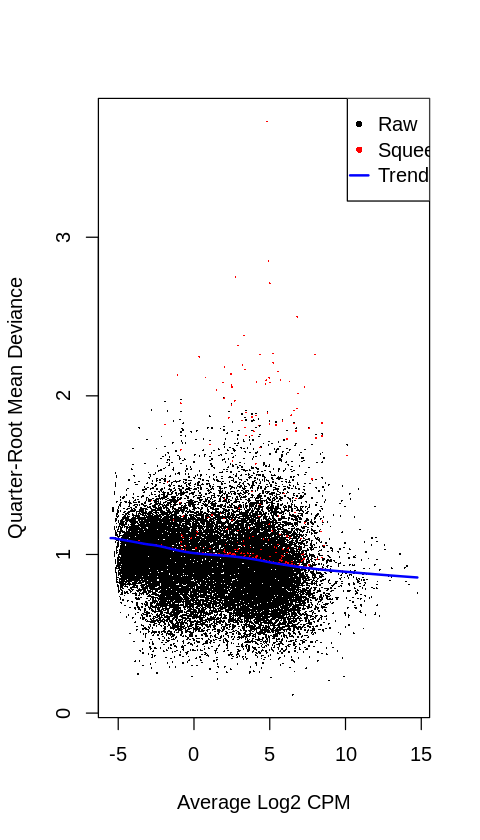

  logFC logCPM    F  PValue de_gene target subclass  label plasmid
1 -2.97  -0.47 22.4 2.2e-06  CXCL10   DE12   ckd_de CKD DE  DE12-2
2 -0.24   5.22 18.5 1.7e-05 SHROOM3   DE12   ckd_de CKD DE  DE12-2
3 -8.07  -1.43 18.5 1.7e-05  CXCL11   DE12   ckd_de CKD DE  DE12-2
4 -0.27   4.15 12.7 3.6e-04   CCNG2   DE12   ckd_de CKD DE  DE12-2
5  0.13   5.47  6.3 1.2e-02   SDAD1   DE12   ckd_de CKD DE  DE12-2
6  0.16   4.04  4.8 2.8e-02   THAP6   DE12   ckd_de CKD DE  DE12-2
-------------------------------------------------------

DE13 : DE13-1a,DE13-1b 
DE13-1a   797 
DE13-1b   102 
[1] "DE13-1a" "DE13-1b"
[1] "DE13-1a" "DE13-2a" "DE13-1b" "DE13-2b"
Vector+ = 824 ; Target- = 25503 ; All = 27142 

donor0 donor1 donor2 donor3 
   198    155    244    227 
[1] 0.0016


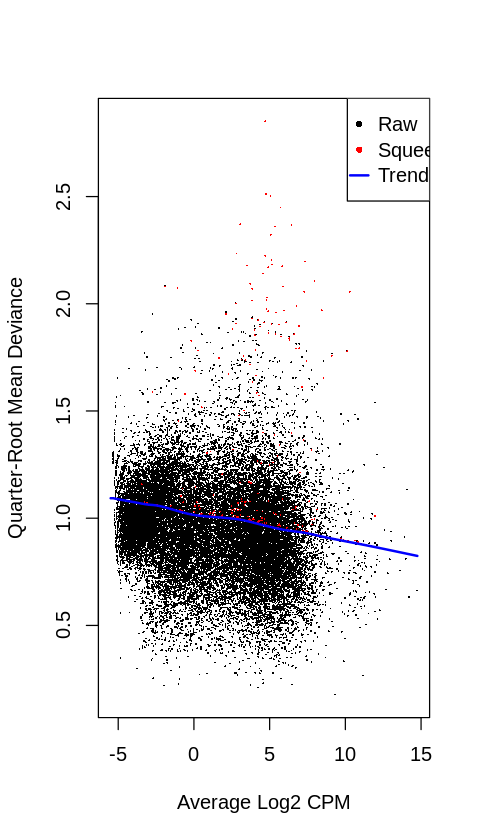

   logFC logCPM    F  PValue   de_gene target subclass  label plasmid
1 -0.428    4.3 26.1 3.3e-07     CENPW   DE13   ckd_de CKD DE  DE13-1
2 -0.142    5.6  6.9 8.5e-03     HDDC2   DE13   ckd_de CKD DE  DE13-1
3 -0.092    5.7  3.1 8.0e-02     NCOA7   DE13   ckd_de CKD DE  DE13-1
4  0.131    4.1  2.6 1.1e-01     HINT3   DE13   ckd_de CKD DE  DE13-1
5  2.175   -4.6  2.1 1.5e-01 LINC02523   DE13   ckd_de CKD DE  DE13-1
6 -0.063    6.6  2.1 1.5e-01   TPD52L1   DE13   ckd_de CKD DE  DE13-1
-------------------------------------------------------

DE13 : DE13-2a,DE13-2b 
DE13-2a   670 
DE13-2b   649 
[1] "DE13-2a" "DE13-2b"
[1] "DE13-1a" "DE13-2a" "DE13-1b" "DE13-2b"
Vector+ = 885 ; Target- = 25503 ; All = 27142 

donor0 donor1 donor2 donor3 
   184    182    291    228 
[1] 0.0014


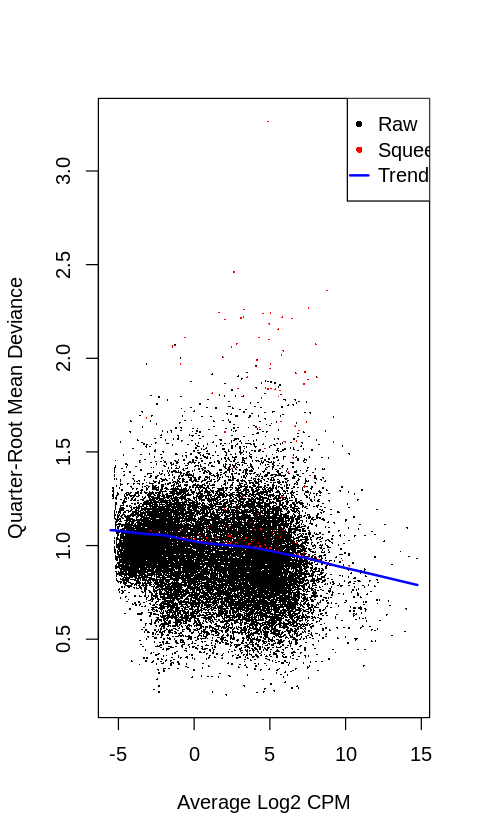

   logFC logCPM    F  PValue   de_gene target subclass  label plasmid
1 -0.385   4.29 23.4 1.3e-06     CENPW   DE13   ckd_de CKD DE  DE13-2
2 -0.090   6.57  5.0 2.5e-02   TPD52L1   DE13   ckd_de CKD DE  DE13-2
3 -1.039  -0.54  4.5 3.4e-02 NCOA7-AS1   DE13   ckd_de CKD DE  DE13-2
4  0.078   6.28  3.4 6.4e-02    TRMT11   DE13   ckd_de CKD DE  DE13-2
5  0.123   4.14  2.5 1.1e-01     HINT3   DE13   ckd_de CKD DE  DE13-2
6 -0.079   5.64  2.5 1.2e-01     HDDC2   DE13   ckd_de CKD DE  DE13-2
-------------------------------------------------------

DE14 : DE14-1a,DE14-1b 
DE14-1a   941 
DE14-1b   975 
[1] "DE14-1a" "DE14-1b"
[1] "DE14-1a" "DE14-2a" "DE14-1b" "DE14-2b"
Vector+ = 1250 ; Target- = 24910 ; All = 27142 

donor0 donor1 donor2 donor3 
   304    256    377    313 
[1] 0.0014


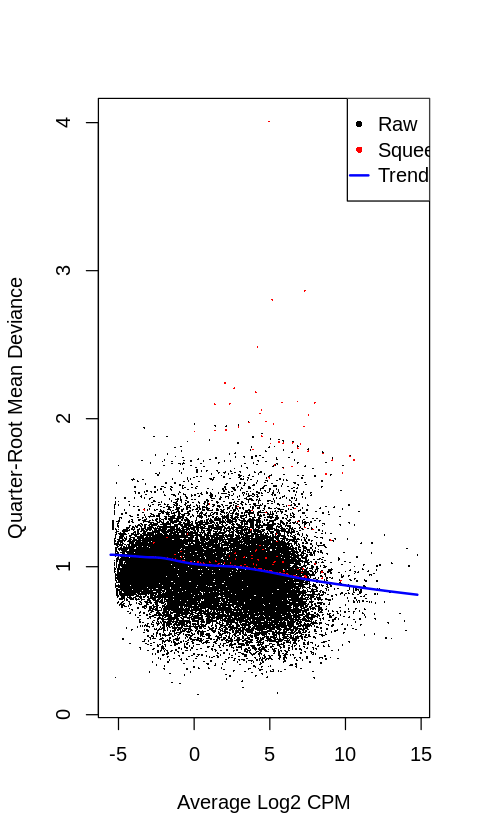

   logFC logCPM    F  PValue de_gene target subclass  label plasmid
1 -0.280   4.34 17.7 2.7e-05   FKBP9   DE14   ckd_de CKD DE  DE14-1
2 -0.363   3.51 16.1 6.1e-05   PDE1C   DE14   ckd_de CKD DE  DE14-1
3  0.342   0.67  2.6 1.1e-01   BMPER   DE14   ckd_de CKD DE  DE14-1
4 -0.046   6.15  1.3 2.5e-01    AVL9   DE14   ckd_de CKD DE  DE14-1
5  0.049   5.81  1.3 2.6e-01    BBS9   DE14   ckd_de CKD DE  DE14-1
6 -0.052   5.42  1.2 2.7e-01  NT5C3A   DE14   ckd_de CKD DE  DE14-1
-------------------------------------------------------

DE14 : DE14-2a,DE14-2b 
DE14-2a   872 
DE14-2b   824 
[1] "DE14-2a" "DE14-2b"
[1] "DE14-1a" "DE14-2a" "DE14-1b" "DE14-2b"
Vector+ = 1110 ; Target- = 24910 ; All = 27142 

donor0 donor1 donor2 donor3 
   250    239    363    258 
[1] 0.0015


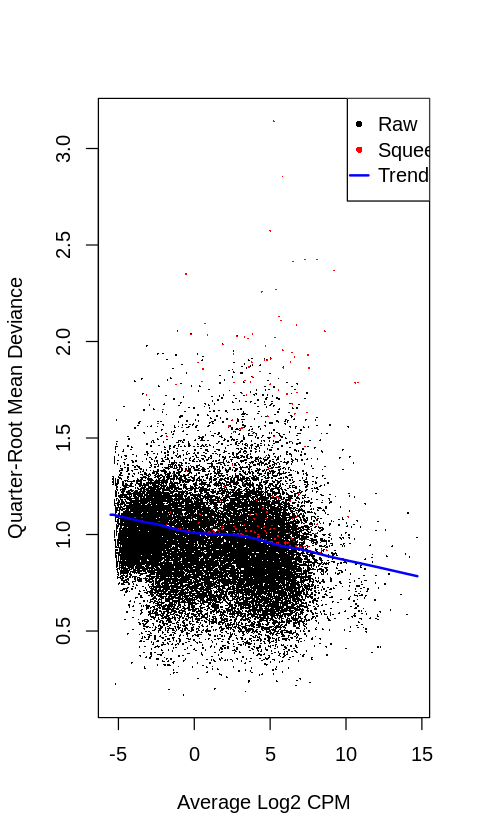

   logFC logCPM    F  PValue de_gene target subclass  label plasmid
1 -0.425   4.33 36.1 1.8e-09   FKBP9   DE14   ckd_de CKD DE  DE14-2
2 -0.431   3.51 20.2 6.8e-06   PDE1C   DE14   ckd_de CKD DE  DE14-2
3  0.090   6.20  4.9 2.6e-02    AVL9   DE14   ckd_de CKD DE  DE14-2
4  0.419   0.68  3.7 5.5e-02   BMPER   DE14   ckd_de CKD DE  DE14-2
5  0.069   5.83  2.5 1.1e-01    BBS9   DE14   ckd_de CKD DE  DE14-2
6  0.062   5.46  1.7 1.9e-01  NT5C3A   DE14   ckd_de CKD DE  DE14-2
-------------------------------------------------------

DE15 : DE15-1a,DE15-1b 
DE15-1a   844 
DE15-1b   818 
[1] "DE15-1a" "DE15-1b"
[1] "DE15-1a" "DE15-2a" "DE15-1b" "DE15-2b"
Vector+ = 1078 ; Target- = 24818 ; All = 27142 

donor0 donor1 donor2 donor3 
   265    229    325    259 
[1] 0.0013


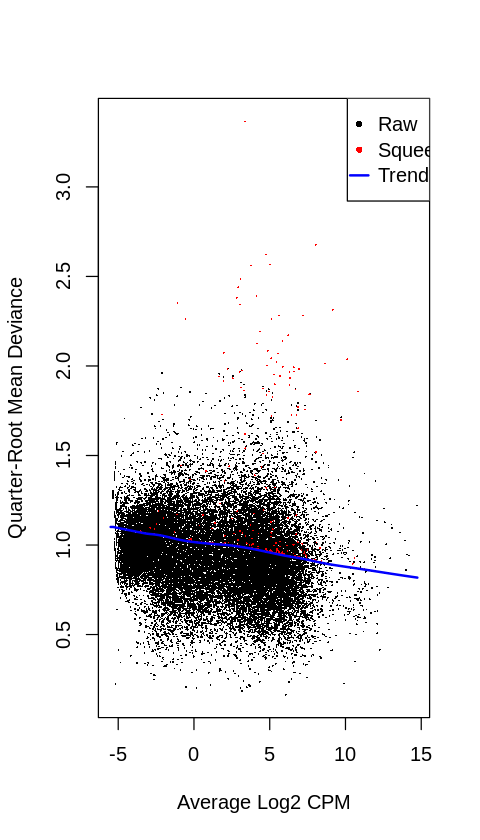

   logFC logCPM     F  PValue   de_gene target subclass  label plasmid
1 -0.481    8.3 284.8 8.1e-64     RBPMS   DE15   ckd_de CKD DE  DE15-1
2 -0.488    1.0   4.2 4.1e-02     TEX15   DE15   ckd_de CKD DE  DE15-1
3  0.846   -1.5   3.3 6.9e-02 LINC00589   DE15   ckd_de CKD DE  DE15-1
4  0.208    2.7   3.3 7.1e-02 RBPMS-AS1   DE15   ckd_de CKD DE  DE15-1
5  0.083    5.5   3.0 8.4e-02  LEPROTL1   DE15   ckd_de CKD DE  DE15-1
6  1.183   -3.0   2.4 1.2e-01 LINC02099   DE15   ckd_de CKD DE  DE15-1
-------------------------------------------------------

DE15 : DE15-2a,DE15-2b 
DE15-2a   1013 
DE15-2b   1000 
[1] "DE15-2a" "DE15-2b"
[1] "DE15-1a" "DE15-2a" "DE15-1b" "DE15-2b"
Vector+ = 1357 ; Target- = 24818 ; All = 27142 

donor0 donor1 donor2 donor3 
   311    272    422    352 
[1] 0.0011


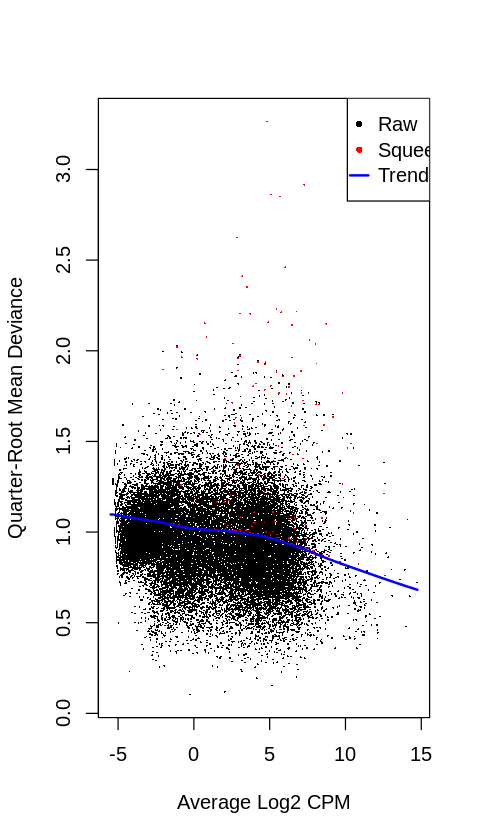

   logFC logCPM     F  PValue   de_gene target subclass  label plasmid
1 -0.509    8.3 373.2 5.3e-83     RBPMS   DE15   ckd_de CKD DE  DE15-2
2  0.099    6.6   9.5 2.0e-03    PPP2CB   DE15   ckd_de CKD DE  DE15-2
3 -0.103    5.0   4.2 4.0e-02     DCTN6   DE15   ckd_de CKD DE  DE15-2
4 -2.244   -2.9   3.3 7.1e-02      PURG   DE15   ckd_de CKD DE  DE15-2
5  0.137    2.7   1.8 1.7e-01 RBPMS-AS1   DE15   ckd_de CKD DE  DE15-2
6 -0.065    4.9   1.6 2.0e-01       WRN   DE15   ckd_de CKD DE  DE15-2
-------------------------------------------------------

DE16 : DE16-1a,DE16-1b 
DE16-1a   741 
DE16-1b   818 
[1] "DE16-1a" "DE16-1b"
[1] "DE16-1a" "DE16-2a" "DE16-1b" "DE16-2b"
Vector+ = 1049 ; Target- = 25270 ; All = 27142 

donor0 donor1 donor2 donor3 
   230    214    331    274 
[1] 0.0017


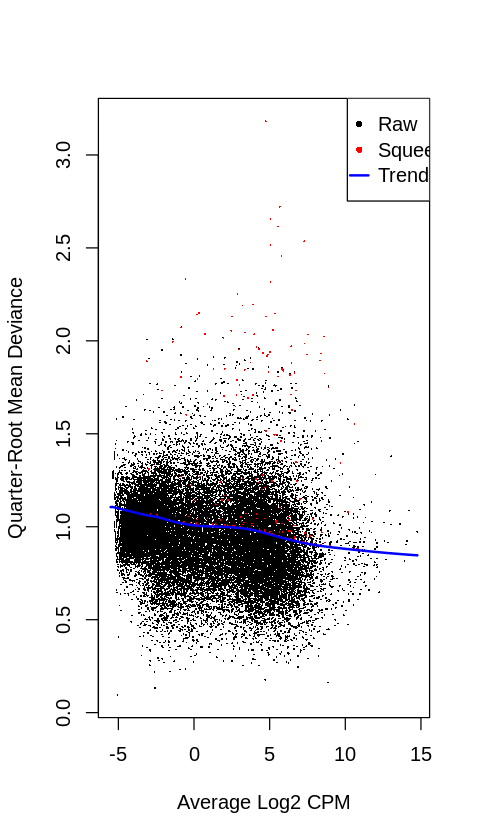

  logFC logCPM     F  PValue de_gene target subclass  label plasmid
1 -0.44   6.46 104.0 2.3e-24   PKHD1   DE16   ckd_de CKD DE  DE16-1
2 -0.34   4.28  21.6 3.4e-06    MCM3   DE16   ckd_de CKD DE  DE16-1
3 -0.31   3.83  13.3 2.6e-04  TFAP2B   DE16   ckd_de CKD DE  DE16-1
4 -0.17   4.48   6.3 1.2e-02   EFHC1   DE16   ckd_de CKD DE  DE16-1
5 -0.66   0.47   5.4 2.0e-02   PAQR8   DE16   ckd_de CKD DE  DE16-1
6  4.62  -5.43   4.4 3.6e-02   IL17F   DE16   ckd_de CKD DE  DE16-1
-------------------------------------------------------

DE16 : DE16-2a,DE16-2b 
DE16-2a   0 
DE16-2b   901 
[1] "DE16-2a" "DE16-2b"
[1] "DE16-1a" "DE16-2a" "DE16-1b" "DE16-2b"
Vector+ = 901 ; Target- = 25270 ; All = 27142 

donor0 donor1 donor2 donor3 
   212    200    276    213 
[1] 0.002


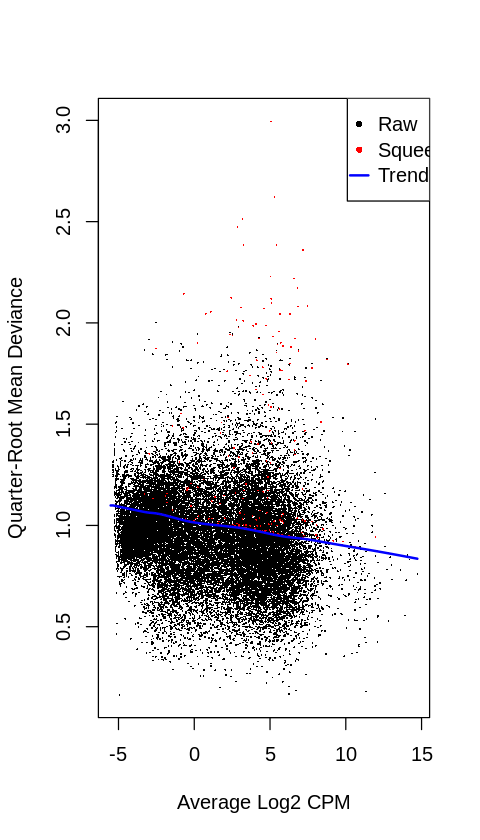

  logFC logCPM    F  PValue de_gene target subclass  label plasmid
1 -0.36   4.28 19.7 8.9e-06    MCM3   DE16   ckd_de CKD DE  DE16-2
2 -0.18   6.54 15.3 9.4e-05   PKHD1   DE16   ckd_de CKD DE  DE16-2
3 -0.34   3.83 11.0 1.2e-03  TFAP2B   DE16   ckd_de CKD DE  DE16-2
4  1.90  -3.98  3.2 7.5e-02 LINCMD1   DE16   ckd_de CKD DE  DE16-2
5  0.43   0.53  2.7 9.8e-02   PAQR8   DE16   ckd_de CKD DE  DE16-2
6 -0.11   4.49  2.2 1.4e-01   EFHC1   DE16   ckd_de CKD DE  DE16-2
-------------------------------------------------------

DE17 : DE17-1a,DE17-1b 
DE17-1a   815 
DE17-1b   803 
[1] "DE17-1a" "DE17-1b"
[1] "DE17-1a" "DE17-2a" "DE17-1b" "DE17-2b"
Vector+ = 1076 ; Target- = 25106 ; All = 27142 

donor0 donor1 donor2 donor3 
   223    236    324    293 
[1] 0.0013


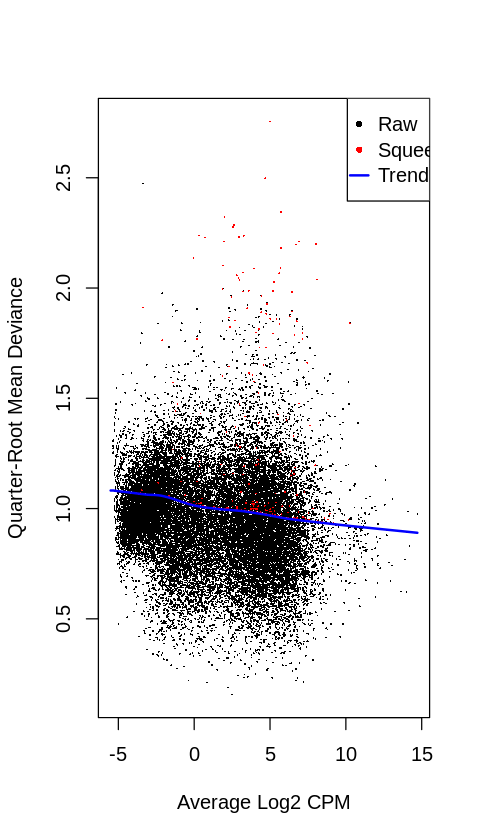

   logFC logCPM    F  PValue de_gene target subclass  label plasmid
1 -0.812    1.3 14.1 0.00018   XRCC2   DE17   ckd_de CKD DE  DE17-1
2  0.085    7.2  6.8 0.00916    RHEB   DE17   ckd_de CKD DE  DE17-1
3  0.102    5.6  4.9 0.02661    NUB1   DE17   ckd_de CKD DE  DE17-1
4 -0.081    6.5  4.7 0.02943 GALNT11   DE17   ckd_de CKD DE  DE17-1
5 -0.371    1.8  4.7 0.03001    AOC1   DE17   ckd_de CKD DE  DE17-1
6  0.145    3.9  3.7 0.05326   AGAP3   DE17   ckd_de CKD DE  DE17-1
-------------------------------------------------------

DE17 : DE17-2a,DE17-2b 
DE17-2a   798 
DE17-2b   837 
[1] "DE17-2a" "DE17-2b"
[1] "DE17-1a" "DE17-2a" "DE17-1b" "DE17-2b"
Vector+ = 1080 ; Target- = 25106 ; All = 27142 

donor0 donor1 donor2 donor3 
   236    222    344    278 
[1] 0.0015


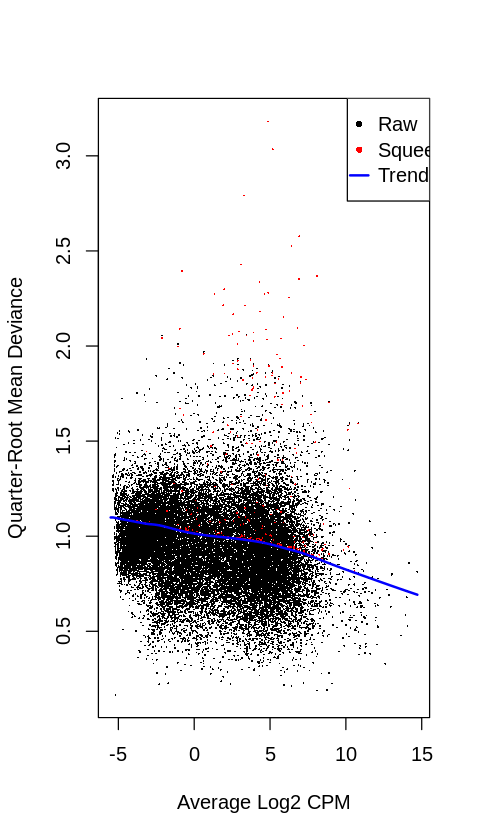

  logFC logCPM   F PValue   de_gene target subclass  label plasmid
1 -0.17    5.1 8.9 0.0028  TMEM176B   DE17   ckd_de CKD DE  DE17-2
2 -0.12    6.5 8.5 0.0035   GALNT11   DE17   ckd_de CKD DE  DE17-2
3 -0.17    4.8 7.5 0.0063  TMEM176A   DE17   ckd_de CKD DE  DE17-2
4 -0.54    1.3 6.8 0.0091     XRCC2   DE17   ckd_de CKD DE  DE17-2
5  1.34   -2.8 4.0 0.0468     ASIC3   DE17   ckd_de CKD DE  DE17-2
6  2.25   -4.3 3.9 0.0484 WDR86-AS1   DE17   ckd_de CKD DE  DE17-2
-------------------------------------------------------



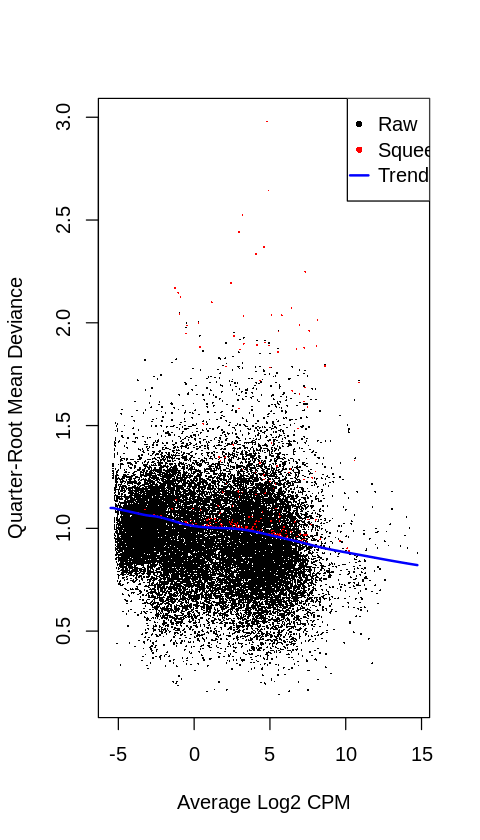

In [24]:
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')
df_targets = unique(filter(df_guide, subclass=='ckd_de'))
df_targets = unique(filter(df_guide, class=='targeting'))
#df_targets = unique(filter(df_guide, alias=='PLIN3'))
pos_label = "vector_positive"
neg_label = "target_negative"

df_neighbor_de = NULL
df_cell_counts = NULL
test_use = "LR" #"MAST"  #"wilcox" "LR"
guides_to_skip = c()  #c("DE6", "DE15")  
logfc_threshold = 0.01
n_tests = 0

# Main loop
for (i in 1:nrow(df_targets)) {
    is_de = FALSE
    target          = df_targets[i,'alias']
    target_subclass = df_targets[i, 'subclass']
    label           = df_targets[i, 'label']
    vector_id       = gsub("a", "", df_targets[i, 'guide1'])
    snp_id_or_gene_name = df_targets[i,'gene']
    
    # Check if "target" is not a DE gene
    if (!str_detect(target, regex("^DE\\d+$"))) {
        is_de = FALSE
        neighbors = neighbors_list[[target]]
    } else {
        is_de = TRUE
        neighbors = neighbors_list[[snp_id_or_gene_name]]
    }

    if ((target %in% guides_to_skip) | length(neighbors) == 0) {
        cat(red("Skipping", target, snp_id_or_gene_name, length(neighbors), "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    guides_on_plasmid = unlist(as.list(t(df_targets[i, c('guide1', 'guide2')])))
    cat(blue(target, ":"), paste(guides_on_plasmid, collapse = ","), "\n")

    seurat_dummy <- mark_vector_pos_target_neg(
        seurat_rna,
        perturbed_cells_by_guide,
        guides_on_plasmid,
        guides_4_target,
        print_counts = T,
        pos_label = "vector_positive",
        neg_label = "target_negative"
    )
    
    # Process cells with the given target and perturbation status
    if("vector_positive" %in% levels((Idents(seurat_dummy)))) {
        dummy <- process_target_cells(
            seurat_dummy, target, vector_id, is_de, neighbors, 
            perturbed_cells_by_guide, guides_on_plasmid, guides_4_target, 
            df_cell_counts, df_neighbor_de, pos_label, neg_label, target_subclass
        )
        df_cell_counts = dummy$df_cell_counts
        df_neighbor_de = dummy$df_neighbor_de
        n_tests = n_tests + dummy$n_tests_performed
    } else {
        cat(red("No cells found:"), paste(guides_on_plasmid, collapse=","),"\n")
    }
}

### Correct p-values by total number of comparisons

In [25]:
#n_tests = length(flatten(neighbors_list)) * length(df_targets)
print(n_tests)
df_neighbor_de$p_val_adj_mine =  p.adjust(
    p = df_neighbor_de$PValue,
    method = "bonferroni",
    n = n_tests
)

[1] 1217


In [26]:
head(df_neighbor_de)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-1.32,6.9,1122,2.6e-207,ANPEP,ANPEP,tss,Control TSS,CD13-1,3.2e-204
2,-0.33,6.7,76,2.5e-18,IDH2,ANPEP,tss,Control TSS,CD13-1,3.1e-15
3,-0.20,6.7,27,1.8e-07,SEMA4B,ANPEP,tss,Control TSS,CD13-1,2.2e-04
4,0.23,5.4,23,1.5e-06,AP3S2,ANPEP,tss,Control TSS,CD13-1,1.8e-03
5,0.21,5.4,19,1.5e-05,MFGE8,ANPEP,tss,Control TSS,CD13-1,1.8e-02
6,-0.36,3.5,15,1.2e-04,FANCI,ANPEP,tss,Control TSS,CD13-1,1.5e-01


In [27]:
df_cell_counts_backup = df_cell_counts

In [28]:
head(df_cell_counts)

,Row.names,count,target,label,vector,subclass,group,lib.size,norm.factors,sample,cluster
,<I<chr>>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>
1,donor0_cluster0,388,ANPEP,donor0_cluster0,CD13-1,tss,1,6.9e+06,1,donor0,0
2,donor0_cluster1,24813,ANPEP,donor0_cluster1,CD13-1,tss,1,1.6e+08,1,donor0,1
3,donor1_cluster0,533,ANPEP,donor1_cluster0,CD13-1,tss,1,7.9e+06,1,donor1,0
4,donor1_cluster1,25027,ANPEP,donor1_cluster1,CD13-1,tss,1,1.7e+08,1,donor1,1
5,donor2_cluster0,835,ANPEP,donor2_cluster0,CD13-1,tss,1,1.2e+07,1,donor2,0
6,donor2_cluster1,33783,ANPEP,donor2_cluster1,CD13-1,tss,1,2.2e+08,1,donor2,1


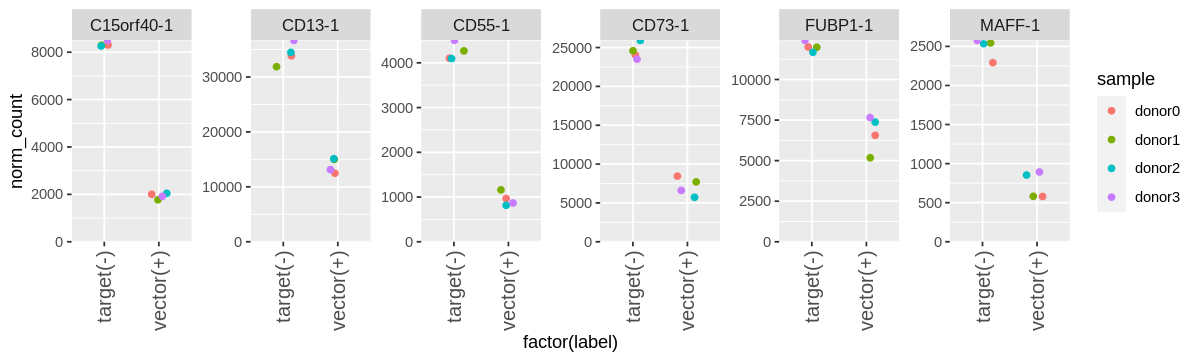

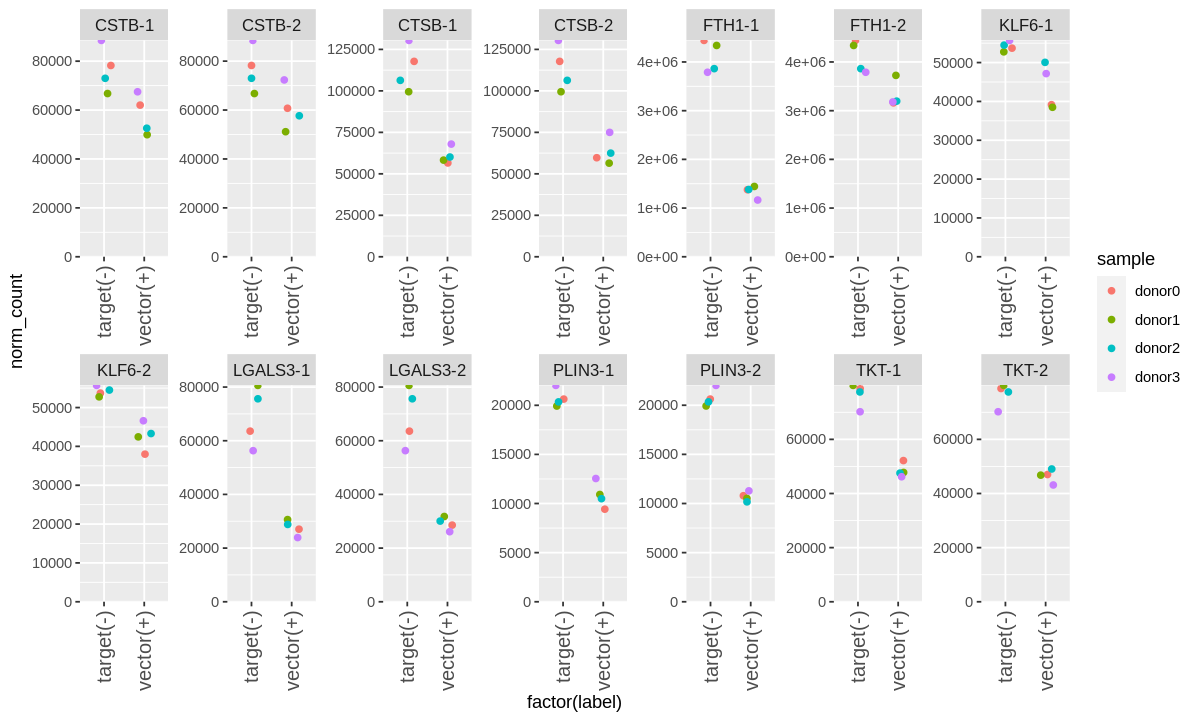

In [29]:
df_cell_counts = df_cell_counts_backup
df_cell_counts$label = str_replace(df_cell_counts$label, "donor._", "")
df_cell_counts$label = str_replace(df_cell_counts$label, "cluster0", "vector(+)")
df_cell_counts$label = str_replace(df_cell_counts$label, "cluster1", "target(-)")
df_cell_counts$label = str_replace(df_cell_counts$label, "clustervector_B", "(O)")
df_cell_counts$norm_count = max(df_cell_counts$lib.size) * df_cell_counts$count/df_cell_counts$lib.size

df_cell_counts_tss = df_cell_counts %>% filter(subclass == 'tss')
df_cell_counts_de  = df_cell_counts %>% filter(subclass == 'de_control')


# ggplot(df_cell_counts_tss, aes(x = label, y = norm_count, fill = sample))+
#     geom_bar(position = position_dodge2(padding = 0.3), width = 0.75, stat="identity")  +
#     facet_wrap(~ vector, scales="free", ncol = 6) +
#     theme(
#         axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 12), 
#         strip.text = element_text(size=10)
#     ) 

options(repr.plot.width=10, repr.plot.height=3)
#options(repr.plot.width=10, repr.plot.height=6)
ggplot(df_cell_counts_tss, aes(x = factor(label), y = norm_count))+
    geom_jitter(aes(color=sample), width=0.2)  +
    facet_wrap(~ vector, scales="free", ncol = 6) +
    scale_y_continuous(expand = c(0, 0), limits = c(0,NA)) +
    theme(
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 12), 
        strip.text = element_text(size=10)
    ) 


options(repr.plot.width=10, repr.plot.height=6)
#options(repr.plot.width=11, repr.plot.height=9)
ggplot(df_cell_counts_de, aes(x = factor(label), y = norm_count))+
    geom_jitter(aes(color=sample),width=0.2)  +
    facet_wrap(~ vector, scales="free", ncol = 7) +
    scale_y_continuous(expand = c(0, 0), limits = c(0,NA)) +
    theme(
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 12), 
        strip.text = element_text(size=10)
    ) 

#geom_bar(position = position_dodge2(padding = 0.3), stat="identity")  +

In [30]:
head(df_cell_counts)

,Row.names,count,target,label,vector,subclass,group,lib.size,norm.factors,sample,cluster,norm_count
,<I<chr>>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,donor0_cluster0,388,ANPEP,vector(+),CD13-1,tss,1,6.9e+06,1,donor0,0,12474
2,donor0_cluster1,24813,ANPEP,target(-),CD13-1,tss,1,1.6e+08,1,donor0,1,33842
3,donor1_cluster0,533,ANPEP,vector(+),CD13-1,tss,1,7.9e+06,1,donor1,0,15001
4,donor1_cluster1,25027,ANPEP,target(-),CD13-1,tss,1,1.7e+08,1,donor1,1,31867
5,donor2_cluster0,835,ANPEP,vector(+),CD13-1,tss,1,1.2e+07,1,donor2,0,15111
6,donor2_cluster1,33783,ANPEP,target(-),CD13-1,tss,1,2.2e+08,1,donor2,1,34475


## Inpect DE results

Print top high-confidence hits

In [31]:
df_neighbor_de %>% filter(logFC < 0) %>% arrange(PValue) %>% head(25)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-1.67,13.6,4162,0.0e+00,FTH1,FTH1,de_control,Control DE,FTH1-1,0.0e+00
2,-1.35,7.9,1709,0.0e+00,LGALS3,LGALS3,de_control,Control DE,LGALS3-1,0.0e+00
3,-1.28,7.9,1319,9.0e-285,LGALS3,LGALS3,de_control,Control DE,LGALS3-2,1.1e-281
4,-0.87,8.7,969,5.2e-210,CTSB,CTSB,de_control,Control DE,CTSB-2,6.3e-207
5,-1.32,6.9,1122,2.6e-207,ANPEP,ANPEP,tss,Control TSS,CD13-1,3.2e-204
6,-0.94,8.7,949,1.9e-200,CTSB,CTSB,de_control,Control DE,CTSB-1,2.3e-197
7,-2.14,4.9,790,3.1e-173,C15orf40,C15orf40,tss,Control TSS,C15orf40-1,3.8e-170
8,-1.85,6.4,1291,6.0e-165,NT5E,NT5E,tss,Control TSS,CD73-1,7.3e-162
9,-0.95,6.0,609,6.4e-134,NDRG1,DE6,ckd_de,CKD DE,DE6-2,7.8e-131


In [32]:
df_neighbor_de %>% filter(logFC > 0) %>% arrange(PValue) %>% head(25)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0.240,6.5,76.0,3.3e-18,SLC3A2,FTH1,de_control,Control DE,FTH1-2,4.0e-15
2,0.215,6.6,31.7,1.8e-08,TNFRSF10B,DE7,ckd_de,CKD DE,DE7-2,2.2e-05
3,0.461,2.3,31.0,2.6e-08,VWCE,FTH1,de_control,Control DE,FTH1-2,3.1e-05
4,0.130,11.2,30.8,2.9e-08,RPL36,PLIN3,de_control,Control DE,PLIN3-1,3.5e-05
5,0.154,11.2,29.3,6.2e-08,RPL36,PLIN3,de_control,Control DE,PLIN3-2,7.5e-05
6,0.286,3.4,24.3,8.3e-07,SNHG1,FTH1,de_control,Control DE,FTH1-2,1.0e-03
7,0.233,5.4,23.1,1.5e-06,AP3S2,ANPEP,tss,Control TSS,CD13-1,1.8e-03
8,0.155,6.6,19.6,9.8e-06,TNFRSF10B,DE7,ckd_de,CKD DE,DE7-1,1.2e-02
9,0.208,5.4,18.8,1.5e-05,MFGE8,ANPEP,tss,Control TSS,CD13-1,1.8e-02


### Check the TSS

In [33]:
df_neighbor_de %>% filter((subclass == 'tss')) %>% filter(logFC < 0) %>% arrange(PValue) %>% head(40)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-1.32,6.91,1122.3,2.6e-207,ANPEP,ANPEP,tss,Control TSS,CD13-1,3.2e-204
2,-2.14,4.94,790.1,3.1e-173,C15orf40,C15orf40,tss,Control TSS,C15orf40-1,3.8e-170
3,-1.85,6.37,1290.8,6.0e-165,NT5E,NT5E,tss,Control TSS,CD73-1,7.3e-162
4,-2.20,4.06,432.1,8.8e-96,CD55,CD55,tss,Control TSS,CD55-1,1.1e-92
5,-0.86,5.59,246.5,5.1e-55,FUBP1,FUBP1,tss,Control TSS,FUBP1-1,6.2e-52
6,-1.82,3.37,167.0,3.5e-38,MAFF,MAFF,tss,Control TSS,MAFF-1,4.3e-35
7,-0.33,6.66,76.3,2.5e-18,IDH2,ANPEP,tss,Control TSS,CD13-1,3.1e-15
8,-0.19,10.47,57.9,2.7e-14,LGALS1,MAFF,tss,Control TSS,MAFF-1,3.3e-11
9,-0.20,6.72,27.3,1.8e-07,SEMA4B,ANPEP,tss,Control TSS,CD13-1,2.2e-04


In [34]:
df_neighbor_de %>% filter((subclass == 'tss')) %>% filter(logFC > 0) %>% arrange(PValue) %>% head(20)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0.233,5.4,23.1,1.5e-06,AP3S2,ANPEP,tss,Control TSS,CD13-1,0.0018
2,0.208,5.4,18.8,1.5e-05,MFGE8,ANPEP,tss,Control TSS,CD13-1,0.0181
3,0.149,6.3,14.4,1.5e-04,NGRN,ANPEP,tss,Control TSS,CD13-1,0.1783
4,1.078,-1.1,8.8,2.9e-03,IDH2-DT,ANPEP,tss,Control TSS,CD13-1,1.0000
5,0.308,3.0,8.5,3.6e-03,DNAJB4,FUBP1,tss,Control TSS,FUBP1-1,1.0000
6,0.262,3.7,8.5,3.6e-03,MICALL1,MAFF,tss,Control TSS,MAFF-1,1.0000
7,0.427,1.6,6.8,9.2e-03,CPEB1,C15orf40,tss,Control TSS,C15orf40-1,1.0000
8,0.159,4.8,5.7,1.7e-02,JOSD1,MAFF,tss,Control TSS,MAFF-1,1.0000
9,0.180,3.4,4.2,4.1e-02,MESP1,ANPEP,tss,Control TSS,CD13-1,1.0000


In [35]:
df_neighbor_de %>% filter((subclass == 'ckd_de')) %>% filter(PValue < 1e-2) %>% arrange(PValue) %>% head(30)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-0.95,6.03,609,6.4e-134,NDRG1,DE6,ckd_de,CKD DE,DE6-2,7.8e-131
2,-1.15,6.02,603,3.0e-89,NDRG1,DE6,ckd_de,CKD DE,DE6-1,3.7e-86
3,-0.51,8.29,373,5.3e-83,RBPMS,DE15,ckd_de,CKD DE,DE15-2,6.4e-80
4,-0.48,8.30,285,8.1e-64,RBPMS,DE15,ckd_de,CKD DE,DE15-1,9.9e-61
5,-0.72,4.91,157,7.5e-36,STC1,DE7,ckd_de,CKD DE,DE7-1,9.1e-33
6,-0.87,4.80,155,1.7e-35,CCNB1,DE4,ckd_de,CKD DE,DE4-2,2.1e-32
7,-0.85,4.80,211,1.2e-29,CCNB1,DE4,ckd_de,CKD DE,DE4-1,1.5e-26
8,-0.44,6.46,104,2.3e-24,PKHD1,DE16,ckd_de,CKD DE,DE16-1,2.8e-21
9,-0.37,5.56,64,1.3e-15,LOXL2,DE7,ckd_de,CKD DE,DE7-1,1.5e-12


In [36]:
df_neighbor_de %>% filter((subclass == 'de_control') & (PValue < 1e-10)) 

logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
-1.67,13.6,4162,0.0e+00,FTH1,FTH1,de_control,Control DE,FTH1-1,0.0e+00
-1.31,3.5,109,2.1e-25,BEST1,FTH1,de_control,Control DE,FTH1-1,2.5e-22
-0.44,5.2,47,5.8e-12,FADS3,FTH1,de_control,Control DE,FTH1-1,7.0e-09
-0.42,4.7,98,3.8e-23,FADS2,FTH1,de_control,Control DE,FTH1-2,4.6e-20
-0.22,8.3,93,4.3e-22,AHNAK,FTH1,de_control,Control DE,FTH1-2,5.2e-19
0.24,6.5,76,3.3e-18,SLC3A2,FTH1,de_control,Control DE,FTH1-2,4.0e-15
-0.26,6.0,73,1.5e-17,ASRGL1,FTH1,de_control,Control DE,FTH1-2,1.8e-14
-0.20,5.9,42,7.7e-11,FADS1,FTH1,de_control,Control DE,FTH1-2,9.4e-08
-0.96,6.3,528,1.2e-116,PLIN3,PLIN3,de_control,Control DE,PLIN3-1,1.5e-113


In [37]:
#select_significant_p  = df_neighbor_de$PValue < 1
#df_neighbor_de        = df_neighbor_de[select_significant_p,]
head(df_neighbor_de[df_neighbor_de$target == "DE6",], 20)
head(df_neighbor_de[df_neighbor_de$target == "DE15",], 20)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
801,-1.1530,6.019,603.039,3.0e-89,NDRG1,DE6,ckd_de,CKD DE,DE6-1,3.7e-86
802,0.0632,6.145,2.455,1.2e-01,PHF20L1,DE6,ckd_de,CKD DE,DE6-1,1.0e+00
803,0.8581,-2.144,2.443,1.2e-01,HPYR1,DE6,ckd_de,CKD DE,DE6-1,1.0e+00
804,0.1088,2.520,0.843,3.6e-01,TG,DE6,ckd_de,CKD DE,DE6-1,1.0e+00
805,0.0553,4.453,0.766,3.8e-01,KCNQ3,DE6,ckd_de,CKD DE,DE6-1,1.0e+00
806,-0.2176,-0.055,0.494,4.8e-01,CCN4,DE6,ckd_de,CKD DE,DE6-1,1.0e+00
807,0.1899,-0.658,0.282,6.0e-01,TMEM71,DE6,ckd_de,CKD DE,DE6-1,1.0e+00
808,0.1320,-0.112,0.196,6.6e-01,SLA,DE6,ckd_de,CKD DE,DE6-1,1.0e+00
809,0.0049,6.765,0.018,8.9e-01,ST3GAL1,DE6,ckd_de,CKD DE,DE6-1,1.0e+00


,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1096,-0.481,8.30,2.8e+02,8.1e-64,RBPMS,DE15,ckd_de,CKD DE,DE15-1,9.9e-61
1097,-0.488,1.03,4.2e+00,4.1e-02,TEX15,DE15,ckd_de,CKD DE,DE15-1,1.0e+00
1098,0.846,-1.51,3.3e+00,6.9e-02,LINC00589,DE15,ckd_de,CKD DE,DE15-1,1.0e+00
1099,0.208,2.73,3.3e+00,7.1e-02,RBPMS-AS1,DE15,ckd_de,CKD DE,DE15-1,1.0e+00
1100,0.083,5.54,3.0e+00,8.4e-02,LEPROTL1,DE15,ckd_de,CKD DE,DE15-1,1.0e+00
1101,1.183,-3.01,2.4e+00,1.2e-01,LINC02099,DE15,ckd_de,CKD DE,DE15-1,1.0e+00
1102,1.050,-2.82,2.1e+00,1.5e-01,PURG,DE15,ckd_de,CKD DE,DE15-1,1.0e+00
1103,0.677,-1.91,1.5e+00,2.2e-01,MBOAT4,DE15,ckd_de,CKD DE,DE15-1,1.0e+00
1104,-0.066,4.94,1.3e+00,2.6e-01,WRN,DE15,ckd_de,CKD DE,DE15-1,1.0e+00


## Volcano Plot

In [38]:
colors <- ifelse(
    df_neighbor_de$subclass == 'tss', 'black',
    ifelse(df_neighbor_de$subclass == 'de_control', 'gray', 'green') 
)
names(colors) <- df_neighbor_de$label

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"ggrepel: 45 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


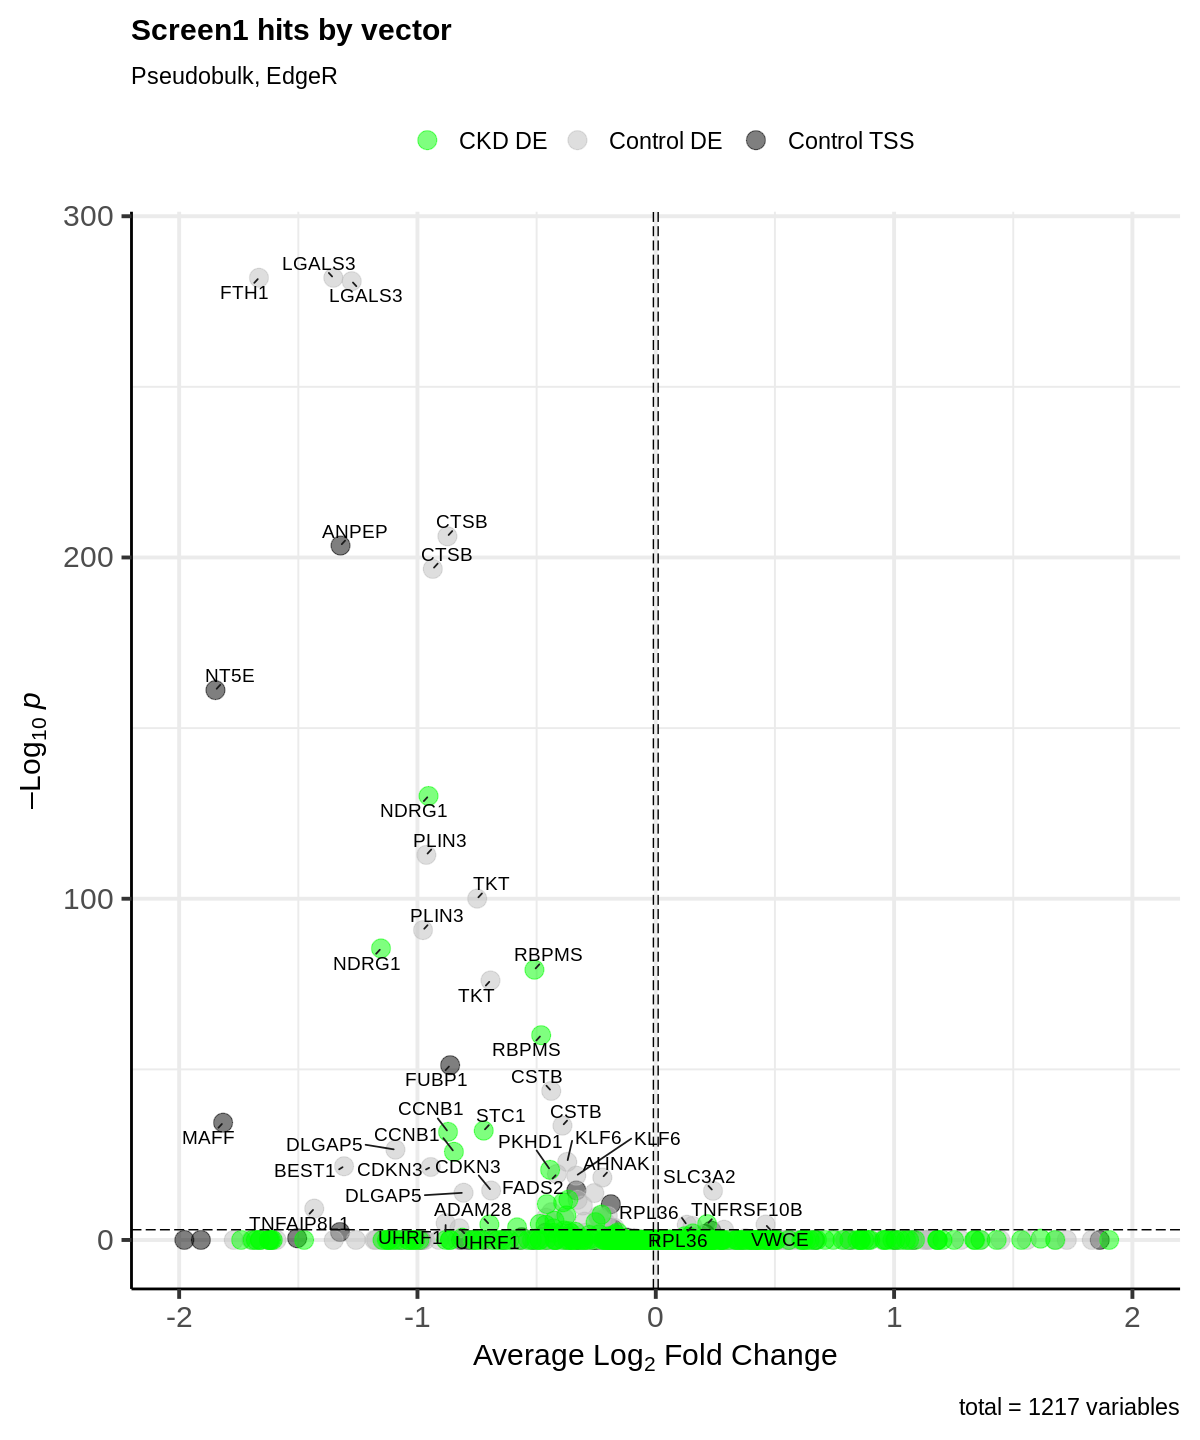

In [39]:
options(repr.plot.width = 10, repr.plot.height = 12)
EnhancedVolcano(df_neighbor_de, 
                lab = df_neighbor_de$de_gene,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, "hits by vector"),
                subtitle = 'Pseudobulk, EdgeR', 
                colCustom = colors,
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-04,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-2, 2) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

# lab = df_neighbor_de$de_gene,
# drawConnectors = TRUE,

### Plot just the control TSS

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"Removed 1 rows containing missing values (`geom_hline()`)."


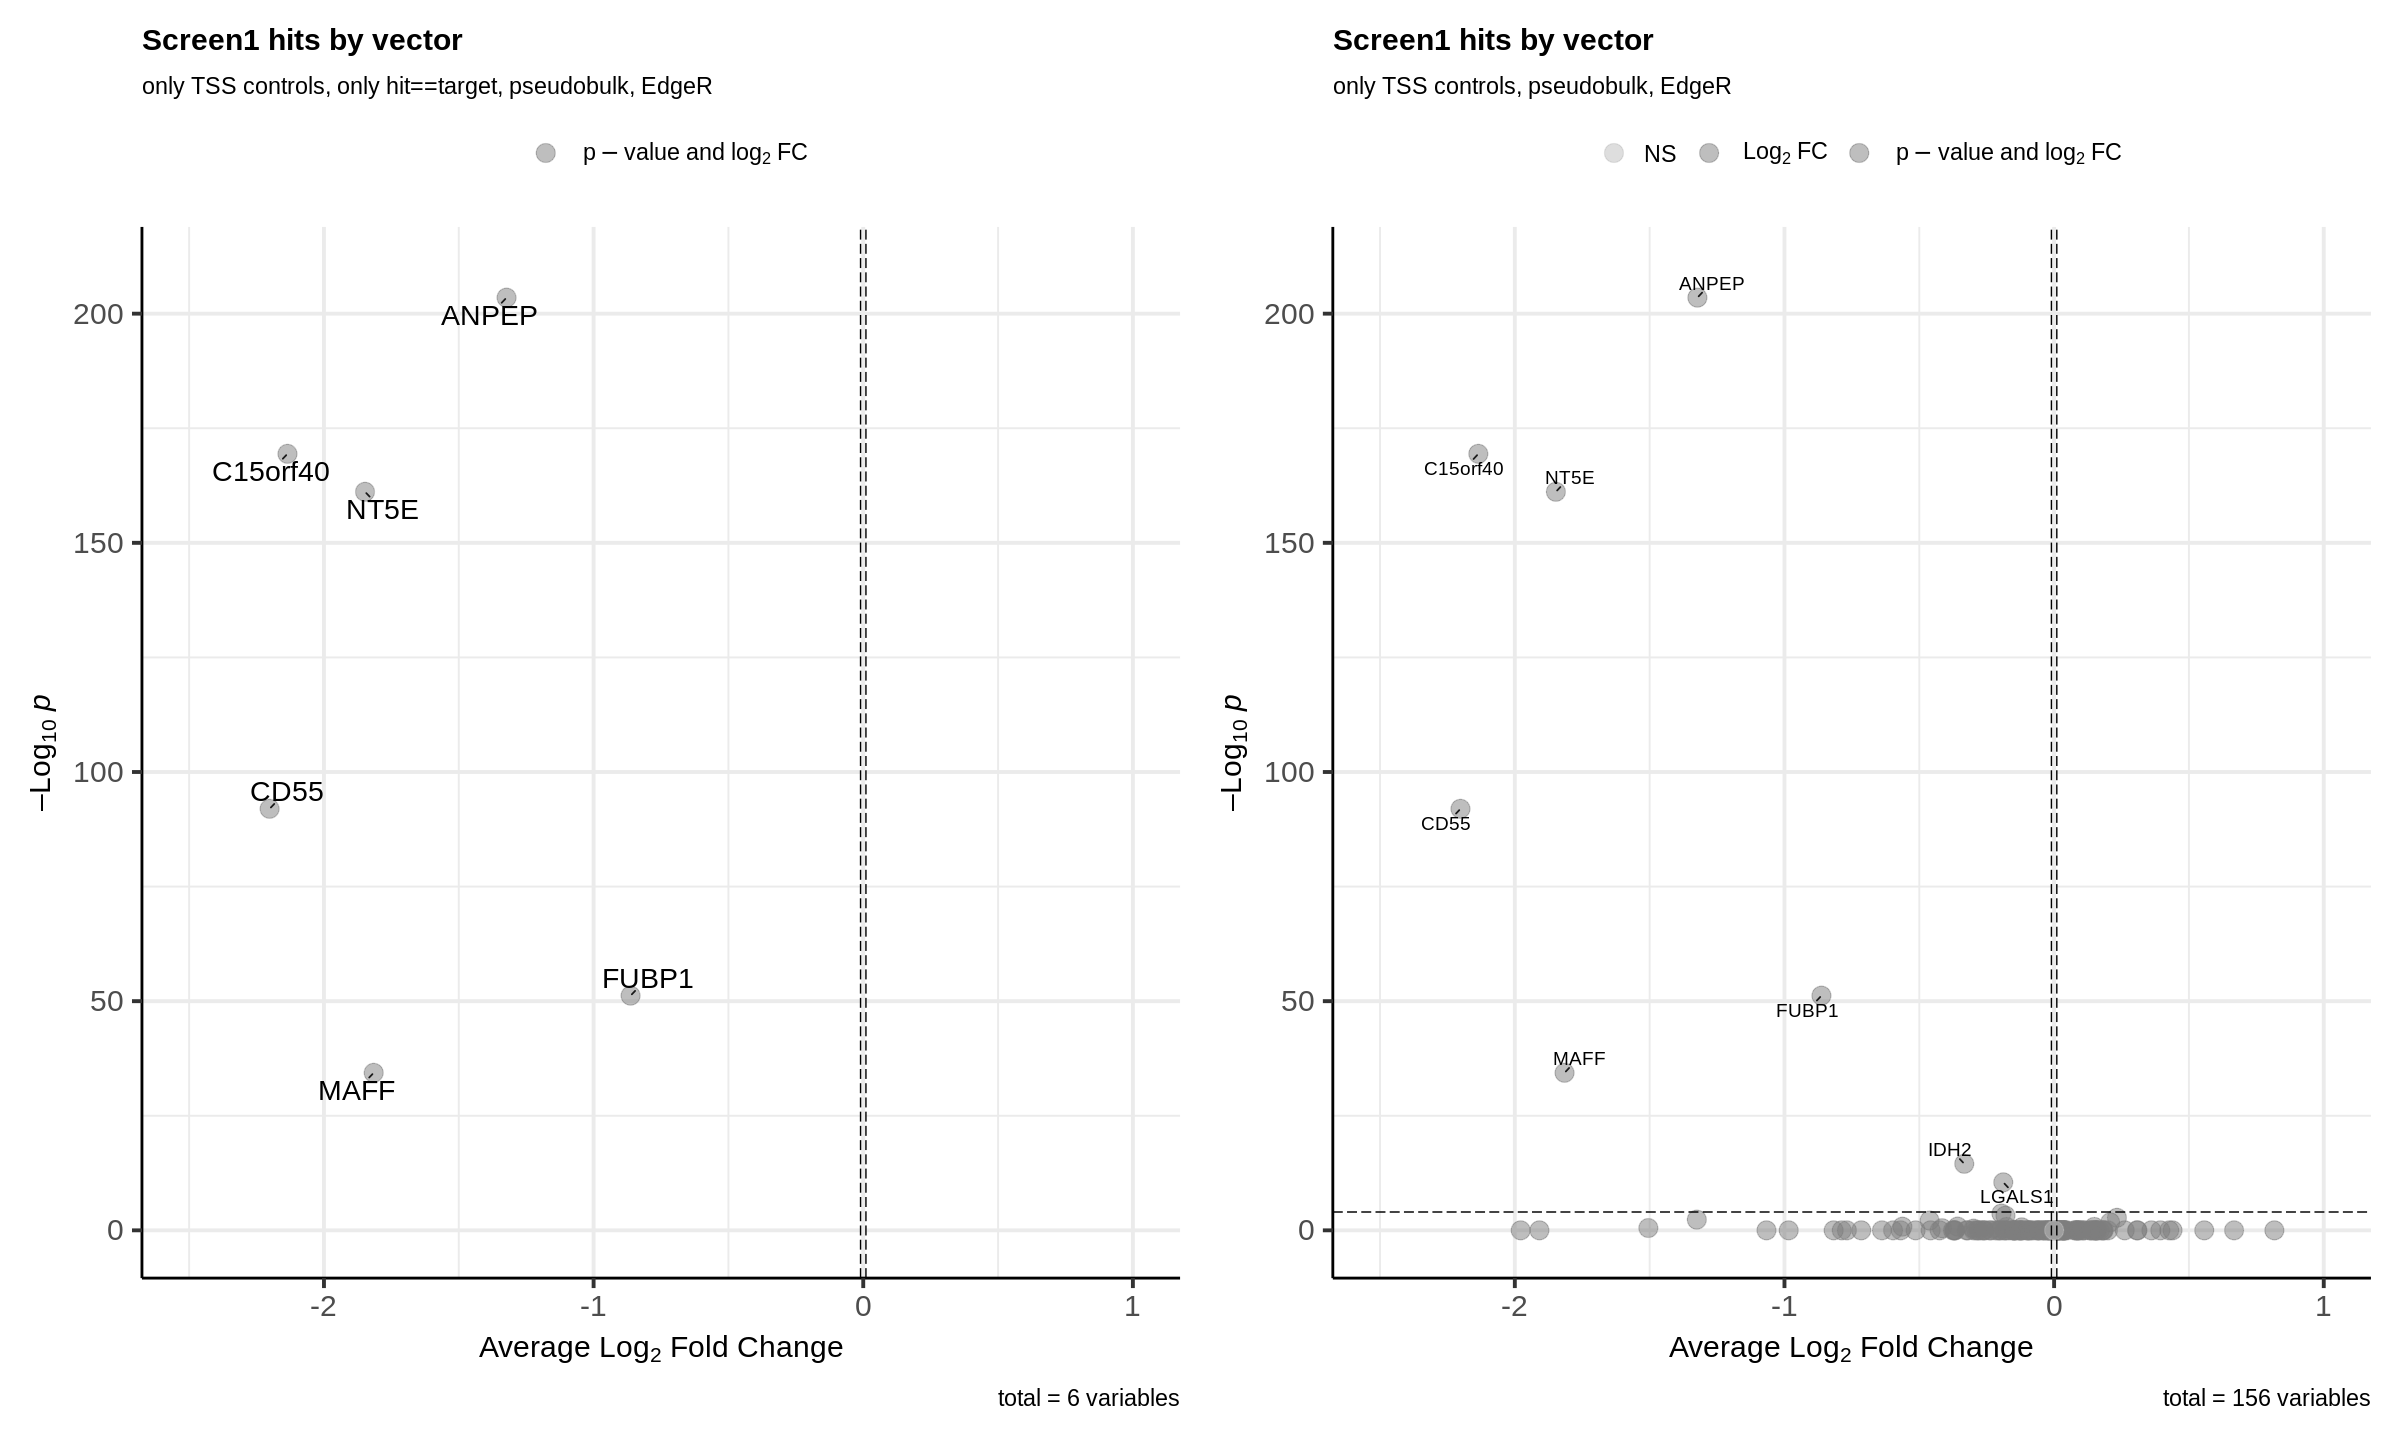

In [40]:
de_filter = (df_neighbor_de$subclass == 'tss') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, 'hits by vector'),
                subtitle = 'only TSS controls, only hit==target, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-0,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-2.5, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'tss')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, 'hits by vector'),
                subtitle = 'only TSS controls, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-2.5, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

In [41]:
head(df_neighbor_de_subset)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-1.32,6.9,1122,2.6e-207,ANPEP,ANPEP,tss,Control TSS,CD13-1,3.2e-204
2,-0.33,6.7,76,2.5e-18,IDH2,ANPEP,tss,Control TSS,CD13-1,3.1e-15
3,-0.20,6.7,27,1.8e-07,SEMA4B,ANPEP,tss,Control TSS,CD13-1,2.2e-04
4,0.23,5.4,23,1.5e-06,AP3S2,ANPEP,tss,Control TSS,CD13-1,1.8e-03
5,0.21,5.4,19,1.5e-05,MFGE8,ANPEP,tss,Control TSS,CD13-1,1.8e-02
6,-0.36,3.5,15,1.2e-04,FANCI,ANPEP,tss,Control TSS,CD13-1,1.5e-01


### Plot just the control DE

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"ggrepel: 48 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


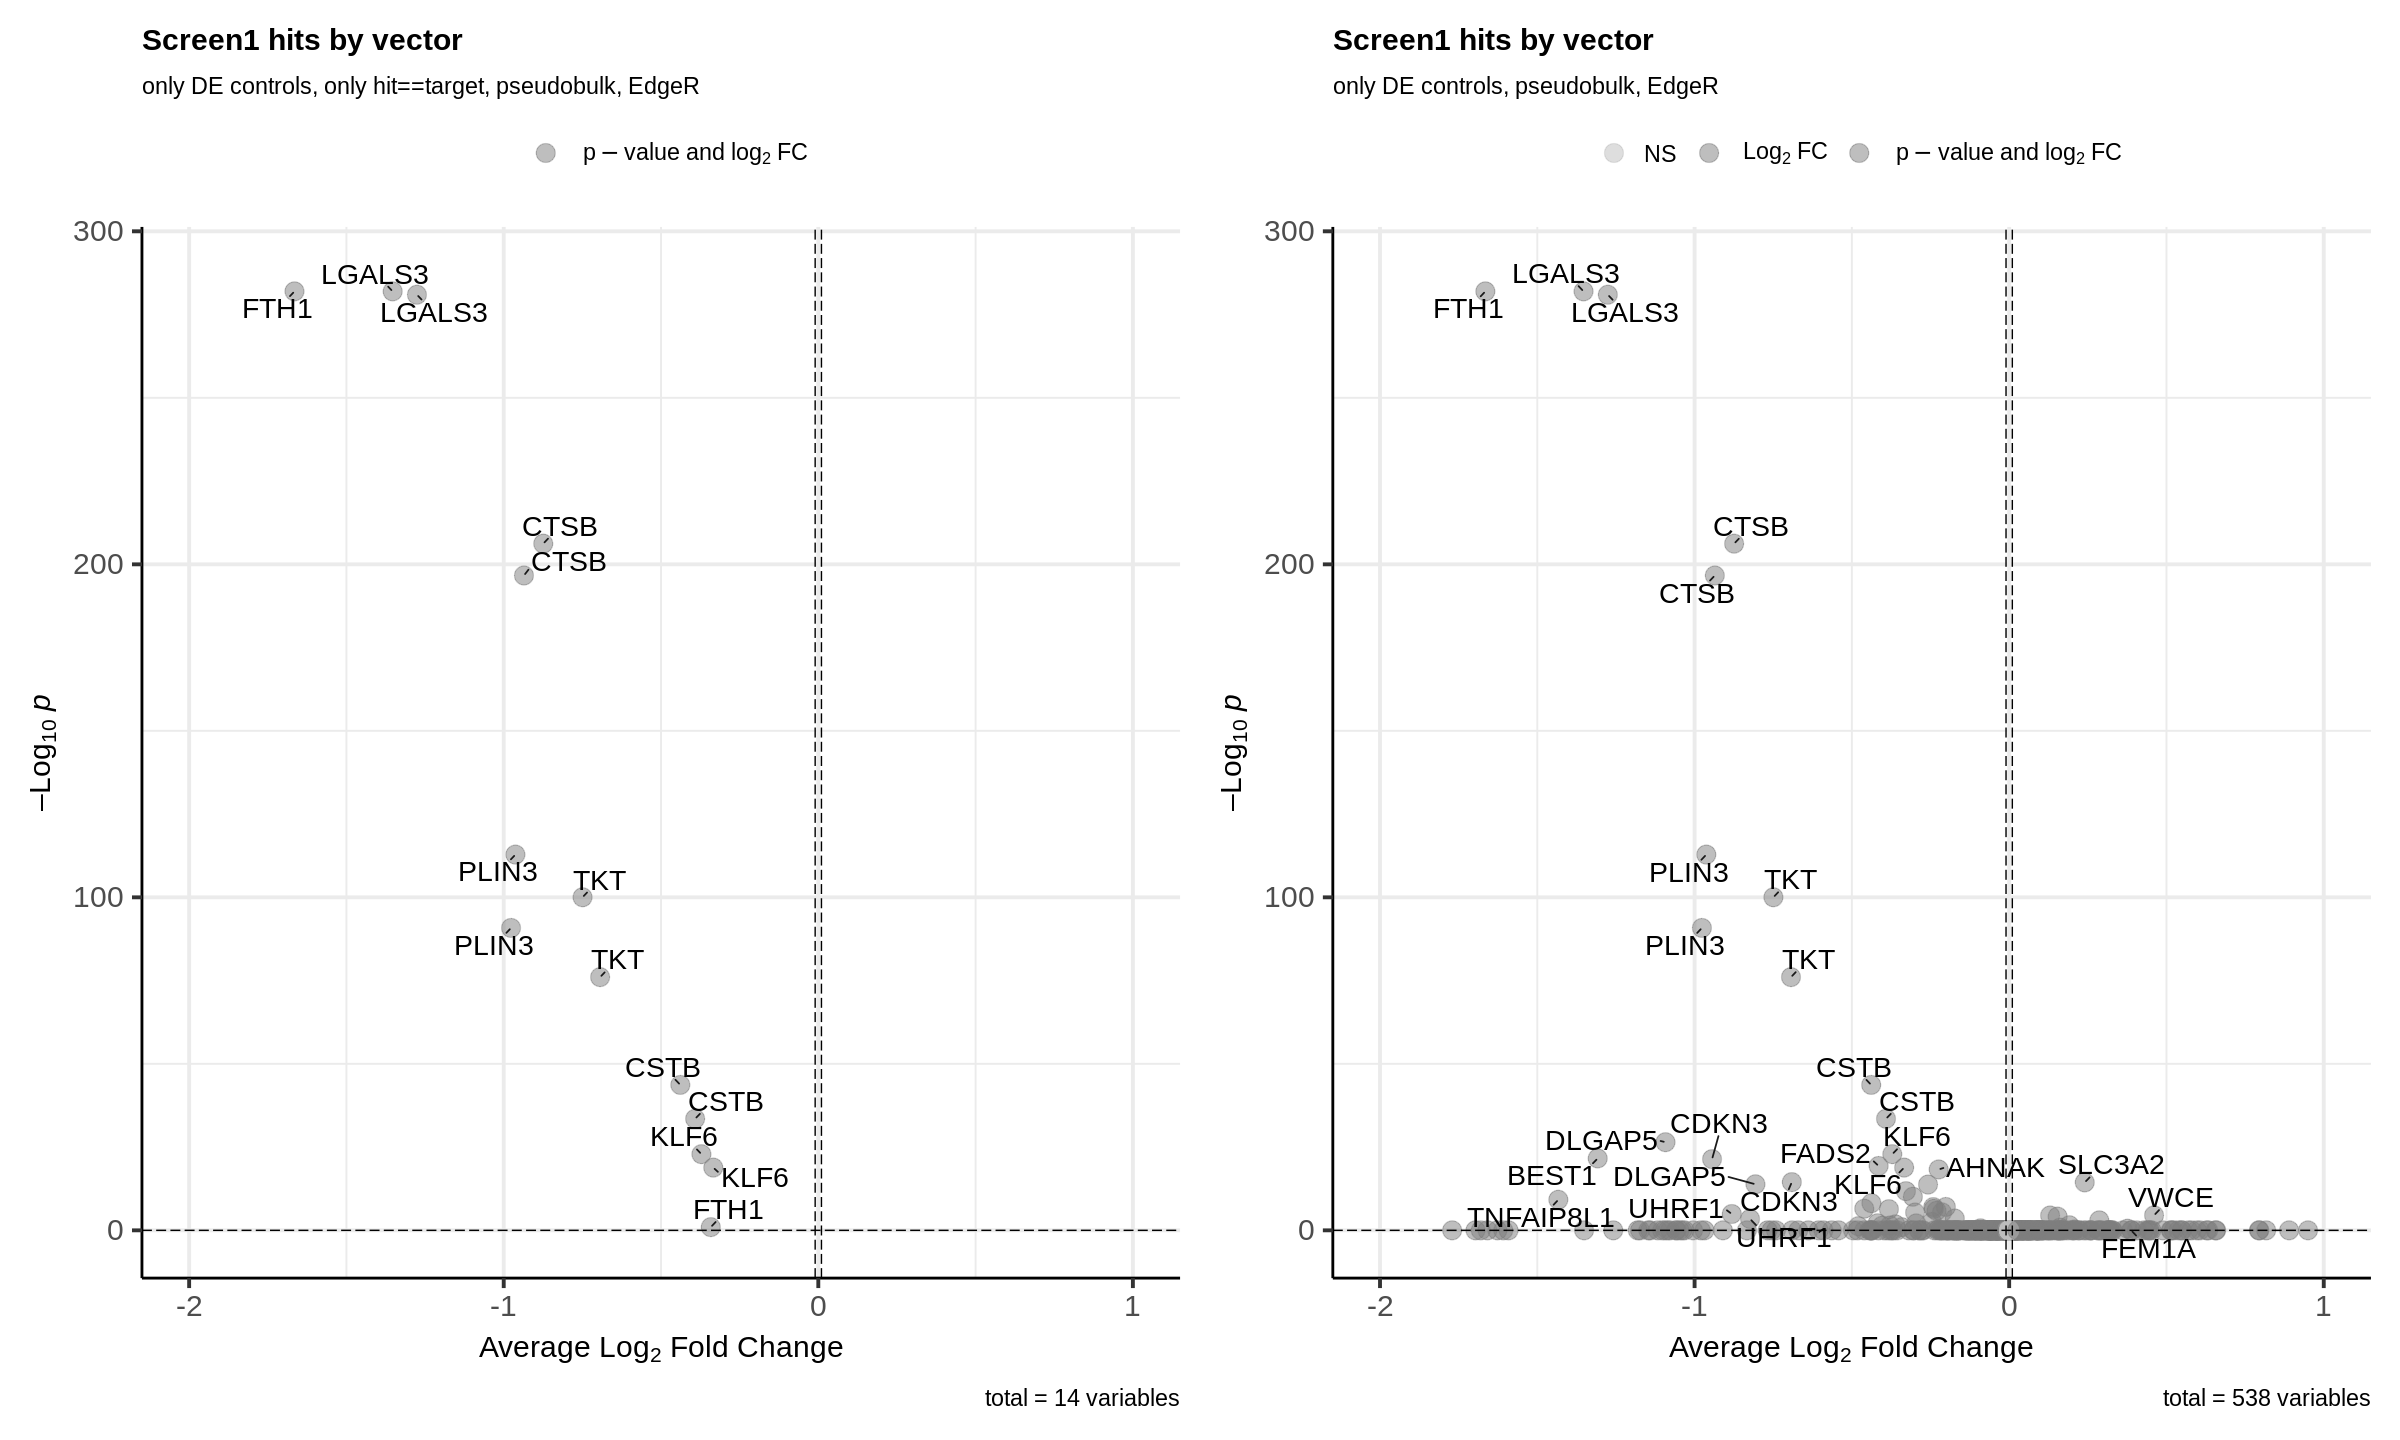

In [42]:
de_filter = (df_neighbor_de$subclass == 'de_control') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, 'hits by vector'),
                subtitle = 'only DE controls, only hit==target, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-1,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-2, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'de_control')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, 'hits by vector'),
                subtitle = 'only DE controls, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-1,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-2, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

### Plot just the CKD DE

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
"ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


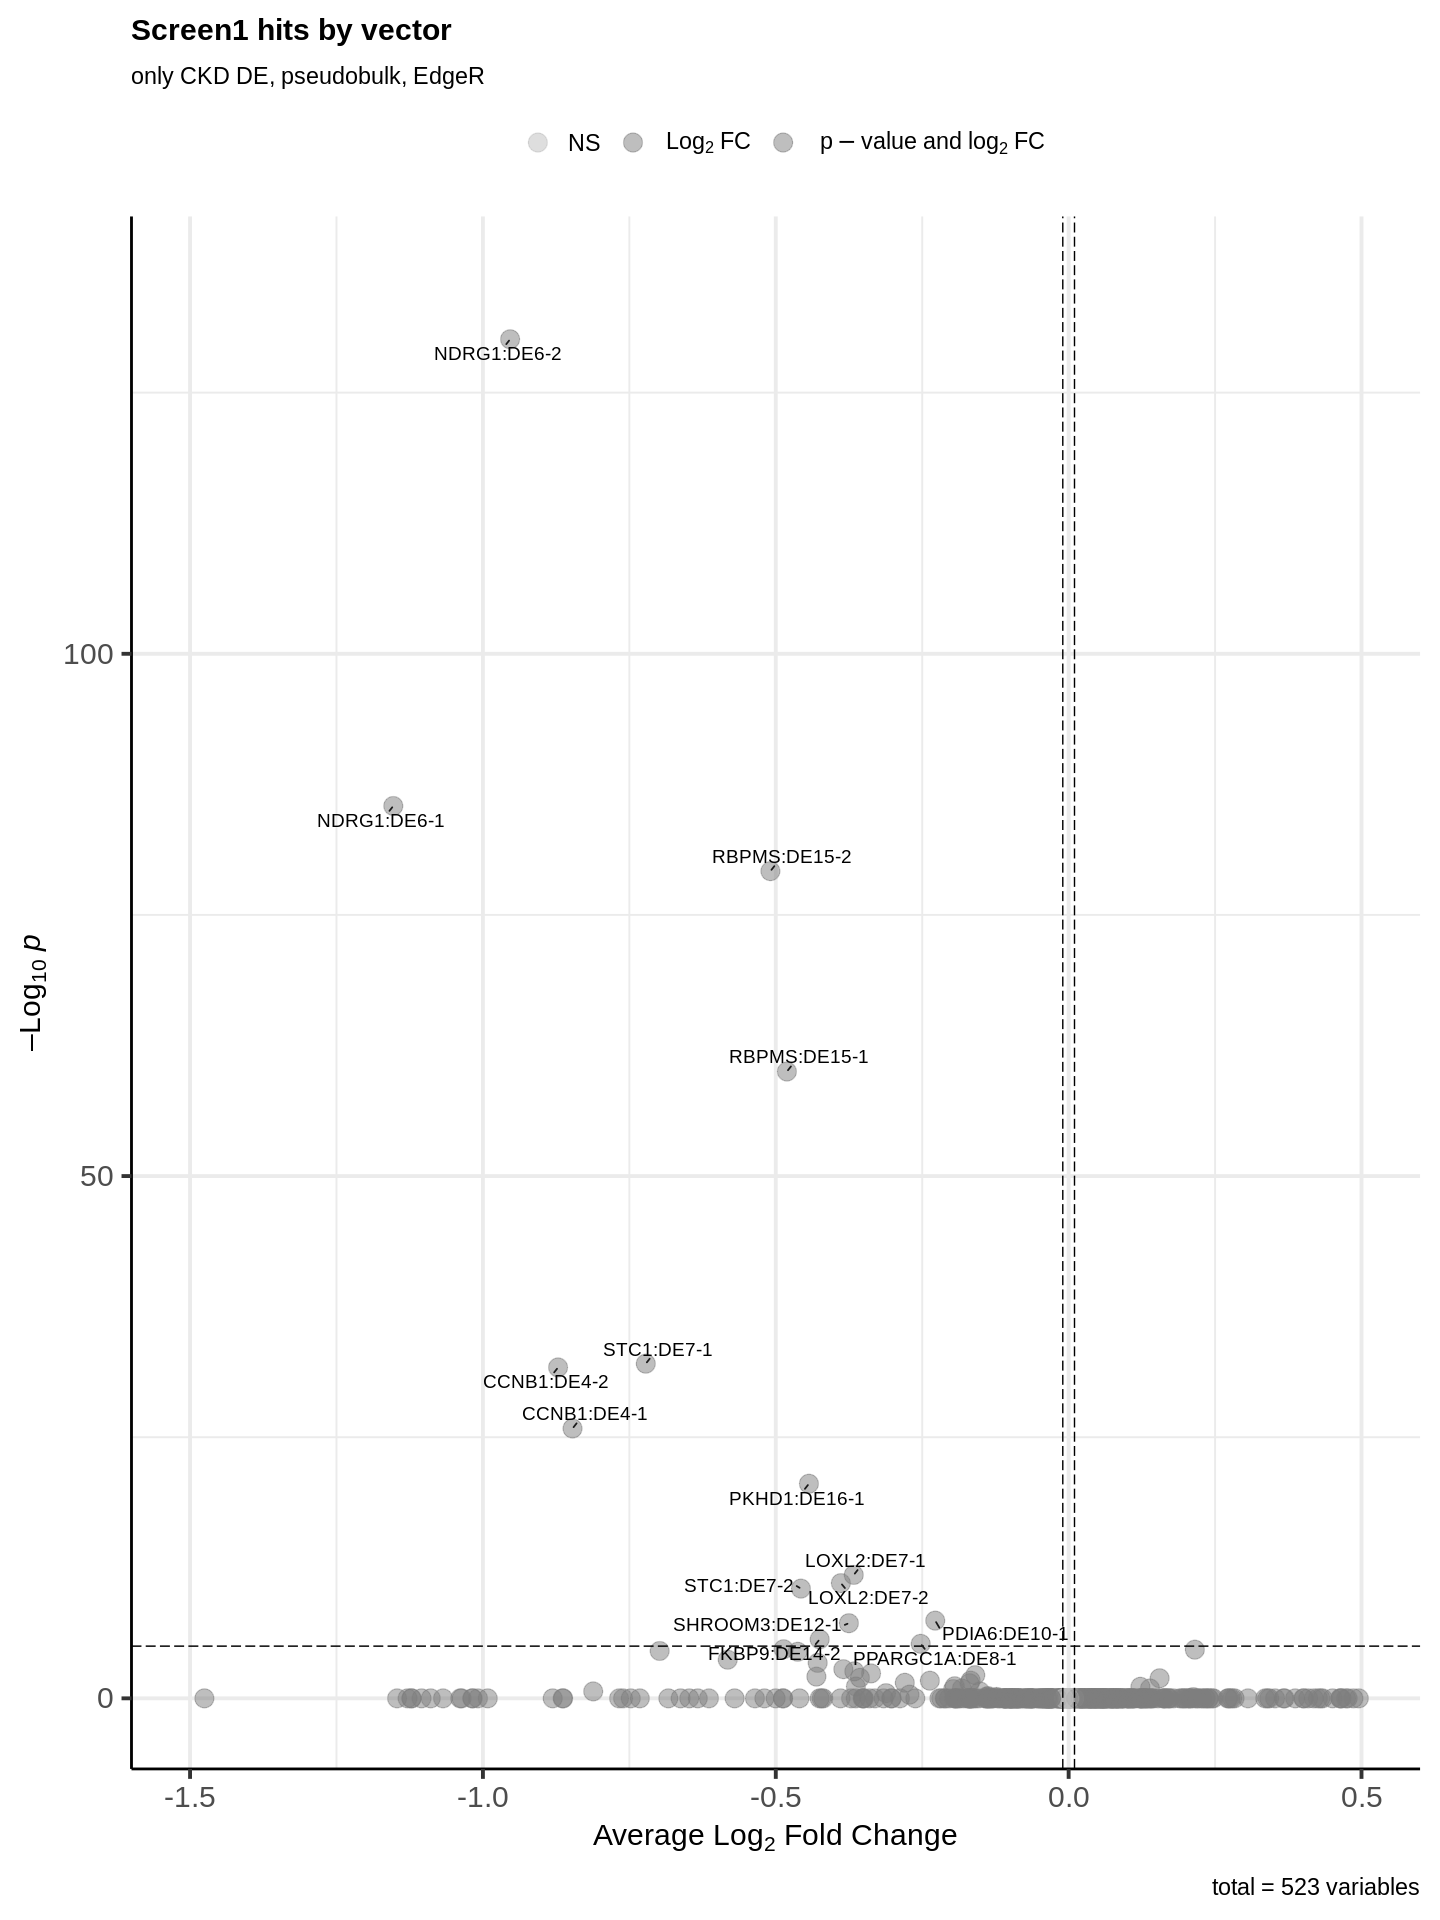

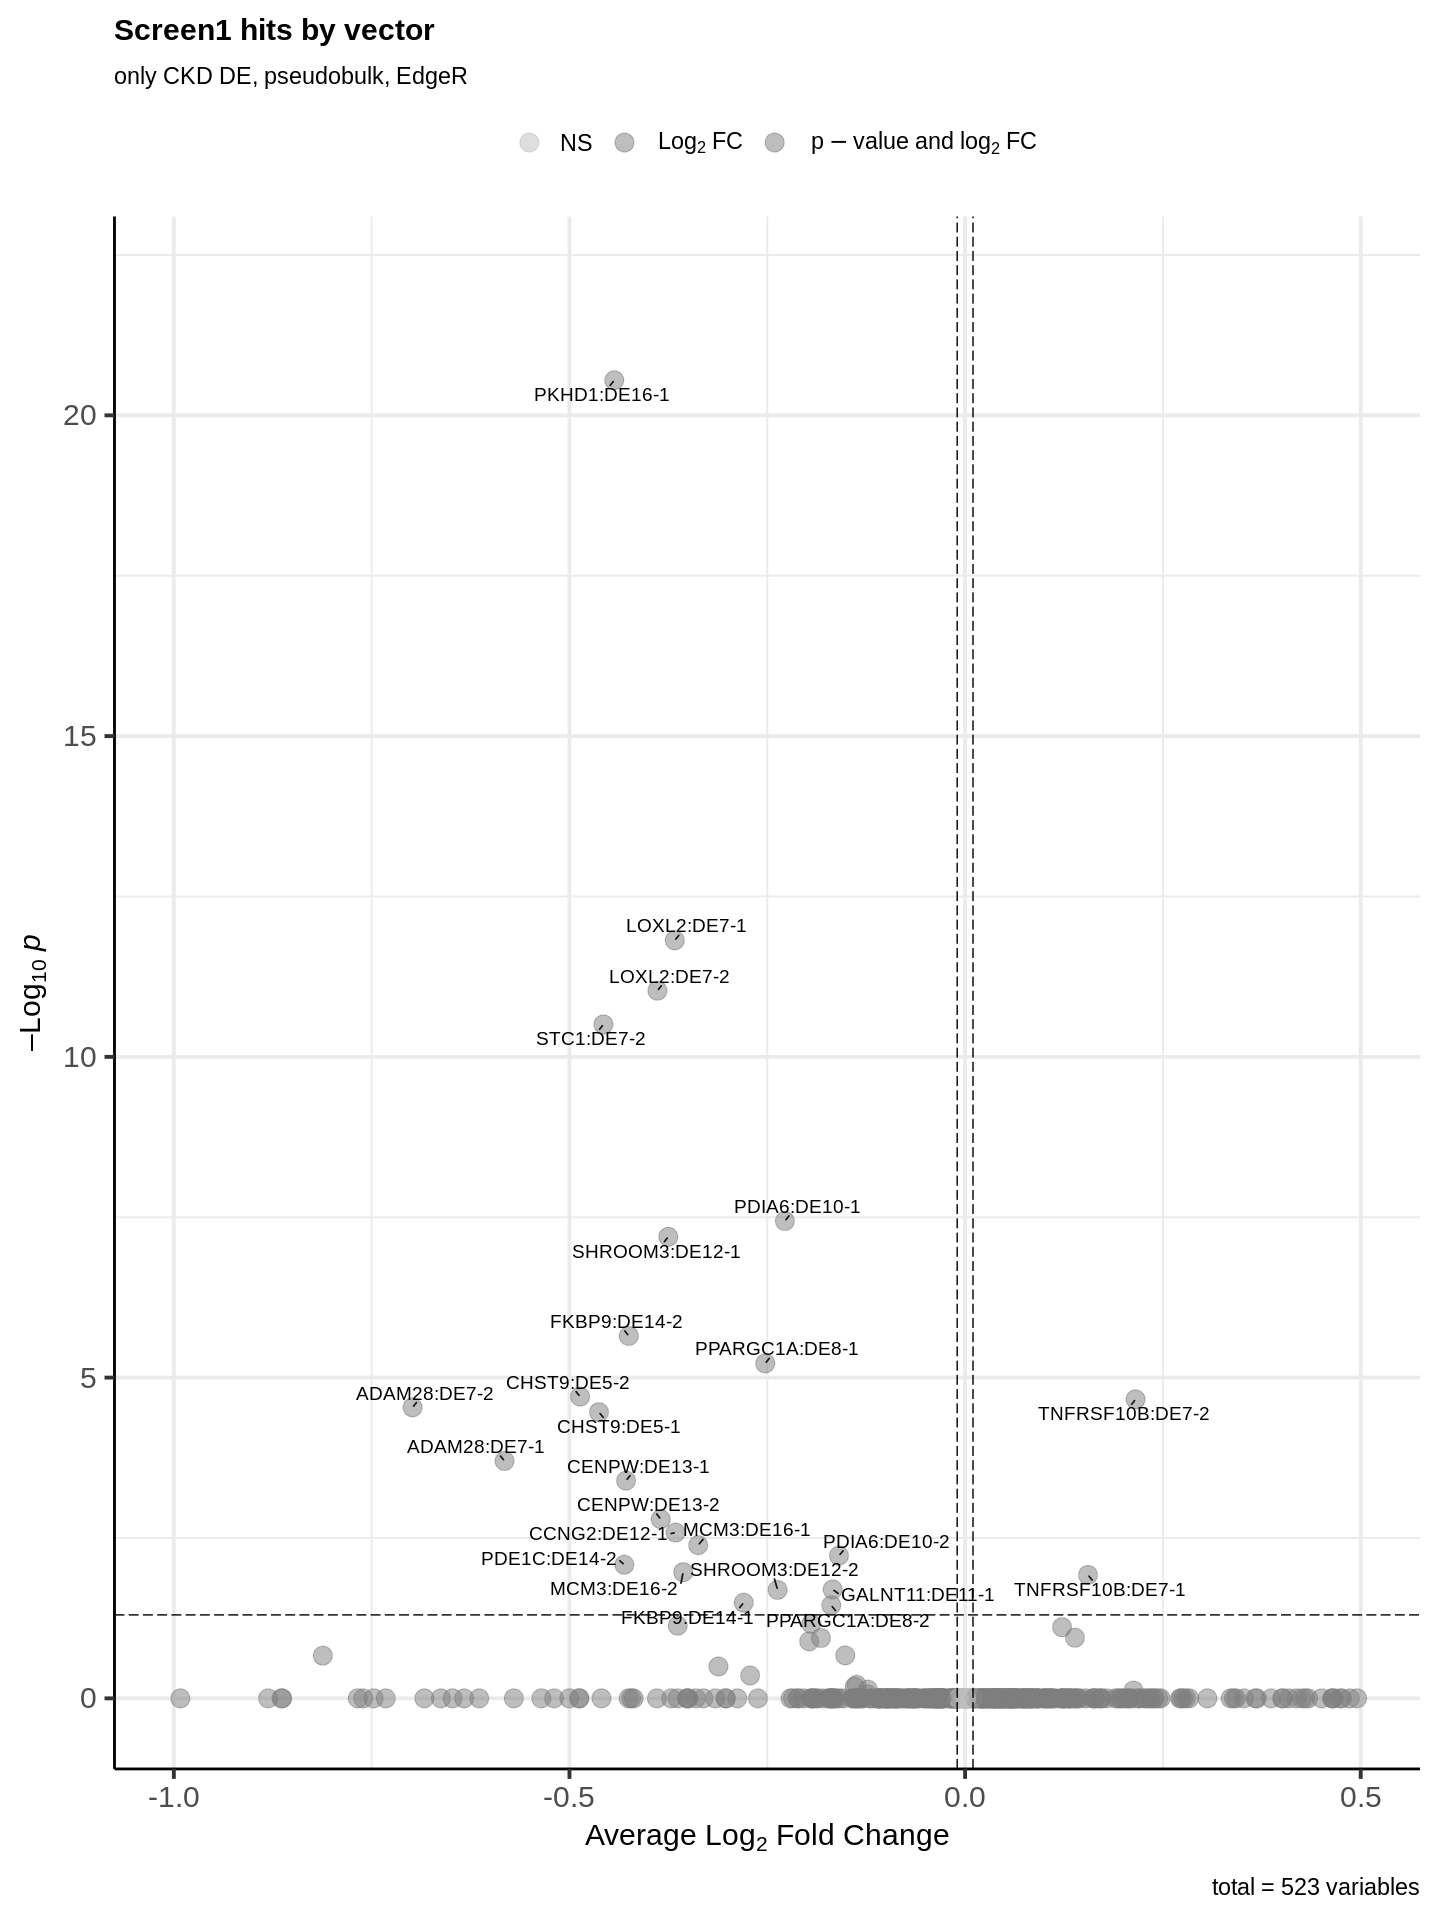

In [43]:
de_filter = (df_neighbor_de$label == 'CKD DE') 
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
df_neighbor_de_subset$plot_label = paste0(df_neighbor_de_subset$de_gene, ":", df_neighbor_de_subset$plasmid)

options(repr.plot.width = 12, repr.plot.height = 16)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$plot_label,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, 'hits by vector'),
                subtitle = 'only CKD DE, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 1e-5,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-1.5, 0.5) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$plot_label,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, 'hits by vector'),
                subtitle = 'only CKD DE, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 0.05,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-1., 0.5) +
                ylim(0, 22) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 
p2


# Inspect further

In [44]:
df_neighbor_de %>% filter((subclass == 'ckd_de')) %>% filter(logFC < 0) %>% filter(PValue < 1e-2) %>% arrange(PValue) %>% head(40)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-0.95,6.03,609,6.4e-134,NDRG1,DE6,ckd_de,CKD DE,DE6-2,7.8e-131
2,-1.15,6.02,603,3.0e-89,NDRG1,DE6,ckd_de,CKD DE,DE6-1,3.7e-86
3,-0.51,8.29,373,5.3e-83,RBPMS,DE15,ckd_de,CKD DE,DE15-2,6.4e-80
4,-0.48,8.30,285,8.1e-64,RBPMS,DE15,ckd_de,CKD DE,DE15-1,9.9e-61
5,-0.72,4.91,157,7.5e-36,STC1,DE7,ckd_de,CKD DE,DE7-1,9.1e-33
6,-0.87,4.80,155,1.7e-35,CCNB1,DE4,ckd_de,CKD DE,DE4-2,2.1e-32
7,-0.85,4.80,211,1.2e-29,CCNB1,DE4,ckd_de,CKD DE,DE4-1,1.5e-26
8,-0.44,6.46,104,2.3e-24,PKHD1,DE16,ckd_de,CKD DE,DE16-1,2.8e-21
9,-0.37,5.56,64,1.3e-15,LOXL2,DE7,ckd_de,CKD DE,DE7-1,1.5e-12


In [45]:
df_neighbor_de %>% filter((subclass == 'ckd_de')) %>% filter(logFC > 0) %>% filter(PValue < 1e-2) %>% arrange(PValue) %>% head(30)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,plasmid,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0.215,6.6,31.7,1.8e-08,TNFRSF10B,DE7,ckd_de,CKD DE,DE7-2,2.2e-05
2,0.155,6.6,19.6,9.8e-06,TNFRSF10B,DE7,ckd_de,CKD DE,DE7-1,1.2e-02
3,0.123,7.7,16.0,6.4e-05,NRIP1,DE1,ckd_de,CKD DE,DE1-2,7.8e-02
4,0.139,7.7,15.3,9.3e-05,NRIP1,DE1,ckd_de,CKD DE,DE1-1,1.1e-01
5,1.615,-2.0,12.8,3.5e-04,LINC02028,DE2,ckd_de,CKD DE,DE2-2,4.3e-01
6,0.213,4.3,11.7,6.2e-04,TNFRSF10A,DE7,ckd_de,CKD DE,DE7-1,7.6e-01
7,0.099,6.6,9.5,2.0e-03,PPP2CB,DE15,ckd_de,CKD DE,DE15-2,1.0e+00
8,0.620,0.7,9.5,2.0e-03,PLAAT1,DE2,ckd_de,CKD DE,DE2-2,1.0e+00
9,0.220,4.1,8.9,2.8e-03,THAP6,DE12,ckd_de,CKD DE,DE12-1,1.0e+00


# Visualize

In [46]:
head(seurat_rna$dCas9)

AAACCCAAGAGCAGCT-1_1 AAACCCAAGCTTAAGA-1_1 AAACCCAAGGCTGTAG-1_1 
                  20                   55                  181 
AAACCCAAGGTTTACC-1_1 AAACCCAAGTGATCGG-1_1 AAACGAACAATTGCTG-1_1 
                  58                    1                  100

In [47]:
seurat_rna$sct_dCas9 = seurat_combined[['SCT']]@data['dCas9',]

In [48]:
head(seurat_combined[['SCT']]@data['dCas9',],5)
head(seurat_rna$sct_dCas9,5)

AAACCCAAGAGCAGCT-1_1 AAACCCAAGCTTAAGA-1_1 AAACCCAAGGCTGTAG-1_1 
                 3.0                  3.5                  4.2 
AAACCCAAGGTTTACC-1_1 AAACCCAAGTGATCGG-1_1 
                 3.2                  0.0

AAACCCAAGAGCAGCT-1_1 AAACCCAAGCTTAAGA-1_1 AAACCCAAGGCTGTAG-1_1 
                 3.0                  3.5                  4.2 
AAACCCAAGGTTTACC-1_1 AAACCCAAGTGATCGG-1_1 
                 3.2                  0.0

# Redundant

In [49]:
target
table(Idents(seurat_dummy))

[1] "DE17"


vector_positive target_negative        vector_B 
           1080           25106             956 

In [50]:
seurat_dummy$mark = Idents(seurat_dummy)
seurat_dummy2 = NormalizeData(seurat_dummy)

In [51]:
seurat_pseudo <- AverageExpression(seurat_dummy2, assay = 'RNA', slot = 'data', return.seurat = TRUE, group.by = c('mark'))
#seurat_pseudo = NormalizeData(seurat_pseudo)
#seurat_dummy2_bulk <- NormalizeData(seurat_dummy2_bulk)

Centering and scaling data matrix



In [52]:
#seurat_dummy2_bulk = FindVariableFeatures(seurat_dummy2_bulk) 
#seurat_dummy2_bulk = ScaleData(seurat_dummy2_bulk) 
#seurat_dummy2_bulk = RunPCA(seurat_dummy2_bulk, npcs = 20, features = VariableFeatures(seurat_dummy2_bulk))

In [53]:
seurat_pseudo[['RNA']]@data['ANPEP',]

vector_positive target_negative        vector_B 
           0.79            0.88            0.78

In [54]:
s = sum(seurat_rna[['RNA']]@counts[,1])
c = seurat_rna[['RNA']]@counts['ANPEP',1]
d = seurat_rna[['RNA']]@data['ANPEP',1]

In [55]:
log(1+ (c/s)*10000)
d

[1] 1.9

[1] 1.9